# Init

In [1]:
from transformers import BertTokenizer, BertTokenizerFast, BertModel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score, accuracy_score
from scipy.special import expit as sigmoid

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import os
from itertools import repeat
from collections import defaultdict
from random import random
from knockknock import telegram_sender

CHAT_ID = 471484501
BOT_TOKEN = "787061842:AAEoH5D5zzPZBpfMDFLvN2gq6YsoI-qMCGg"

import torch

if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

N_EPOCH = 100
N_INTENT = 17
N_SLOT = 72
seed = 0

In [2]:
class IntentDataset(Dataset):
    def __init__(self, data):
        self.data = data[['text', 'intent', 'slot']]
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return row['text'], row['intent'], row['slot']
    
class DatasetManager:
    def __init__(self, data_path, batch_size=16, device='cpu'):
        self.device = device
        self.tok = BertTokenizerFast.from_pretrained("bert-base-uncased")
        self.model = BertModel.from_pretrained("bert-base-uncased").to(device)
        
        for p in self.model.parameters():
            p.requires_grad = False
            
        train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
        test_df = pd.read_csv(os.path.join(data_path, 'test.csv'))
        
        self.intent_enc = None
        train_df = self.__encode_intent(train_df)
        test_df = self.__encode_intent(test_df)
        
        self.slot_enc = None
        train_df = self.__encode_slot(train_df)
        test_df = self.__encode_slot(test_df)
        
        train_dataset = IntentDataset(train_df)
        test_dataset = IntentDataset(test_df)
        
        self.train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=self.collate_fn)
        self.test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=self.collate_fn)
        
    def encode(self, text):
        x = self.tok(list(text), add_special_tokens=False, padding=True, return_tensors='pt')
        x = self.model(**x.to(self.device))
        
        return x.last_hidden_state.detach().to(self.device)
    
    def pad_slot(self, slot):
#         slot = map(lambda x: torch.Tensor([int(i) for i in x.split()]), slot)
        slot = nn.utils.rnn.pad_sequence(slot, batch_first=True, padding_value=-1)
        return slot.to(self.device).long()
    
    def collate_fn(self, batch):        
        text = [i[0] for i in batch]
        intent = [i[1] for i in batch]
        slot = [i[2] for i in batch]
        
        
        X = self.encode(text)       
        intent = torch.Tensor(intent).float().to(self.device)
        slot = self.pad_slot(slot)
        
        return X, intent, slot
    
    def __encode_intent(self, df):
        if self.intent_enc is None:
            intents = set()
            for i in df['intent'].unique():
                intents.update(set(i.split('#')))
            self.intent_enc = list(intents)
        
        df = df.copy()
        df['intent'] = df['intent'].apply(lambda x: [int(i in x.split('#')) for i in self.intent_enc])
        
        return df
    
    def __encode_slot(self, df):
        if self.slot_enc is None:
            slots = set(df['slot'].apply(lambda x: list(set(x.split()))).sum())
            self.slot_enc = {j:i for i,j in enumerate(slots - {'O'}, 1)}
            self.slot_enc['O'] = 0
            self.num_slots = len(slots)
        
        df = df.copy()  
        df['slot'] = df['slot'].apply(
            lambda x: [self.slot_enc.get(i, 0) for i in x.split()]
        )
        df['token_len'] = df['text'].apply(
            lambda x: self.tok(x.split(), add_special_tokens=False, return_length=True)['length']
        )
        df['slot'] = df.apply(
            lambda row: sum([list(repeat(i, j)) for i,j in zip(row['slot'], row['token_len'])], list()), 
            axis=1
        )
        df.drop(columns=['token_len'], inplace=True)
        df['slot'] = df['slot'].apply(torch.Tensor)
        
        return df

In [3]:
class BaseStep:
    def __init__(self, net, criterion, optimizer):
        self.net = net
        
        if isinstance(criterion, dict):
            self.intent_criterion = criterion['intent']
            self.slot_criterion = criterion['slot']
        else:
            self.intent_criterion = criterion
            self.slot_criterion = criterion
            
        self.optimizer = optimizer
        
    def eval(self):
        self.net.eval()
    
    def train(self):
        self.net.train()
    
    def forward(self, X, slot, intent):
        raise NotImplementedError
        
    def step(self, X, slot, intent):
        self.optimizer.zero_grad()
        
        loss, acc, f1 = self.forward(X, slot, intent)
        loss.backward()
        
        self.optimizer.step()
        
        return loss, acc, f1

In [4]:
def eval_net(stepperers):
    for s in stepperers.values():
        s.eval()
        
    with torch.no_grad():
        test_loss = defaultdict(float)
        acc, f1 = defaultdict(int), defaultdict(int)
        for inputs in d.test:            
            X, intent, slot = inputs
            
            for step_name, step in stepperers.items():
                loss, _acc, _f1 = step.forward(X, slot, intent)
                
                if isinstance(loss, dict):
                    for t in loss.keys():
                        test_loss[f'{step_name}_{t}'] += loss[t].item()
                        acc[f'{step_name}_{t}'] += _acc[t]
                        f1[f'{step_name}_{t}'] += _f1[t]
                else:
                    test_loss[step_name] += loss.item()
                    acc[step_name] += _acc
                    f1[step_name] += _f1
    
    for s in stepperers.values():
        s.train()
    
    for step_name in test_loss.keys():
        test_loss[step_name] = test_loss[step_name] / len(d.test)
        acc[step_name] = acc[step_name] / len(d.test)
        f1[step_name] = f1[step_name] / len(d.test)
    
    return test_loss, acc, f1

In [5]:
# @telegram_sender(token=BOT_TOKEN, chat_id=CHAT_ID)
def train(steppers, n_epoch):
    for i in steppers.values():
        i.train()

    history = defaultdict(list)
    for i in trange(n_epoch):
        train_loss = defaultdict(float)
        acc, f1 = defaultdict(int), defaultdict(int)
        for inputs in tqdm(d.train):
            X, intent, slot = inputs

            for step_name, step in steppers.items():
                loss, _acc, _f1 = step.step(X, slot, intent)
                if isinstance(loss, dict):
                    for t in loss.keys():
                        train_loss[f'{step_name}_{t}'] += loss[t].item()
                        acc[f'{step_name}_{t}'] += _acc[t]
                        f1[f'{step_name}_{t}'] += _f1[t]
                else:
                    train_loss[step_name] += loss.item()
                    acc[step_name] += _acc
                    f1[step_name] += _f1
                    
        print(f'Epoch {i + 1} / {n_epoch}')
        
        test_loss, test_acc, test_f1 = eval_net(steppers)
        
        for step_name in train_loss.keys():
            print('------------------')
            print(step_name)
            print(f'Train loss: {train_loss[step_name] / len(d.train):.4f}')
            print(f'Train acc: {acc[step_name] / len(d.train):.4f}')
            print(f'Train f1: {f1[step_name] / len(d.train):.4f}')
            print(f'Test loss: {test_loss[step_name]:.4f}')
            print(f'Test acc: {test_acc[step_name]:.4f}')
            print(f'Test f1: {test_f1[step_name]:.4f}')

        for step_name in train_loss.keys():
            history['epoch'].append(i + 1)
            history['model'].append(step_name)
            history['train_loss'].append(train_loss[step_name] / len(d.train))
            history['train_acc'].append(acc[step_name] / len(d.train))
            history['train_f1'].append(f1[step_name] / len(d.train))
            history['test_loss'].append(test_loss[step_name])
            history['test_acc'].append(test_acc[step_name])
            history['test_f1'].append(test_f1[step_name])
    
    return pd.DataFrame(history)

In [6]:
def accuracy(y_true, y_pred):
    num = ((y_pred == y_true) & (y_true != -1)).sum().item()
    denom = (y_true != -1).sum().item()
    return num / denom

# Simple model

In [81]:
d = DatasetManager('./data/atis_snips/atis/', batch_size=256, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
class Net(nn.Module):
    def __init__(self, input_size, num_intent, hidden_size=200, lstm_layers=4):
        super(Net, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers        
        )
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * lstm_layers * 4, 100),
            nn.ReLU(),
            
            nn.BatchNorm1d(100),
            nn.Dropout(0.4),
            nn.Linear(100, num_intent),
#             nn.ReLU(),
            
#             nn.BatchNorm1d(200),
#             nn.Dropout(0.4),
#             nn.Linear(200, num_intent)
        )
    
    def forward(self, X):
        X_lstm = self.__lstm(X)
        return self.__fc(torch.cat(X_lstm[1]).transpose(0, 1).reshape(X.shape[0], -1))

In [5]:
def eval_net(net):
    net.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct, total = 0, 0
        for inputs in d.test:
            text, intent, slot = inputs
            X = d.encode(text)
            slot = d.pad_slot(slot)

            y_intent = net(X)

            loss = criterion(y_intent, intent.to(device))

            test_loss += loss.item()

            correct += (y_intent.argmax(axis=1).cpu() == intent).sum().item()
            total += intent.shape[0]

        print(f'Test loss: {test_loss / len(d.test):.4f}')
        print(f'Test acc: {correct / total:.4f}')
    net.train()
    return test_loss / len(d.test), correct / total

In [6]:
torch.manual_seed(seed)
net = Net(768, N_INTENT, 50, 2).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-6)

In [7]:
net.train()
history = defaultdict(list)
for i in trange(N_EPOCH):
    train_loss = 0.0
    correct, total = 0, 0
    for inputs in tqdm(d.train):
        text, intent, slot = inputs
        X = d.encode(text)
        slot = d.pad_slot(slot)
        
        y_intent = net(X)
        
        optimizer.zero_grad()
        
        loss = criterion(y_intent, intent.to(device))

        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        correct += (y_intent.argmax(axis=1).cpu() == intent).sum().item()
        total += intent.shape[0]
    
    print(f'Epoch {i + 1} / {N_EPOCH}')
    print(f'Train loss: {train_loss / len(d.train):.4f}')
    print(f'Train acc: {correct / total:.4f}')
    test_loss, test_acc = eval_net(net)
    
    history['epoch'].append(i + 1)
    history['train_loss'].append(train_loss / len(d.train))
    history['train_acc'].append(correct / total)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1 / 30
Train loss: 0.9684
Train acc: 0.7086
Test loss: 0.5740
Test acc: 0.8614


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2 / 30
Train loss: 0.5083
Train acc: 0.8662
Test loss: 0.4254
Test acc: 0.8871


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 3 / 30
Train loss: 0.3942
Train acc: 0.9009
Test loss: 0.3591
Test acc: 0.9029


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 4 / 30
Train loss: 0.3310
Train acc: 0.9175
Test loss: 0.3310
Test acc: 0.9071


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 5 / 30
Train loss: 0.2936
Train acc: 0.9270
Test loss: 0.2850
Test acc: 0.9143


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 6 / 30
Train loss: 0.2636
Train acc: 0.9350
Test loss: 0.2965
Test acc: 0.9171


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 7 / 30
Train loss: 0.2418
Train acc: 0.9386
Test loss: 0.2674
Test acc: 0.9214


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 8 / 30
Train loss: 0.2273
Train acc: 0.9426
Test loss: 0.2508
Test acc: 0.9243


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 9 / 30
Train loss: 0.2149
Train acc: 0.9468
Test loss: 0.2464
Test acc: 0.9200


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 10 / 30
Train loss: 0.2003
Train acc: 0.9500
Test loss: 0.2354
Test acc: 0.9286


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 11 / 30
Train loss: 0.1906
Train acc: 0.9528
Test loss: 0.2281
Test acc: 0.9243


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 12 / 30
Train loss: 0.1810
Train acc: 0.9558
Test loss: 0.2163
Test acc: 0.9214


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 13 / 30
Train loss: 0.1729
Train acc: 0.9566
Test loss: 0.2229
Test acc: 0.9229


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 14 / 30
Train loss: 0.1681
Train acc: 0.9581
Test loss: 0.2112
Test acc: 0.9271


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 15 / 30
Train loss: 0.1581
Train acc: 0.9594
Test loss: 0.2093
Test acc: 0.9257


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 16 / 30
Train loss: 0.1511
Train acc: 0.9642
Test loss: 0.2152
Test acc: 0.9286


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 17 / 30
Train loss: 0.1472
Train acc: 0.9645
Test loss: 0.2207
Test acc: 0.9286


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 18 / 30
Train loss: 0.1421
Train acc: 0.9655
Test loss: 0.2036
Test acc: 0.9286


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 19 / 30
Train loss: 0.1384
Train acc: 0.9641
Test loss: 0.1964
Test acc: 0.9286


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 20 / 30
Train loss: 0.1317
Train acc: 0.9662
Test loss: 0.1964
Test acc: 0.9314


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 21 / 30
Train loss: 0.1318
Train acc: 0.9666
Test loss: 0.1920
Test acc: 0.9300


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 22 / 30
Train loss: 0.1247
Train acc: 0.9715
Test loss: 0.1935
Test acc: 0.9329


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 23 / 30
Train loss: 0.1230
Train acc: 0.9695
Test loss: 0.1851
Test acc: 0.9329


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 24 / 30
Train loss: 0.1173
Train acc: 0.9718
Test loss: 0.1996
Test acc: 0.9314


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 25 / 30
Train loss: 0.1162
Train acc: 0.9710
Test loss: 0.1809
Test acc: 0.9357


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 26 / 30
Train loss: 0.1144
Train acc: 0.9717
Test loss: 0.1869
Test acc: 0.9329


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 27 / 30
Train loss: 0.1090
Train acc: 0.9751
Test loss: 0.1795
Test acc: 0.9357


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 28 / 30
Train loss: 0.1069
Train acc: 0.9743
Test loss: 0.1823
Test acc: 0.9314


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 29 / 30
Train loss: 0.1054
Train acc: 0.9752
Test loss: 0.1849
Test acc: 0.9329


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 30 / 30
Train loss: 0.1014
Train acc: 0.9755
Test loss: 0.1815
Test acc: 0.9386


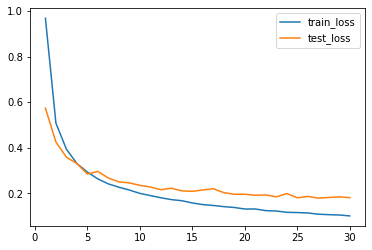

In [8]:
plt.plot(history['epoch'], history['train_loss'], label='train_loss')
plt.plot(history['epoch'], history['test_loss'], label='test_loss')
plt.legend()

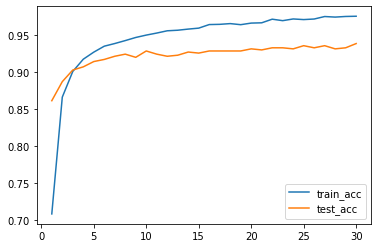

In [9]:
plt.plot(history['epoch'], history['train_acc'], label='train_acc')
plt.plot(history['epoch'], history['test_acc'], label='test_acc')
plt.legend()

* w/o bidir and w/o overfit control: 0.9860, 0.9514
* with bidir and w/o overfit control: 0.9822, 0.9171
* w/o bidir and with overfit control: 0.9785, 0.9100
* with bidir and with overfit control: 0.9820, 0.9457

# Отбрасываем слоты в обучающем датасете

In [57]:
for i in ['train', 'test', 'dev']:
    df = pd.read_csv(f'data/atis_snips/atis/{i}.csv')

    df['text'] = df.apply(lambda x: ' '.join([i for i,j in zip(x['text'].split(), x['slot'].split()) if j == 'O']), axis=1)

    df.to_csv(f'data/processed/drop_slots/{i}.csv', index=False)

In [25]:
names = ['drop_slots', 'origin']
datasets = [
    DatasetManager('data/processed/drop_slots/', batch_size=256, device=device),
    DatasetManager('data/atis_snips/atis/', batch_size=256, device=device)
]

for i, d_train in zip(names, datasets):
    for j, d_test in zip(names, datasets):
        print(f'Train: {i}, test: {j}')
        
        net = Net(768, N_INTENT, 50).to(device)

        criterion = nn.CrossEntropyLoss(ignore_index=-1)
        optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-2)
        
        net.train()
        for _ in trange(N_EPOCH):
            train_loss = 0.0
            correct, total = 0, 0
            for inputs in d_train.train:
                text, intent, slot = inputs
                X = d.encode(text)
                slot = d.pad_slot(slot)

                y_intent = net(X)

                optimizer.zero_grad()

                loss = criterion(y_intent, intent.to(device))

                loss.backward()

                optimizer.step()

                train_loss += loss.item()
                correct += (y_intent.argmax(axis=1).cpu() == intent).sum().item()
                total += intent.shape[0]

        print(f'Train loss: {train_loss / len(d.train):.4f}')
        print(f'Train Acc: {correct / total:.4f}')

        net.eval()
        with torch.no_grad():
            test_loss = 0.0
            correct, total = 0, 0
            for inputs in d_test.test:
                text, intent, slot = inputs
                X = d.encode(text)
                slot = d.pad_slot(slot)

                y_intent = net(X)

                loss = criterion(y_intent, intent.to(device))

                test_loss += loss.item()

                correct += (y_intent.argmax(axis=1).cpu() == intent).sum().item()
                total += intent.shape[0]
            
            
            print(f'Test loss: {test_loss / len(d.test):.4f}')
            print(f'Test Acc: {correct / total:.4f}')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predic

Train: drop_slots, test: drop_slots


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.1905
Train Acc: 0.9378
Test loss: 0.2525
Test Acc: 0.9086
Train: drop_slots, test: origin


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.1756
Train Acc: 0.9405
Test loss: 0.8430
Test Acc: 0.7014
Train: origin, test: drop_slots


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.1362
Train Acc: 0.9585
Test loss: 0.8548
Test Acc: 0.7457
Train: origin, test: origin


  0%|          | 0/30 [00:00<?, ?it/s]

Train loss: 0.1324
Train Acc: 0.9612
Test loss: 0.1762
Test Acc: 0.9443


# Intent + Slot

In [7]:
d = DatasetManager('./data/atis_snips/atis/', batch_size=256, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
class Net(nn.Module):
    def __init__(self, input_size, num_intent, num_slots, hidden_size=200, lstm_layers=2):
        super(Net, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers 
            
        )
        self.__fc_intent = nn.Sequential(
#             nn.BatchNorm1d(hidden_size * 4 * lstm_layers),
#             nn.Dropout(0.4),
            nn.Linear(hidden_size * 4 * lstm_layers, num_intent),
            nn.Sigmoid()
        )
        
        self.__fc_slot = nn.Sequential(
            nn.Linear(hidden_size * 2, num_slots)
        )
    
    def forward(self, X):
        X_lstm = self.__lstm(X)
        
        y_intent = self.__fc_intent(torch.cat(X_lstm[1]).transpose(0, 1).reshape(X.shape[0], -1))
        y_slot = self.__fc_slot(X_lstm[0])
        
        return y_intent, y_slot

In [12]:
class SlotAndIntentStep(BaseStep):
    def __init__(self, net, criterion, optimizer, alpha):
        super(SlotAndIntentStep, self).__init__(net, criterion, optimizer)
        self.alpha = alpha
        
    def forward(self, X, slot, intent):
        y_intent, y_slot = self.net(X)
        
        loss = {
            'intent': self.intent_criterion(y_intent, intent.to(device)),
            'slot': self.slot_criterion(y_slot.transpose(1, 2), slot.to(device))
        }
        
        y_intent = (y_intent > 0.5).float()
        y_slot = y_slot.argmax(axis=-1)
        
        acc = {
            'intent': accuracy(intent, y_intent),
            'slot': accuracy(slot, y_slot)
        }
        
        f1 = {
            'intent': f1_score(intent.cpu(), y_intent.cpu(), average='macro', zero_division=1),
            'slot': f1_score(
                y_true=slot.cpu().flatten(),
                y_pred=y_slot.cpu().flatten(), 
                labels=range(N_SLOT), average='macro',
                zero_division=1
            )
        }
        
        return loss, acc, f1
    
    def step(self, X, slot, intent):
        self.optimizer.zero_grad()
        
        loss, acc, f1 = self.forward(X, slot, intent)
        
        total_loss = (1 - self.alpha) * loss['intent'] + self.alpha * loss['slot']
        
        total_loss.backward()
        
        self.optimizer.step()
        
        return loss, acc, f1

class ProbSlotAndIntentStep(SlotAndIntentStep):    
    def step(self, X, slot, intent):
        self.optimizer.zero_grad()
        
        loss, acc, f1 = self.forward(X, slot, intent)
        
        if random() < alpha:
            total_loss = loss['slot']
        else:
            total_loss = loss['intent']
        
        total_loss.backward()
        
        self.optimizer.step()
        
        return loss, acc, f1

In [13]:
steppers = dict()
a = np.linspace(-3, 3, 9)
alpha_list = [round(i, 2) for i in sigmoid(a)]

for alpha in alpha_list:
    torch.manual_seed(seed)
    net = Net(768, N_INTENT, len(d.slot_enc), 200, 2).to(device)
    criterion = {
        'intent': nn.BCELoss(),
        'slot': nn.CrossEntropyLoss(ignore_index=-1)
    }
    optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)

    steppers[f'alpha={alpha:.2f}'] = SlotAndIntentStep(net, criterion, optimizer, alpha)

In [14]:
history = train(steppers, N_EPOCH)
history.to_csv('history/intent_and_slot_atis.csv', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1 / 100
------------------
alpha=0.05_intent
Train loss: 0.2784
Train acc: 0.9180
Train f1: 0.3236
Test loss: 0.1093
Test acc: 0.9758
Test f1: 0.3111
------------------
alpha=0.05_slot
Train loss: 2.6605
Train acc: 0.5040
Train f1: 0.3316
Test loss: 1.9132
Test acc: 0.5856
Test f1: 0.3487
------------------
alpha=0.10_intent
Train loss: 0.2854
Train acc: 0.9194
Train f1: 0.3269
Test loss: 0.1070
Test acc: 0.9743
Test f1: 0.3107
------------------
alpha=0.10_slot
Train loss: 2.3542
Train acc: 0.5806
Train f1: 0.3306
Test loss: 1.8891
Test acc: 0.5855
Test f1: 0.3488
------------------
alpha=0.18_intent
Train loss: 0.3063
Train acc: 0.9171
Train f1: 0.3277
Test loss: 0.1228
Test acc: 0.9737
Test f1: 0.3123
------------------
alpha=0.18_slot
Train loss: 2.0241
Train acc: 0.5958
Train f1: 0.3329
Test loss: 1.5696
Test acc: 0.6440
Test f1: 0.3562
------------------
alpha=0.32_intent
Train loss: 0.4723
Train acc: 0.8989
Train f1: 0.3193
Test loss: 0.4462
Test acc: 0.9609
Test f1: 0.319

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2 / 100
------------------
alpha=0.05_intent
Train loss: 0.0744
Train acc: 0.9765
Train f1: 0.3781
Test loss: 0.0754
Test acc: 0.9791
Test f1: 0.3263
------------------
alpha=0.05_slot
Train loss: 1.5945
Train acc: 0.6352
Train f1: 0.3558
Test loss: 1.5227
Test acc: 0.6315
Test f1: 0.3819
------------------
alpha=0.10_intent
Train loss: 0.0723
Train acc: 0.9772
Train f1: 0.3835
Test loss: 0.0734
Test acc: 0.9802
Test f1: 0.3636
------------------
alpha=0.10_slot
Train loss: 1.4632
Train acc: 0.6647
Train f1: 0.3580
Test loss: 1.2944
Test acc: 0.7243
Test f1: 0.3874
------------------
alpha=0.18_intent
Train loss: 0.0839
Train acc: 0.9746
Train f1: 0.3669
Test loss: 0.0812
Test acc: 0.9781
Test f1: 0.3271
------------------
alpha=0.18_slot
Train loss: 1.0491
Train acc: 0.7669
Train f1: 0.3848
Test loss: 0.8657
Test acc: 0.8000
Test f1: 0.4359
------------------
alpha=0.32_intent
Train loss: 0.2567
Train acc: 0.9774
Train f1: 0.4354
Test loss: 0.3079
Test acc: 0.9786
Test f1: 0.408

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3 / 100
------------------
alpha=0.05_intent
Train loss: 0.0528
Train acc: 0.9827
Train f1: 0.4307
Test loss: 0.0632
Test acc: 0.9830
Test f1: 0.4252
------------------
alpha=0.05_slot
Train loss: 1.1538
Train acc: 0.7354
Train f1: 0.3633
Test loss: 1.1020
Test acc: 0.7532
Test f1: 0.3939
------------------
alpha=0.10_intent
Train loss: 0.0483
Train acc: 0.9845
Train f1: 0.4514
Test loss: 0.0622
Test acc: 0.9835
Test f1: 0.4468
------------------
alpha=0.10_slot
Train loss: 0.9340
Train acc: 0.7948
Train f1: 0.3842
Test loss: 0.8821
Test acc: 0.7943
Test f1: 0.4240
------------------
alpha=0.18_intent
Train loss: 0.0541
Train acc: 0.9831
Train f1: 0.4402
Test loss: 0.0600
Test acc: 0.9826
Test f1: 0.4152
------------------
alpha=0.18_slot
Train loss: 0.6131
Train acc: 0.8509
Train f1: 0.4397
Test loss: 0.5994
Test acc: 0.8457
Test f1: 0.4851
------------------
alpha=0.32_intent
Train loss: 0.2003
Train acc: 0.9869
Train f1: 0.5043
Test loss: 0.2624
Test acc: 0.9835
Test f1: 0.464

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4 / 100
------------------
alpha=0.05_intent
Train loss: 0.0409
Train acc: 0.9875
Train f1: 0.5156
Test loss: 0.0584
Test acc: 0.9844
Test f1: 0.4774
------------------
alpha=0.05_slot
Train loss: 0.8341
Train acc: 0.8065
Train f1: 0.4005
Test loss: 0.8343
Test acc: 0.8075
Test f1: 0.4267
------------------
alpha=0.10_intent
Train loss: 0.0380
Train acc: 0.9882
Train f1: 0.5259
Test loss: 0.0567
Test acc: 0.9848
Test f1: 0.4812
------------------
alpha=0.10_slot
Train loss: 0.6530
Train acc: 0.8414
Train f1: 0.4280
Test loss: 0.6657
Test acc: 0.8283
Test f1: 0.4322
------------------
alpha=0.18_intent
Train loss: 0.0377
Train acc: 0.9885
Train f1: 0.5371
Test loss: 0.0496
Test acc: 0.9862
Test f1: 0.4830
------------------
alpha=0.18_slot
Train loss: 0.4143
Train acc: 0.8913
Train f1: 0.4941
Test loss: 0.4230
Test acc: 0.8894
Test f1: 0.4953
------------------
alpha=0.32_intent
Train loss: 0.1311
Train acc: 0.9892
Train f1: 0.5397
Test loss: 0.1784
Test acc: 0.9833
Test f1: 0.462

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5 / 100
------------------
alpha=0.05_intent
Train loss: 0.0295
Train acc: 0.9907
Train f1: 0.5879
Test loss: 0.0553
Test acc: 0.9863
Test f1: 0.4777
------------------
alpha=0.05_slot
Train loss: 0.6628
Train acc: 0.8392
Train f1: 0.4318
Test loss: 0.6772
Test acc: 0.8328
Test f1: 0.4521
------------------
alpha=0.10_intent
Train loss: 0.0275
Train acc: 0.9912
Train f1: 0.5877
Test loss: 0.0536
Test acc: 0.9869
Test f1: 0.4940
------------------
alpha=0.10_slot
Train loss: 0.5116
Train acc: 0.8684
Train f1: 0.4634
Test loss: 0.5458
Test acc: 0.8527
Test f1: 0.4850
------------------
alpha=0.18_intent
Train loss: 0.0272
Train acc: 0.9915
Train f1: 0.5923
Test loss: 0.0459
Test acc: 0.9875
Test f1: 0.5131
------------------
alpha=0.18_slot
Train loss: 0.2936
Train acc: 0.9219
Train f1: 0.5526
Test loss: 0.3665
Test acc: 0.9112
Test f1: 0.5451
------------------
alpha=0.32_intent
Train loss: 0.0682
Train acc: 0.9905
Train f1: 0.5734
Test loss: 0.0922
Test acc: 0.9870
Test f1: 0.437

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6 / 100
------------------
alpha=0.05_intent
Train loss: 0.0230
Train acc: 0.9930
Train f1: 0.6826
Test loss: 0.0417
Test acc: 0.9864
Test f1: 0.4837
------------------
alpha=0.05_slot
Train loss: 0.5426
Train acc: 0.8627
Train f1: 0.4535
Test loss: 0.5891
Test acc: 0.8474
Test f1: 0.4596
------------------
alpha=0.10_intent
Train loss: 0.0210
Train acc: 0.9932
Train f1: 0.6716
Test loss: 0.0465
Test acc: 0.9871
Test f1: 0.4944
------------------
alpha=0.10_slot
Train loss: 0.4173
Train acc: 0.8898
Train f1: 0.4909
Test loss: 0.4856
Test acc: 0.8681
Test f1: 0.4863
------------------
alpha=0.18_intent
Train loss: 0.0208
Train acc: 0.9935
Train f1: 0.6708
Test loss: 0.0490
Test acc: 0.9863
Test f1: 0.5207
------------------
alpha=0.18_slot
Train loss: 0.2301
Train acc: 0.9391
Train f1: 0.5929
Test loss: 0.3180
Test acc: 0.9190
Test f1: 0.5986
------------------
alpha=0.32_intent
Train loss: 0.0323
Train acc: 0.9926
Train f1: 0.6042
Test loss: 0.0606
Test acc: 0.9853
Test f1: 0.420

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7 / 100
------------------
alpha=0.05_intent
Train loss: 0.0175
Train acc: 0.9942
Train f1: 0.7174
Test loss: 0.0385
Test acc: 0.9886
Test f1: 0.5338
------------------
alpha=0.05_slot
Train loss: 0.4573
Train acc: 0.8812
Train f1: 0.4670
Test loss: 0.5358
Test acc: 0.8574
Test f1: 0.4578
------------------
alpha=0.10_intent
Train loss: 0.0161
Train acc: 0.9947
Train f1: 0.7278
Test loss: 0.0393
Test acc: 0.9883
Test f1: 0.5934
------------------
alpha=0.10_slot
Train loss: 0.3520
Train acc: 0.9040
Train f1: 0.5141
Test loss: 0.4318
Test acc: 0.8891
Test f1: 0.5292
------------------
alpha=0.18_intent
Train loss: 0.0165
Train acc: 0.9945
Train f1: 0.7318
Test loss: 0.0349
Test acc: 0.9885
Test f1: 0.6053
------------------
alpha=0.18_slot
Train loss: 0.1880
Train acc: 0.9499
Train f1: 0.6291
Test loss: 0.2851
Test acc: 0.9316
Test f1: 0.6503
------------------
alpha=0.32_intent
Train loss: 0.0222
Train acc: 0.9936
Train f1: 0.6477
Test loss: 0.0510
Test acc: 0.9869
Test f1: 0.529

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8 / 100
------------------
alpha=0.05_intent
Train loss: 0.0134
Train acc: 0.9955
Train f1: 0.7727
Test loss: 0.0418
Test acc: 0.9883
Test f1: 0.6077
------------------
alpha=0.05_slot
Train loss: 0.3987
Train acc: 0.8932
Train f1: 0.4694
Test loss: 0.4516
Test acc: 0.8832
Test f1: 0.5222
------------------
alpha=0.10_intent
Train loss: 0.0119
Train acc: 0.9961
Train f1: 0.7836
Test loss: 0.0404
Test acc: 0.9885
Test f1: 0.5892
------------------
alpha=0.10_slot
Train loss: 0.3018
Train acc: 0.9190
Train f1: 0.5550
Test loss: 0.3752
Test acc: 0.9001
Test f1: 0.5926
------------------
alpha=0.18_intent
Train loss: 0.0130
Train acc: 0.9956
Train f1: 0.7762
Test loss: 0.0362
Test acc: 0.9877
Test f1: 0.6676
------------------
alpha=0.18_slot
Train loss: 0.1506
Train acc: 0.9593
Train f1: 0.6366
Test loss: 0.2563
Test acc: 0.9389
Test f1: 0.6269
------------------
alpha=0.32_intent
Train loss: 0.0166
Train acc: 0.9948
Train f1: 0.6910
Test loss: 0.0477
Test acc: 0.9854
Test f1: 0.537

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9 / 100
------------------
alpha=0.05_intent
Train loss: 0.0103
Train acc: 0.9966
Train f1: 0.8156
Test loss: 0.0364
Test acc: 0.9897
Test f1: 0.5772
------------------
alpha=0.05_slot
Train loss: 0.3411
Train acc: 0.9086
Train f1: 0.4963
Test loss: 0.4066
Test acc: 0.8941
Test f1: 0.5537
------------------
alpha=0.10_intent
Train loss: 0.0090
Train acc: 0.9972
Train f1: 0.8478
Test loss: 0.0343
Test acc: 0.9910
Test f1: 0.6809
------------------
alpha=0.10_slot
Train loss: 0.2613
Train acc: 0.9289
Train f1: 0.5679
Test loss: 0.3468
Test acc: 0.9101
Test f1: 0.5998
------------------
alpha=0.18_intent
Train loss: 0.0096
Train acc: 0.9969
Train f1: 0.8201
Test loss: 0.0360
Test acc: 0.9896
Test f1: 0.6508
------------------
alpha=0.18_slot
Train loss: 0.1261
Train acc: 0.9671
Train f1: 0.6962
Test loss: 0.2484
Test acc: 0.9471
Test f1: 0.6725
------------------
alpha=0.32_intent
Train loss: 0.0120
Train acc: 0.9961
Train f1: 0.7409
Test loss: 0.0399
Test acc: 0.9893
Test f1: 0.516

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10 / 100
------------------
alpha=0.05_intent
Train loss: 0.0091
Train acc: 0.9968
Train f1: 0.8267
Test loss: 0.0388
Test acc: 0.9889
Test f1: 0.6221
------------------
alpha=0.05_slot
Train loss: 0.2975
Train acc: 0.9199
Train f1: 0.5181
Test loss: 0.3857
Test acc: 0.9007
Test f1: 0.5536
------------------
alpha=0.10_intent
Train loss: 0.0070
Train acc: 0.9978
Train f1: 0.8876
Test loss: 0.0398
Test acc: 0.9881
Test f1: 0.6369
------------------
alpha=0.10_slot
Train loss: 0.2250
Train acc: 0.9375
Train f1: 0.5889
Test loss: 0.3183
Test acc: 0.9197
Test f1: 0.6260
------------------
alpha=0.18_intent
Train loss: 0.0073
Train acc: 0.9974
Train f1: 0.8459
Test loss: 0.0381
Test acc: 0.9894
Test f1: 0.6698
------------------
alpha=0.18_slot
Train loss: 0.1110
Train acc: 0.9695
Train f1: 0.6865
Test loss: 0.2284
Test acc: 0.9435
Test f1: 0.6627
------------------
alpha=0.32_intent
Train loss: 0.0093
Train acc: 0.9970
Train f1: 0.7989
Test loss: 0.0406
Test acc: 0.9886
Test f1: 0.62

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11 / 100
------------------
alpha=0.05_intent
Train loss: 0.0062
Train acc: 0.9981
Train f1: 0.8838
Test loss: 0.0406
Test acc: 0.9891
Test f1: 0.6454
------------------
alpha=0.05_slot
Train loss: 0.2647
Train acc: 0.9278
Train f1: 0.5566
Test loss: 0.3310
Test acc: 0.9157
Test f1: 0.5811
------------------
alpha=0.10_intent
Train loss: 0.0058
Train acc: 0.9983
Train f1: 0.9176
Test loss: 0.0375
Test acc: 0.9898
Test f1: 0.6474
------------------
alpha=0.10_slot
Train loss: 0.1955
Train acc: 0.9473
Train f1: 0.6242
Test loss: 0.2799
Test acc: 0.9302
Test f1: 0.6186
------------------
alpha=0.18_intent
Train loss: 0.0058
Train acc: 0.9980
Train f1: 0.8968
Test loss: 0.0352
Test acc: 0.9906
Test f1: 0.6860
------------------
alpha=0.18_slot
Train loss: 0.0913
Train acc: 0.9748
Train f1: 0.7036
Test loss: 0.2335
Test acc: 0.9452
Test f1: 0.6251
------------------
alpha=0.32_intent
Train loss: 0.0067
Train acc: 0.9979
Train f1: 0.8629
Test loss: 0.0438
Test acc: 0.9896
Test f1: 0.65

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12 / 100
------------------
alpha=0.05_intent
Train loss: 0.0045
Train acc: 0.9985
Train f1: 0.9165
Test loss: 0.0395
Test acc: 0.9905
Test f1: 0.7121
------------------
alpha=0.05_slot
Train loss: 0.2338
Train acc: 0.9368
Train f1: 0.5881
Test loss: 0.3228
Test acc: 0.9185
Test f1: 0.5899
------------------
alpha=0.10_intent
Train loss: 0.0041
Train acc: 0.9987
Train f1: 0.9312
Test loss: 0.0405
Test acc: 0.9909
Test f1: 0.7183
------------------
alpha=0.10_slot
Train loss: 0.1778
Train acc: 0.9509
Train f1: 0.6457
Test loss: 0.2594
Test acc: 0.9329
Test f1: 0.6373
------------------
alpha=0.18_intent
Train loss: 0.0036
Train acc: 0.9991
Train f1: 0.9511
Test loss: 0.0378
Test acc: 0.9902
Test f1: 0.7312
------------------
alpha=0.18_slot
Train loss: 0.0798
Train acc: 0.9779
Train f1: 0.7081
Test loss: 0.2182
Test acc: 0.9493
Test f1: 0.6430
------------------
alpha=0.32_intent
Train loss: 0.0052
Train acc: 0.9981
Train f1: 0.8868
Test loss: 0.0428
Test acc: 0.9906
Test f1: 0.70

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13 / 100
------------------
alpha=0.05_intent
Train loss: 0.0039
Train acc: 0.9988
Train f1: 0.9488
Test loss: 0.0399
Test acc: 0.9900
Test f1: 0.6753
------------------
alpha=0.05_slot
Train loss: 0.2137
Train acc: 0.9423
Train f1: 0.5951
Test loss: 0.3017
Test acc: 0.9242
Test f1: 0.6216
------------------
alpha=0.10_intent
Train loss: 0.0032
Train acc: 0.9991
Train f1: 0.9666
Test loss: 0.0373
Test acc: 0.9904
Test f1: 0.7185
------------------
alpha=0.10_slot
Train loss: 0.1589
Train acc: 0.9566
Train f1: 0.6479
Test loss: 0.2622
Test acc: 0.9374
Test f1: 0.6348
------------------
alpha=0.18_intent
Train loss: 0.0032
Train acc: 0.9990
Train f1: 0.9552
Test loss: 0.0488
Test acc: 0.9889
Test f1: 0.6666
------------------
alpha=0.18_slot
Train loss: 0.0651
Train acc: 0.9822
Train f1: 0.7381
Test loss: 0.2121
Test acc: 0.9511
Test f1: 0.6927
------------------
alpha=0.32_intent
Train loss: 0.0045
Train acc: 0.9987
Train f1: 0.9185
Test loss: 0.0459
Test acc: 0.9890
Test f1: 0.65

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14 / 100
------------------
alpha=0.05_intent
Train loss: 0.0029
Train acc: 0.9993
Train f1: 0.9633
Test loss: 0.0362
Test acc: 0.9909
Test f1: 0.6449
------------------
alpha=0.05_slot
Train loss: 0.1885
Train acc: 0.9483
Train f1: 0.6150
Test loss: 0.2836
Test acc: 0.9261
Test f1: 0.6389
------------------
alpha=0.10_intent
Train loss: 0.0023
Train acc: 0.9995
Train f1: 0.9696
Test loss: 0.0423
Test acc: 0.9905
Test f1: 0.6076
------------------
alpha=0.10_slot
Train loss: 0.1342
Train acc: 0.9637
Train f1: 0.6720
Test loss: 0.2443
Test acc: 0.9399
Test f1: 0.6858
------------------
alpha=0.18_intent
Train loss: 0.0026
Train acc: 0.9993
Train f1: 0.9643
Test loss: 0.0439
Test acc: 0.9898
Test f1: 0.6499
------------------
alpha=0.18_slot
Train loss: 0.0583
Train acc: 0.9843
Train f1: 0.7482
Test loss: 0.2152
Test acc: 0.9518
Test f1: 0.6527
------------------
alpha=0.32_intent
Train loss: 0.0037
Train acc: 0.9989
Train f1: 0.9560
Test loss: 0.0416
Test acc: 0.9898
Test f1: 0.62

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15 / 100
------------------
alpha=0.05_intent
Train loss: 0.0021
Train acc: 0.9996
Train f1: 0.9695
Test loss: 0.0415
Test acc: 0.9902
Test f1: 0.6430
------------------
alpha=0.05_slot
Train loss: 0.1779
Train acc: 0.9519
Train f1: 0.6163
Test loss: 0.2826
Test acc: 0.9281
Test f1: 0.5948
------------------
alpha=0.10_intent
Train loss: 0.0016
Train acc: 0.9997
Train f1: 0.9741
Test loss: 0.0467
Test acc: 0.9901
Test f1: 0.6203
------------------
alpha=0.10_slot
Train loss: 0.1200
Train acc: 0.9676
Train f1: 0.6830
Test loss: 0.2361
Test acc: 0.9446
Test f1: 0.6785
------------------
alpha=0.18_intent
Train loss: 0.0017
Train acc: 0.9996
Train f1: 0.9761
Test loss: 0.0451
Test acc: 0.9900
Test f1: 0.6699
------------------
alpha=0.18_slot
Train loss: 0.0483
Train acc: 0.9863
Train f1: 0.7379
Test loss: 0.2141
Test acc: 0.9508
Test f1: 0.6572
------------------
alpha=0.32_intent
Train loss: 0.0024
Train acc: 0.9993
Train f1: 0.9442
Test loss: 0.0450
Test acc: 0.9909
Test f1: 0.67

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16 / 100
------------------
alpha=0.05_intent
Train loss: 0.0015
Train acc: 0.9997
Train f1: 0.9816
Test loss: 0.0400
Test acc: 0.9914
Test f1: 0.6731
------------------
alpha=0.05_slot
Train loss: 0.1563
Train acc: 0.9581
Train f1: 0.6276
Test loss: 0.2657
Test acc: 0.9317
Test f1: 0.6120
------------------
alpha=0.10_intent
Train loss: 0.0015
Train acc: 0.9997
Train f1: 0.9811
Test loss: 0.0469
Test acc: 0.9898
Test f1: 0.6885
------------------
alpha=0.10_slot
Train loss: 0.1122
Train acc: 0.9688
Train f1: 0.7029
Test loss: 0.2230
Test acc: 0.9490
Test f1: 0.6680
------------------
alpha=0.18_intent
Train loss: 0.0014
Train acc: 0.9997
Train f1: 0.9822
Test loss: 0.0432
Test acc: 0.9902
Test f1: 0.7115
------------------
alpha=0.18_slot
Train loss: 0.0434
Train acc: 0.9878
Train f1: 0.7326
Test loss: 0.2064
Test acc: 0.9539
Test f1: 0.6535
------------------
alpha=0.32_intent
Train loss: 0.0015
Train acc: 0.9998
Train f1: 0.9759
Test loss: 0.0400
Test acc: 0.9912
Test f1: 0.70

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17 / 100
------------------
alpha=0.05_intent
Train loss: 0.0014
Train acc: 0.9997
Train f1: 0.9893
Test loss: 0.0436
Test acc: 0.9908
Test f1: 0.6690
------------------
alpha=0.05_slot
Train loss: 0.1502
Train acc: 0.9587
Train f1: 0.6505
Test loss: 0.2999
Test acc: 0.9318
Test f1: 0.6403
------------------
alpha=0.10_intent
Train loss: 0.0016
Train acc: 0.9997
Train f1: 0.9803
Test loss: 0.0418
Test acc: 0.9909
Test f1: 0.6605
------------------
alpha=0.10_slot
Train loss: 0.1000
Train acc: 0.9723
Train f1: 0.7167
Test loss: 0.2347
Test acc: 0.9452
Test f1: 0.6686
------------------
alpha=0.18_intent
Train loss: 0.0011
Train acc: 0.9998
Train f1: 0.9867
Test loss: 0.0447
Test acc: 0.9908
Test f1: 0.6870
------------------
alpha=0.18_slot
Train loss: 0.0415
Train acc: 0.9884
Train f1: 0.7713
Test loss: 0.2053
Test acc: 0.9550
Test f1: 0.6907
------------------
alpha=0.32_intent
Train loss: 0.0010
Train acc: 0.9999
Train f1: 0.9852
Test loss: 0.0429
Test acc: 0.9913
Test f1: 0.69

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18 / 100
------------------
alpha=0.05_intent
Train loss: 0.0010
Train acc: 0.9999
Train f1: 0.9875
Test loss: 0.0446
Test acc: 0.9915
Test f1: 0.6845
------------------
alpha=0.05_slot
Train loss: 0.1387
Train acc: 0.9617
Train f1: 0.6507
Test loss: 0.2565
Test acc: 0.9395
Test f1: 0.6999
------------------
alpha=0.10_intent
Train loss: 0.0011
Train acc: 0.9999
Train f1: 0.9913
Test loss: 0.0466
Test acc: 0.9908
Test f1: 0.6590
------------------
alpha=0.10_slot
Train loss: 0.0898
Train acc: 0.9751
Train f1: 0.7260
Test loss: 0.2259
Test acc: 0.9464
Test f1: 0.7021
------------------
alpha=0.18_intent
Train loss: 0.0008
Train acc: 0.9999
Train f1: 0.9942
Test loss: 0.0458
Test acc: 0.9904
Test f1: 0.6864
------------------
alpha=0.18_slot
Train loss: 0.0339
Train acc: 0.9903
Train f1: 0.7701
Test loss: 0.2171
Test acc: 0.9525
Test f1: 0.6775
------------------
alpha=0.32_intent
Train loss: 0.0012
Train acc: 0.9998
Train f1: 0.9793
Test loss: 0.0394
Test acc: 0.9916
Test f1: 0.67

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19 / 100
------------------
alpha=0.05_intent
Train loss: 0.0011
Train acc: 0.9998
Train f1: 0.9872
Test loss: 0.0431
Test acc: 0.9916
Test f1: 0.7423
------------------
alpha=0.05_slot
Train loss: 0.1193
Train acc: 0.9666
Train f1: 0.6618
Test loss: 0.2553
Test acc: 0.9395
Test f1: 0.6465
------------------
alpha=0.10_intent
Train loss: 0.0008
Train acc: 0.9999
Train f1: 0.9996
Test loss: 0.0430
Test acc: 0.9911
Test f1: 0.6789
------------------
alpha=0.10_slot
Train loss: 0.0863
Train acc: 0.9751
Train f1: 0.7171
Test loss: 0.2442
Test acc: 0.9439
Test f1: 0.6818
------------------
alpha=0.18_intent
Train loss: 0.0009
Train acc: 0.9998
Train f1: 0.9898
Test loss: 0.0437
Test acc: 0.9906
Test f1: 0.6792
------------------
alpha=0.18_slot
Train loss: 0.0322
Train acc: 0.9907
Train f1: 0.7611
Test loss: 0.2231
Test acc: 0.9557
Test f1: 0.6766
------------------
alpha=0.32_intent
Train loss: 0.0011
Train acc: 0.9998
Train f1: 0.9791
Test loss: 0.0392
Test acc: 0.9912
Test f1: 0.70

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20 / 100
------------------
alpha=0.05_intent
Train loss: 0.0008
Train acc: 0.9999
Train f1: 0.9947
Test loss: 0.0437
Test acc: 0.9916
Test f1: 0.7363
------------------
alpha=0.05_slot
Train loss: 0.1111
Train acc: 0.9686
Train f1: 0.6680
Test loss: 0.2377
Test acc: 0.9418
Test f1: 0.6823
------------------
alpha=0.10_intent
Train loss: 0.0009
Train acc: 0.9998
Train f1: 0.9894
Test loss: 0.0429
Test acc: 0.9902
Test f1: 0.7010
------------------
alpha=0.10_slot
Train loss: 0.0757
Train acc: 0.9782
Train f1: 0.7373
Test loss: 0.2243
Test acc: 0.9506
Test f1: 0.6672
------------------
alpha=0.18_intent
Train loss: 0.0008
Train acc: 0.9998
Train f1: 0.9950
Test loss: 0.0413
Test acc: 0.9920
Test f1: 0.7338
------------------
alpha=0.18_slot
Train loss: 0.0280
Train acc: 0.9926
Train f1: 0.7537
Test loss: 0.2122
Test acc: 0.9558
Test f1: 0.6627
------------------
alpha=0.32_intent
Train loss: 0.0009
Train acc: 0.9999
Train f1: 0.9923
Test loss: 0.0447
Test acc: 0.9919
Test f1: 0.74

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21 / 100
------------------
alpha=0.05_intent
Train loss: 0.0007
Train acc: 1.0000
Train f1: 0.9990
Test loss: 0.0481
Test acc: 0.9914
Test f1: 0.6676
------------------
alpha=0.05_slot
Train loss: 0.1010
Train acc: 0.9711
Train f1: 0.6517
Test loss: 0.2355
Test acc: 0.9461
Test f1: 0.6784
------------------
alpha=0.10_intent
Train loss: 0.0007
Train acc: 0.9999
Train f1: 0.9983
Test loss: 0.0490
Test acc: 0.9906
Test f1: 0.6500
------------------
alpha=0.10_slot
Train loss: 0.0666
Train acc: 0.9806
Train f1: 0.7318
Test loss: 0.2212
Test acc: 0.9510
Test f1: 0.6865
------------------
alpha=0.18_intent
Train loss: 0.0017
Train acc: 0.9994
Train f1: 0.9890
Test loss: 0.0567
Test acc: 0.9902
Test f1: 0.6487
------------------
alpha=0.18_slot
Train loss: 0.0280
Train acc: 0.9923
Train f1: 0.7513
Test loss: 0.2385
Test acc: 0.9551
Test f1: 0.6394
------------------
alpha=0.32_intent
Train loss: 0.0009
Train acc: 0.9999
Train f1: 0.9876
Test loss: 0.0484
Test acc: 0.9912
Test f1: 0.70

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22 / 100
------------------
alpha=0.05_intent
Train loss: 0.0005
Train acc: 1.0000
Train f1: 0.9984
Test loss: 0.0457
Test acc: 0.9910
Test f1: 0.6791
------------------
alpha=0.05_slot
Train loss: 0.0912
Train acc: 0.9737
Train f1: 0.6686
Test loss: 0.2252
Test acc: 0.9461
Test f1: 0.6668
------------------
alpha=0.10_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9988
Test loss: 0.0459
Test acc: 0.9907
Test f1: 0.6564
------------------
alpha=0.10_slot
Train loss: 0.0607
Train acc: 0.9826
Train f1: 0.7332
Test loss: 0.2074
Test acc: 0.9543
Test f1: 0.6682
------------------
alpha=0.18_intent
Train loss: 0.0027
Train acc: 0.9991
Train f1: 0.9735
Test loss: 0.0474
Test acc: 0.9905
Test f1: 0.6719
------------------
alpha=0.18_slot
Train loss: 0.0285
Train acc: 0.9920
Train f1: 0.7517
Test loss: 0.2346
Test acc: 0.9548
Test f1: 0.6783
------------------
alpha=0.32_intent
Train loss: 0.0007
Train acc: 0.9999
Train f1: 0.9969
Test loss: 0.0440
Test acc: 0.9921
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23 / 100
------------------
alpha=0.05_intent
Train loss: 0.0006
Train acc: 0.9999
Train f1: 0.9963
Test loss: 0.0445
Test acc: 0.9906
Test f1: 0.6933
------------------
alpha=0.05_slot
Train loss: 0.0843
Train acc: 0.9761
Train f1: 0.6805
Test loss: 0.2312
Test acc: 0.9461
Test f1: 0.6541
------------------
alpha=0.10_intent
Train loss: 0.0004
Train acc: 1.0000
Train f1: 0.9966
Test loss: 0.0483
Test acc: 0.9905
Test f1: 0.6807
------------------
alpha=0.10_slot
Train loss: 0.0587
Train acc: 0.9825
Train f1: 0.7409
Test loss: 0.2246
Test acc: 0.9550
Test f1: 0.6701
------------------
alpha=0.18_intent
Train loss: 0.0021
Train acc: 0.9994
Train f1: 0.9891
Test loss: 0.0459
Test acc: 0.9911
Test f1: 0.7282
------------------
alpha=0.18_slot
Train loss: 0.0261
Train acc: 0.9928
Train f1: 0.7475
Test loss: 0.2335
Test acc: 0.9550
Test f1: 0.6381
------------------
alpha=0.32_intent
Train loss: 0.0006
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0434
Test acc: 0.9913
Test f1: 0.74

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24 / 100
------------------
alpha=0.05_intent
Train loss: 0.0006
Train acc: 0.9999
Train f1: 0.9979
Test loss: 0.0439
Test acc: 0.9910
Test f1: 0.6965
------------------
alpha=0.05_slot
Train loss: 0.0790
Train acc: 0.9773
Train f1: 0.6835
Test loss: 0.2349
Test acc: 0.9442
Test f1: 0.6891
------------------
alpha=0.10_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9955
Test loss: 0.0443
Test acc: 0.9910
Test f1: 0.6756
------------------
alpha=0.10_slot
Train loss: 0.0522
Train acc: 0.9850
Train f1: 0.7333
Test loss: 0.2236
Test acc: 0.9532
Test f1: 0.6811
------------------
alpha=0.18_intent
Train loss: 0.0015
Train acc: 0.9996
Train f1: 0.9794
Test loss: 0.0525
Test acc: 0.9899
Test f1: 0.6597
------------------
alpha=0.18_slot
Train loss: 0.0234
Train acc: 0.9937
Train f1: 0.7405
Test loss: 0.2399
Test acc: 0.9529
Test f1: 0.6262
------------------
alpha=0.32_intent
Train loss: 0.0007
Train acc: 0.9999
Train f1: 0.9944
Test loss: 0.0423
Test acc: 0.9917
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25 / 100
------------------
alpha=0.05_intent
Train loss: 0.0004
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0479
Test acc: 0.9918
Test f1: 0.7058
------------------
alpha=0.05_slot
Train loss: 0.0753
Train acc: 0.9786
Train f1: 0.6820
Test loss: 0.2450
Test acc: 0.9458
Test f1: 0.6470
------------------
alpha=0.10_intent
Train loss: 0.0004
Train acc: 1.0000
Train f1: 0.9989
Test loss: 0.0533
Test acc: 0.9907
Test f1: 0.6540
------------------
alpha=0.10_slot
Train loss: 0.0532
Train acc: 0.9846
Train f1: 0.7252
Test loss: 0.2468
Test acc: 0.9517
Test f1: 0.6681
------------------
alpha=0.18_intent
Train loss: 0.0014
Train acc: 0.9997
Train f1: 0.9836
Test loss: 0.0628
Test acc: 0.9892
Test f1: 0.6433
------------------
alpha=0.18_slot
Train loss: 0.0245
Train acc: 0.9934
Train f1: 0.7330
Test loss: 0.2800
Test acc: 0.9496
Test f1: 0.6647
------------------
alpha=0.32_intent
Train loss: 0.0011
Train acc: 0.9998
Train f1: 0.9942
Test loss: 0.0484
Test acc: 0.9916
Test f1: 0.68

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26 / 100
------------------
alpha=0.05_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0510
Test acc: 0.9917
Test f1: 0.6963
------------------
alpha=0.05_slot
Train loss: 0.0712
Train acc: 0.9796
Train f1: 0.6860
Test loss: 0.2211
Test acc: 0.9470
Test f1: 0.6712
------------------
alpha=0.10_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9964
Test loss: 0.0521
Test acc: 0.9911
Test f1: 0.6753
------------------
alpha=0.10_slot
Train loss: 0.0470
Train acc: 0.9856
Train f1: 0.7336
Test loss: 0.2144
Test acc: 0.9554
Test f1: 0.6811
------------------
alpha=0.18_intent
Train loss: 0.0011
Train acc: 0.9997
Train f1: 0.9854
Test loss: 0.0560
Test acc: 0.9901
Test f1: 0.6515
------------------
alpha=0.18_slot
Train loss: 0.0254
Train acc: 0.9927
Train f1: 0.7627
Test loss: 0.2467
Test acc: 0.9550
Test f1: 0.6765
------------------
alpha=0.32_intent
Train loss: 0.0006
Train acc: 0.9999
Train f1: 0.9993
Test loss: 0.0472
Test acc: 0.9912
Test f1: 0.68

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27 / 100
------------------
alpha=0.05_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9999
Test loss: 0.0451
Test acc: 0.9920
Test f1: 0.7080
------------------
alpha=0.05_slot
Train loss: 0.0660
Train acc: 0.9811
Train f1: 0.6740
Test loss: 0.2117
Test acc: 0.9514
Test f1: 0.6681
------------------
alpha=0.10_intent
Train loss: 0.0004
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0461
Test acc: 0.9916
Test f1: 0.7241
------------------
alpha=0.10_slot
Train loss: 0.0394
Train acc: 0.9887
Train f1: 0.7599
Test loss: 0.2088
Test acc: 0.9563
Test f1: 0.6964
------------------
alpha=0.18_intent
Train loss: 0.0009
Train acc: 0.9998
Train f1: 0.9877
Test loss: 0.0508
Test acc: 0.9913
Test f1: 0.7109
------------------
alpha=0.18_slot
Train loss: 0.0219
Train acc: 0.9937
Train f1: 0.7539
Test loss: 0.2357
Test acc: 0.9569
Test f1: 0.6940
------------------
alpha=0.32_intent
Train loss: 0.0006
Train acc: 0.9999
Train f1: 0.9900
Test loss: 0.0447
Test acc: 0.9919
Test f1: 0.74

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28 / 100
------------------
alpha=0.05_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0462
Test acc: 0.9913
Test f1: 0.6976
------------------
alpha=0.05_slot
Train loss: 0.0608
Train acc: 0.9836
Train f1: 0.6930
Test loss: 0.2297
Test acc: 0.9482
Test f1: 0.6405
------------------
alpha=0.10_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9946
Test loss: 0.0473
Test acc: 0.9909
Test f1: 0.6310
------------------
alpha=0.10_slot
Train loss: 0.0439
Train acc: 0.9870
Train f1: 0.7384
Test loss: 0.2143
Test acc: 0.9547
Test f1: 0.6885
------------------
alpha=0.18_intent
Train loss: 0.0008
Train acc: 0.9997
Train f1: 0.9703
Test loss: 0.0572
Test acc: 0.9894
Test f1: 0.6514
------------------
alpha=0.18_slot
Train loss: 0.0184
Train acc: 0.9949
Train f1: 0.7651
Test loss: 0.2374
Test acc: 0.9552
Test f1: 0.6744
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9964
Test loss: 0.0439
Test acc: 0.9915
Test f1: 0.70

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29 / 100
------------------
alpha=0.05_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0411
Test acc: 0.9919
Test f1: 0.6958
------------------
alpha=0.05_slot
Train loss: 0.0586
Train acc: 0.9834
Train f1: 0.6721
Test loss: 0.2322
Test acc: 0.9485
Test f1: 0.6657
------------------
alpha=0.10_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9990
Test loss: 0.0463
Test acc: 0.9910
Test f1: 0.6579
------------------
alpha=0.10_slot
Train loss: 0.0437
Train acc: 0.9873
Train f1: 0.7287
Test loss: 0.2270
Test acc: 0.9537
Test f1: 0.6415
------------------
alpha=0.18_intent
Train loss: 0.0008
Train acc: 0.9998
Train f1: 0.9931
Test loss: 0.0546
Test acc: 0.9904
Test f1: 0.6650
------------------
alpha=0.18_slot
Train loss: 0.0175
Train acc: 0.9953
Train f1: 0.7529
Test loss: 0.2230
Test acc: 0.9578
Test f1: 0.6619
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9989
Test loss: 0.0438
Test acc: 0.9923
Test f1: 0.68

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30 / 100
------------------
alpha=0.05_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9989
Test loss: 0.0429
Test acc: 0.9910
Test f1: 0.7150
------------------
alpha=0.05_slot
Train loss: 0.0551
Train acc: 0.9839
Train f1: 0.6768
Test loss: 0.2241
Test acc: 0.9496
Test f1: 0.6498
------------------
alpha=0.10_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9956
Test loss: 0.0478
Test acc: 0.9905
Test f1: 0.6904
------------------
alpha=0.10_slot
Train loss: 0.0382
Train acc: 0.9889
Train f1: 0.7555
Test loss: 0.2308
Test acc: 0.9558
Test f1: 0.7198
------------------
alpha=0.18_intent
Train loss: 0.0007
Train acc: 0.9998
Train f1: 0.9923
Test loss: 0.0593
Test acc: 0.9899
Test f1: 0.6614
------------------
alpha=0.18_slot
Train loss: 0.0138
Train acc: 0.9964
Train f1: 0.7733
Test loss: 0.2305
Test acc: 0.9571
Test f1: 0.6702
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0447
Test acc: 0.9914
Test f1: 0.74

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31 / 100
------------------
alpha=0.05_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0454
Test acc: 0.9919
Test f1: 0.7496
------------------
alpha=0.05_slot
Train loss: 0.0513
Train acc: 0.9854
Train f1: 0.6883
Test loss: 0.2309
Test acc: 0.9520
Test f1: 0.6773
------------------
alpha=0.10_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9964
Test loss: 0.0538
Test acc: 0.9905
Test f1: 0.6519
------------------
alpha=0.10_slot
Train loss: 0.0365
Train acc: 0.9894
Train f1: 0.7645
Test loss: 0.2235
Test acc: 0.9566
Test f1: 0.7085
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9996
Test loss: 0.0490
Test acc: 0.9906
Test f1: 0.7194
------------------
alpha=0.18_slot
Train loss: 0.0267
Train acc: 0.9919
Train f1: 0.7413
Test loss: 0.2577
Test acc: 0.9546
Test f1: 0.6588
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0464
Test acc: 0.9918
Test f1: 0.75

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32 / 100
------------------
alpha=0.05_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9997
Test loss: 0.0453
Test acc: 0.9920
Test f1: 0.7132
------------------
alpha=0.05_slot
Train loss: 0.0492
Train acc: 0.9858
Train f1: 0.6865
Test loss: 0.2215
Test acc: 0.9508
Test f1: 0.6636
------------------
alpha=0.10_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9974
Test loss: 0.0487
Test acc: 0.9915
Test f1: 0.6578
------------------
alpha=0.10_slot
Train loss: 0.0338
Train acc: 0.9900
Train f1: 0.7572
Test loss: 0.2181
Test acc: 0.9590
Test f1: 0.6940
------------------
alpha=0.18_intent
Train loss: 0.0012
Train acc: 0.9997
Train f1: 0.9858
Test loss: 0.0484
Test acc: 0.9908
Test f1: 0.6804
------------------
alpha=0.18_slot
Train loss: 0.0281
Train acc: 0.9914
Train f1: 0.7358
Test loss: 0.2094
Test acc: 0.9554
Test f1: 0.6618
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0437
Test acc: 0.9920
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33 / 100
------------------
alpha=0.05_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0466
Test acc: 0.9923
Test f1: 0.7384
------------------
alpha=0.05_slot
Train loss: 0.0473
Train acc: 0.9865
Train f1: 0.6866
Test loss: 0.2397
Test acc: 0.9492
Test f1: 0.6667
------------------
alpha=0.10_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0444
Test acc: 0.9911
Test f1: 0.7159
------------------
alpha=0.10_slot
Train loss: 0.0284
Train acc: 0.9919
Train f1: 0.7607
Test loss: 0.2376
Test acc: 0.9566
Test f1: 0.6961
------------------
alpha=0.18_intent
Train loss: 0.0007
Train acc: 0.9998
Train f1: 0.9955
Test loss: 0.0534
Test acc: 0.9912
Test f1: 0.7104
------------------
alpha=0.18_slot
Train loss: 0.0207
Train acc: 0.9939
Train f1: 0.7422
Test loss: 0.2462
Test acc: 0.9543
Test f1: 0.6642
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0435
Test acc: 0.9934
Test f1: 0.75

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34 / 100
------------------
alpha=0.05_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9997
Test loss: 0.0464
Test acc: 0.9920
Test f1: 0.7508
------------------
alpha=0.05_slot
Train loss: 0.0426
Train acc: 0.9882
Train f1: 0.6868
Test loss: 0.2189
Test acc: 0.9503
Test f1: 0.6244
------------------
alpha=0.10_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0424
Test acc: 0.9915
Test f1: 0.7131
------------------
alpha=0.10_slot
Train loss: 0.0275
Train acc: 0.9920
Train f1: 0.7616
Test loss: 0.2035
Test acc: 0.9609
Test f1: 0.6909
------------------
alpha=0.18_intent
Train loss: 0.0006
Train acc: 0.9999
Train f1: 0.9930
Test loss: 0.0467
Test acc: 0.9903
Test f1: 0.7164
------------------
alpha=0.18_slot
Train loss: 0.0152
Train acc: 0.9958
Train f1: 0.7538
Test loss: 0.2293
Test acc: 0.9580
Test f1: 0.6235
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9997
Test loss: 0.0407
Test acc: 0.9929
Test f1: 0.77

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35 / 100
------------------
alpha=0.05_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9969
Test loss: 0.0549
Test acc: 0.9899
Test f1: 0.6284
------------------
alpha=0.05_slot
Train loss: 0.0443
Train acc: 0.9870
Train f1: 0.6606
Test loss: 0.2324
Test acc: 0.9478
Test f1: 0.6387
------------------
alpha=0.10_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0514
Test acc: 0.9910
Test f1: 0.6362
------------------
alpha=0.10_slot
Train loss: 0.0241
Train acc: 0.9934
Train f1: 0.7672
Test loss: 0.2229
Test acc: 0.9589
Test f1: 0.6537
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9937
Test loss: 0.0490
Test acc: 0.9911
Test f1: 0.7005
------------------
alpha=0.18_slot
Train loss: 0.0130
Train acc: 0.9965
Train f1: 0.7113
Test loss: 0.2343
Test acc: 0.9578
Test f1: 0.6573
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9989
Test loss: 0.0506
Test acc: 0.9920
Test f1: 0.68

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36 / 100
------------------
alpha=0.05_intent
Train loss: 0.0010
Train acc: 0.9998
Train f1: 0.9929
Test loss: 0.0544
Test acc: 0.9910
Test f1: 0.7028
------------------
alpha=0.05_slot
Train loss: 0.0560
Train acc: 0.9836
Train f1: 0.6722
Test loss: 0.2401
Test acc: 0.9500
Test f1: 0.6769
------------------
alpha=0.10_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9999
Test loss: 0.0499
Test acc: 0.9917
Test f1: 0.7092
------------------
alpha=0.10_slot
Train loss: 0.0238
Train acc: 0.9931
Train f1: 0.7477
Test loss: 0.2199
Test acc: 0.9589
Test f1: 0.6693
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9922
Test loss: 0.0439
Test acc: 0.9913
Test f1: 0.7161
------------------
alpha=0.18_slot
Train loss: 0.0132
Train acc: 0.9962
Train f1: 0.7461
Test loss: 0.2215
Test acc: 0.9577
Test f1: 0.6354
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0472
Test acc: 0.9916
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37 / 100
------------------
alpha=0.05_intent
Train loss: 0.0012
Train acc: 0.9997
Train f1: 0.9917
Test loss: 0.0537
Test acc: 0.9909
Test f1: 0.6937
------------------
alpha=0.05_slot
Train loss: 0.0529
Train acc: 0.9846
Train f1: 0.7030
Test loss: 0.2425
Test acc: 0.9489
Test f1: 0.6129
------------------
alpha=0.10_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9998
Test loss: 0.0522
Test acc: 0.9901
Test f1: 0.6518
------------------
alpha=0.10_slot
Train loss: 0.0263
Train acc: 0.9923
Train f1: 0.7545
Test loss: 0.2553
Test acc: 0.9576
Test f1: 0.6538
------------------
alpha=0.18_intent
Train loss: 0.0008
Train acc: 0.9998
Train f1: 0.9802
Test loss: 0.0628
Test acc: 0.9902
Test f1: 0.6516
------------------
alpha=0.18_slot
Train loss: 0.0119
Train acc: 0.9964
Train f1: 0.7645
Test loss: 0.2489
Test acc: 0.9568
Test f1: 0.6711
------------------
alpha=0.32_intent
Train loss: 0.0004
Train acc: 1.0000
Train f1: 0.9975
Test loss: 0.0457
Test acc: 0.9910
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38 / 100
------------------
alpha=0.05_intent
Train loss: 0.0016
Train acc: 0.9995
Train f1: 0.9788
Test loss: 0.0511
Test acc: 0.9900
Test f1: 0.6788
------------------
alpha=0.05_slot
Train loss: 0.0485
Train acc: 0.9856
Train f1: 0.6824
Test loss: 0.2386
Test acc: 0.9501
Test f1: 0.5762
------------------
alpha=0.10_intent
Train loss: 0.0009
Train acc: 0.9998
Train f1: 0.9996
Test loss: 0.0478
Test acc: 0.9905
Test f1: 0.6539
------------------
alpha=0.10_slot
Train loss: 0.0241
Train acc: 0.9930
Train f1: 0.7629
Test loss: 0.2318
Test acc: 0.9577
Test f1: 0.6661
------------------
alpha=0.18_intent
Train loss: 0.0008
Train acc: 0.9997
Train f1: 0.9919
Test loss: 0.0693
Test acc: 0.9885
Test f1: 0.6394
------------------
alpha=0.18_slot
Train loss: 0.0108
Train acc: 0.9971
Train f1: 0.7532
Test loss: 0.2290
Test acc: 0.9587
Test f1: 0.6834
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9993
Test loss: 0.0481
Test acc: 0.9921
Test f1: 0.71

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39 / 100
------------------
alpha=0.05_intent
Train loss: 0.0047
Train acc: 0.9985
Train f1: 0.9400
Test loss: 0.0497
Test acc: 0.9906
Test f1: 0.6978
------------------
alpha=0.05_slot
Train loss: 0.0639
Train acc: 0.9816
Train f1: 0.6907
Test loss: 0.2594
Test acc: 0.9453
Test f1: 0.6468
------------------
alpha=0.10_intent
Train loss: 0.0014
Train acc: 0.9996
Train f1: 0.9845
Test loss: 0.0490
Test acc: 0.9907
Test f1: 0.6890
------------------
alpha=0.10_slot
Train loss: 0.0255
Train acc: 0.9923
Train f1: 0.7750
Test loss: 0.2581
Test acc: 0.9538
Test f1: 0.6621
------------------
alpha=0.18_intent
Train loss: 0.0012
Train acc: 0.9997
Train f1: 0.9874
Test loss: 0.0764
Test acc: 0.9888
Test f1: 0.6411
------------------
alpha=0.18_slot
Train loss: 0.0114
Train acc: 0.9971
Train f1: 0.7545
Test loss: 0.2595
Test acc: 0.9594
Test f1: 0.6807
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9981
Test loss: 0.0485
Test acc: 0.9917
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 40 / 100
------------------
alpha=0.05_intent
Train loss: 0.0037
Train acc: 0.9987
Train f1: 0.9590
Test loss: 0.0573
Test acc: 0.9893
Test f1: 0.6923
------------------
alpha=0.05_slot
Train loss: 0.0713
Train acc: 0.9792
Train f1: 0.6805
Test loss: 0.2280
Test acc: 0.9472
Test f1: 0.6449
------------------
alpha=0.10_intent
Train loss: 0.0008
Train acc: 0.9998
Train f1: 0.9948
Test loss: 0.0561
Test acc: 0.9906
Test f1: 0.6950
------------------
alpha=0.10_slot
Train loss: 0.0248
Train acc: 0.9925
Train f1: 0.7523
Test loss: 0.2071
Test acc: 0.9581
Test f1: 0.6849
------------------
alpha=0.18_intent
Train loss: 0.0011
Train acc: 0.9997
Train f1: 0.9921
Test loss: 0.0547
Test acc: 0.9912
Test f1: 0.7073
------------------
alpha=0.18_slot
Train loss: 0.0099
Train acc: 0.9973
Train f1: 0.7432
Test loss: 0.2334
Test acc: 0.9592
Test f1: 0.6506
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0461
Test acc: 0.9926
Test f1: 0.76

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 41 / 100
------------------
alpha=0.05_intent
Train loss: 0.0045
Train acc: 0.9984
Train f1: 0.9292
Test loss: 0.0458
Test acc: 0.9904
Test f1: 0.6746
------------------
alpha=0.05_slot
Train loss: 0.0631
Train acc: 0.9818
Train f1: 0.6684
Test loss: 0.2370
Test acc: 0.9489
Test f1: 0.6793
------------------
alpha=0.10_intent
Train loss: 0.0015
Train acc: 0.9995
Train f1: 0.9823
Test loss: 0.0458
Test acc: 0.9913
Test f1: 0.7173
------------------
alpha=0.10_slot
Train loss: 0.0239
Train acc: 0.9931
Train f1: 0.7435
Test loss: 0.2425
Test acc: 0.9568
Test f1: 0.6708
------------------
alpha=0.18_intent
Train loss: 0.0015
Train acc: 0.9995
Train f1: 0.9857
Test loss: 0.0685
Test acc: 0.9898
Test f1: 0.6837
------------------
alpha=0.18_slot
Train loss: 0.0120
Train acc: 0.9963
Train f1: 0.7528
Test loss: 0.2408
Test acc: 0.9570
Test f1: 0.6787
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0484
Test acc: 0.9925
Test f1: 0.75

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 42 / 100
------------------
alpha=0.05_intent
Train loss: 0.0027
Train acc: 0.9991
Train f1: 0.9573
Test loss: 0.0493
Test acc: 0.9910
Test f1: 0.6960
------------------
alpha=0.05_slot
Train loss: 0.0592
Train acc: 0.9827
Train f1: 0.6990
Test loss: 0.2242
Test acc: 0.9509
Test f1: 0.6143
------------------
alpha=0.10_intent
Train loss: 0.0015
Train acc: 0.9995
Train f1: 0.9904
Test loss: 0.0573
Test acc: 0.9902
Test f1: 0.6780
------------------
alpha=0.10_slot
Train loss: 0.0319
Train acc: 0.9903
Train f1: 0.7581
Test loss: 0.2358
Test acc: 0.9537
Test f1: 0.6352
------------------
alpha=0.18_intent
Train loss: 0.0016
Train acc: 0.9995
Train f1: 0.9833
Test loss: 0.0506
Test acc: 0.9914
Test f1: 0.6671
------------------
alpha=0.18_slot
Train loss: 0.0193
Train acc: 0.9945
Train f1: 0.7409
Test loss: 0.2457
Test acc: 0.9556
Test f1: 0.6759
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0522
Test acc: 0.9918
Test f1: 0.70

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 43 / 100
------------------
alpha=0.05_intent
Train loss: 0.0014
Train acc: 0.9996
Train f1: 0.9606
Test loss: 0.0532
Test acc: 0.9912
Test f1: 0.6680
------------------
alpha=0.05_slot
Train loss: 0.0509
Train acc: 0.9849
Train f1: 0.7007
Test loss: 0.2194
Test acc: 0.9489
Test f1: 0.7046
------------------
alpha=0.10_intent
Train loss: 0.0014
Train acc: 0.9995
Train f1: 0.9893
Test loss: 0.0451
Test acc: 0.9908
Test f1: 0.6811
------------------
alpha=0.10_slot
Train loss: 0.0303
Train acc: 0.9912
Train f1: 0.7655
Test loss: 0.2250
Test acc: 0.9555
Test f1: 0.6951
------------------
alpha=0.18_intent
Train loss: 0.0009
Train acc: 0.9997
Train f1: 0.9778
Test loss: 0.0469
Test acc: 0.9917
Test f1: 0.6937
------------------
alpha=0.18_slot
Train loss: 0.0195
Train acc: 0.9944
Train f1: 0.7129
Test loss: 0.2450
Test acc: 0.9555
Test f1: 0.6882
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9985
Test loss: 0.0455
Test acc: 0.9913
Test f1: 0.70

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 44 / 100
------------------
alpha=0.05_intent
Train loss: 0.0009
Train acc: 0.9998
Train f1: 0.9732
Test loss: 0.0453
Test acc: 0.9909
Test f1: 0.6800
------------------
alpha=0.05_slot
Train loss: 0.0409
Train acc: 0.9883
Train f1: 0.7108
Test loss: 0.2174
Test acc: 0.9546
Test f1: 0.6623
------------------
alpha=0.10_intent
Train loss: 0.0022
Train acc: 0.9993
Train f1: 0.9769
Test loss: 0.0548
Test acc: 0.9904
Test f1: 0.6396
------------------
alpha=0.10_slot
Train loss: 0.0319
Train acc: 0.9903
Train f1: 0.7457
Test loss: 0.2269
Test acc: 0.9575
Test f1: 0.6570
------------------
alpha=0.18_intent
Train loss: 0.0008
Train acc: 0.9998
Train f1: 0.9950
Test loss: 0.0533
Test acc: 0.9908
Test f1: 0.6626
------------------
alpha=0.18_slot
Train loss: 0.0144
Train acc: 0.9960
Train f1: 0.7525
Test loss: 0.2431
Test acc: 0.9581
Test f1: 0.6573
------------------
alpha=0.32_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9934
Test loss: 0.0466
Test acc: 0.9909
Test f1: 0.69

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 45 / 100
------------------
alpha=0.05_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9951
Test loss: 0.0462
Test acc: 0.9911
Test f1: 0.7178
------------------
alpha=0.05_slot
Train loss: 0.0364
Train acc: 0.9893
Train f1: 0.7184
Test loss: 0.2271
Test acc: 0.9520
Test f1: 0.6477
------------------
alpha=0.10_intent
Train loss: 0.0024
Train acc: 0.9993
Train f1: 0.9583
Test loss: 0.0480
Test acc: 0.9905
Test f1: 0.7069
------------------
alpha=0.10_slot
Train loss: 0.0274
Train acc: 0.9920
Train f1: 0.7624
Test loss: 0.2359
Test acc: 0.9546
Test f1: 0.6491
------------------
alpha=0.18_intent
Train loss: 0.0008
Train acc: 0.9998
Train f1: 0.9971
Test loss: 0.0629
Test acc: 0.9897
Test f1: 0.6456
------------------
alpha=0.18_slot
Train loss: 0.0131
Train acc: 0.9965
Train f1: 0.7453
Test loss: 0.2394
Test acc: 0.9585
Test f1: 0.6561
------------------
alpha=0.32_intent
Train loss: 0.0055
Train acc: 0.9985
Train f1: 0.9760
Test loss: 0.0561
Test acc: 0.9885
Test f1: 0.68

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 46 / 100
------------------
alpha=0.05_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9966
Test loss: 0.0543
Test acc: 0.9920
Test f1: 0.7586
------------------
alpha=0.05_slot
Train loss: 0.0366
Train acc: 0.9891
Train f1: 0.7268
Test loss: 0.2110
Test acc: 0.9577
Test f1: 0.6885
------------------
alpha=0.10_intent
Train loss: 0.0017
Train acc: 0.9994
Train f1: 0.9695
Test loss: 0.0513
Test acc: 0.9911
Test f1: 0.6896
------------------
alpha=0.10_slot
Train loss: 0.0268
Train acc: 0.9923
Train f1: 0.7559
Test loss: 0.2082
Test acc: 0.9613
Test f1: 0.7160
------------------
alpha=0.18_intent
Train loss: 0.0012
Train acc: 0.9996
Train f1: 0.9970
Test loss: 0.0532
Test acc: 0.9905
Test f1: 0.7051
------------------
alpha=0.18_slot
Train loss: 0.0123
Train acc: 0.9967
Train f1: 0.7206
Test loss: 0.2336
Test acc: 0.9607
Test f1: 0.6576
------------------
alpha=0.32_intent
Train loss: 0.0158
Train acc: 0.9954
Train f1: 0.8648
Test loss: 0.0570
Test acc: 0.9887
Test f1: 0.64

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 47 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0517
Test acc: 0.9920
Test f1: 0.7007
------------------
alpha=0.05_slot
Train loss: 0.0317
Train acc: 0.9910
Train f1: 0.7145
Test loss: 0.2208
Test acc: 0.9541
Test f1: 0.6865
------------------
alpha=0.10_intent
Train loss: 0.0010
Train acc: 0.9997
Train f1: 0.9821
Test loss: 0.0613
Test acc: 0.9898
Test f1: 0.6582
------------------
alpha=0.10_slot
Train loss: 0.0247
Train acc: 0.9928
Train f1: 0.7777
Test loss: 0.2185
Test acc: 0.9563
Test f1: 0.6892
------------------
alpha=0.18_intent
Train loss: 0.0008
Train acc: 0.9998
Train f1: 0.9920
Test loss: 0.0448
Test acc: 0.9918
Test f1: 0.6949
------------------
alpha=0.18_slot
Train loss: 0.0120
Train acc: 0.9969
Train f1: 0.7155
Test loss: 0.2621
Test acc: 0.9557
Test f1: 0.6336
------------------
alpha=0.32_intent
Train loss: 0.0075
Train acc: 0.9976
Train f1: 0.8905
Test loss: 0.0655
Test acc: 0.9868
Test f1: 0.65

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 48 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0513
Test acc: 0.9919
Test f1: 0.7230
------------------
alpha=0.05_slot
Train loss: 0.0279
Train acc: 0.9924
Train f1: 0.7170
Test loss: 0.2162
Test acc: 0.9558
Test f1: 0.6585
------------------
alpha=0.10_intent
Train loss: 0.0010
Train acc: 0.9997
Train f1: 0.9854
Test loss: 0.0492
Test acc: 0.9908
Test f1: 0.7254
------------------
alpha=0.10_slot
Train loss: 0.0218
Train acc: 0.9936
Train f1: 0.7609
Test loss: 0.2300
Test acc: 0.9599
Test f1: 0.6654
------------------
alpha=0.18_intent
Train loss: 0.0007
Train acc: 0.9998
Train f1: 0.9846
Test loss: 0.0592
Test acc: 0.9909
Test f1: 0.6894
------------------
alpha=0.18_slot
Train loss: 0.0139
Train acc: 0.9960
Train f1: 0.7515
Test loss: 0.2360
Test acc: 0.9608
Test f1: 0.6527
------------------
alpha=0.32_intent
Train loss: 0.0085
Train acc: 0.9975
Train f1: 0.8656
Test loss: 0.0515
Test acc: 0.9892
Test f1: 0.65

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 49 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0559
Test acc: 0.9917
Test f1: 0.7452
------------------
alpha=0.05_slot
Train loss: 0.0243
Train acc: 0.9936
Train f1: 0.7405
Test loss: 0.2184
Test acc: 0.9550
Test f1: 0.6582
------------------
alpha=0.10_intent
Train loss: 0.0007
Train acc: 0.9998
Train f1: 0.9951
Test loss: 0.0622
Test acc: 0.9913
Test f1: 0.7011
------------------
alpha=0.10_slot
Train loss: 0.0223
Train acc: 0.9935
Train f1: 0.7604
Test loss: 0.2165
Test acc: 0.9612
Test f1: 0.6832
------------------
alpha=0.18_intent
Train loss: 0.0009
Train acc: 0.9997
Train f1: 0.9873
Test loss: 0.0518
Test acc: 0.9913
Test f1: 0.7065
------------------
alpha=0.18_slot
Train loss: 0.0104
Train acc: 0.9971
Train f1: 0.7329
Test loss: 0.2591
Test acc: 0.9568
Test f1: 0.6871
------------------
alpha=0.32_intent
Train loss: 0.0043
Train acc: 0.9988
Train f1: 0.9330
Test loss: 0.0352
Test acc: 0.9932
Test f1: 0.77

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 50 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0536
Test acc: 0.9920
Test f1: 0.7457
------------------
alpha=0.05_slot
Train loss: 0.0222
Train acc: 0.9942
Train f1: 0.7295
Test loss: 0.2255
Test acc: 0.9535
Test f1: 0.7016
------------------
alpha=0.10_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9919
Test loss: 0.0536
Test acc: 0.9913
Test f1: 0.6973
------------------
alpha=0.10_slot
Train loss: 0.0176
Train acc: 0.9948
Train f1: 0.7655
Test loss: 0.2225
Test acc: 0.9589
Test f1: 0.6865
------------------
alpha=0.18_intent
Train loss: 0.0019
Train acc: 0.9992
Train f1: 0.9744
Test loss: 0.0563
Test acc: 0.9908
Test f1: 0.6755
------------------
alpha=0.18_slot
Train loss: 0.0103
Train acc: 0.9973
Train f1: 0.7704
Test loss: 0.2390
Test acc: 0.9583
Test f1: 0.6827
------------------
alpha=0.32_intent
Train loss: 0.0019
Train acc: 0.9995
Train f1: 0.9637
Test loss: 0.0489
Test acc: 0.9917
Test f1: 0.69

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 51 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0532
Test acc: 0.9921
Test f1: 0.7412
------------------
alpha=0.05_slot
Train loss: 0.0207
Train acc: 0.9947
Train f1: 0.7553
Test loss: 0.2326
Test acc: 0.9568
Test f1: 0.6654
------------------
alpha=0.10_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9956
Test loss: 0.0553
Test acc: 0.9917
Test f1: 0.7296
------------------
alpha=0.10_slot
Train loss: 0.0173
Train acc: 0.9953
Train f1: 0.7543
Test loss: 0.2492
Test acc: 0.9588
Test f1: 0.6868
------------------
alpha=0.18_intent
Train loss: 0.0021
Train acc: 0.9992
Train f1: 0.9661
Test loss: 0.0500
Test acc: 0.9912
Test f1: 0.7088
------------------
alpha=0.18_slot
Train loss: 0.0127
Train acc: 0.9965
Train f1: 0.7591
Test loss: 0.2546
Test acc: 0.9573
Test f1: 0.6905
------------------
alpha=0.32_intent
Train loss: 0.0011
Train acc: 0.9997
Train f1: 0.9647
Test loss: 0.0439
Test acc: 0.9931
Test f1: 0.74

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 52 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0552
Test acc: 0.9920
Test f1: 0.7295
------------------
alpha=0.05_slot
Train loss: 0.0221
Train acc: 0.9942
Train f1: 0.7454
Test loss: 0.2363
Test acc: 0.9534
Test f1: 0.6876
------------------
alpha=0.10_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9961
Test loss: 0.0581
Test acc: 0.9916
Test f1: 0.7284
------------------
alpha=0.10_slot
Train loss: 0.0201
Train acc: 0.9939
Train f1: 0.7882
Test loss: 0.2297
Test acc: 0.9572
Test f1: 0.7349
------------------
alpha=0.18_intent
Train loss: 0.0025
Train acc: 0.9993
Train f1: 0.9711
Test loss: 0.0506
Test acc: 0.9919
Test f1: 0.6981
------------------
alpha=0.18_slot
Train loss: 0.0135
Train acc: 0.9959
Train f1: 0.7280
Test loss: 0.2857
Test acc: 0.9567
Test f1: 0.6233
------------------
alpha=0.32_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9917
Test loss: 0.0489
Test acc: 0.9924
Test f1: 0.73

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 53 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0520
Test acc: 0.9922
Test f1: 0.7472
------------------
alpha=0.05_slot
Train loss: 0.0203
Train acc: 0.9949
Train f1: 0.7409
Test loss: 0.2212
Test acc: 0.9561
Test f1: 0.6551
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9989
Test loss: 0.0546
Test acc: 0.9911
Test f1: 0.6863
------------------
alpha=0.10_slot
Train loss: 0.0176
Train acc: 0.9950
Train f1: 0.7961
Test loss: 0.2316
Test acc: 0.9592
Test f1: 0.6993
------------------
alpha=0.18_intent
Train loss: 0.0027
Train acc: 0.9991
Train f1: 0.9601
Test loss: 0.0603
Test acc: 0.9903
Test f1: 0.7220
------------------
alpha=0.18_slot
Train loss: 0.0134
Train acc: 0.9958
Train f1: 0.7311
Test loss: 0.2445
Test acc: 0.9556
Test f1: 0.6699
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9958
Test loss: 0.0438
Test acc: 0.9922
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 54 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0568
Test acc: 0.9917
Test f1: 0.7259
------------------
alpha=0.05_slot
Train loss: 0.0214
Train acc: 0.9944
Train f1: 0.7265
Test loss: 0.2306
Test acc: 0.9534
Test f1: 0.6719
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0572
Test acc: 0.9914
Test f1: 0.6862
------------------
alpha=0.10_slot
Train loss: 0.0150
Train acc: 0.9958
Train f1: 0.8130
Test loss: 0.2203
Test acc: 0.9600
Test f1: 0.7033
------------------
alpha=0.18_intent
Train loss: 0.0036
Train acc: 0.9989
Train f1: 0.9676
Test loss: 0.0632
Test acc: 0.9887
Test f1: 0.6814
------------------
alpha=0.18_slot
Train loss: 0.0145
Train acc: 0.9958
Train f1: 0.7595
Test loss: 0.2507
Test acc: 0.9585
Test f1: 0.6768
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0441
Test acc: 0.9932
Test f1: 0.74

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 55 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0518
Test acc: 0.9918
Test f1: 0.6737
------------------
alpha=0.05_slot
Train loss: 0.0196
Train acc: 0.9947
Train f1: 0.7801
Test loss: 0.2169
Test acc: 0.9575
Test f1: 0.6606
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0576
Test acc: 0.9912
Test f1: 0.6742
------------------
alpha=0.10_slot
Train loss: 0.0143
Train acc: 0.9959
Train f1: 0.7900
Test loss: 0.2278
Test acc: 0.9608
Test f1: 0.7046
------------------
alpha=0.18_intent
Train loss: 0.0021
Train acc: 0.9995
Train f1: 0.9699
Test loss: 0.0921
Test acc: 0.9881
Test f1: 0.5694
------------------
alpha=0.18_slot
Train loss: 0.0156
Train acc: 0.9953
Train f1: 0.7552
Test loss: 0.2502
Test acc: 0.9618
Test f1: 0.6958
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9993
Test loss: 0.0467
Test acc: 0.9926
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 56 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9979
Test loss: 0.0532
Test acc: 0.9917
Test f1: 0.7038
------------------
alpha=0.05_slot
Train loss: 0.0193
Train acc: 0.9946
Train f1: 0.7661
Test loss: 0.2349
Test acc: 0.9553
Test f1: 0.6482
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0535
Test acc: 0.9908
Test f1: 0.6877
------------------
alpha=0.10_slot
Train loss: 0.0156
Train acc: 0.9958
Train f1: 0.7819
Test loss: 0.2238
Test acc: 0.9606
Test f1: 0.6732
------------------
alpha=0.18_intent
Train loss: 0.0015
Train acc: 0.9995
Train f1: 0.9827
Test loss: 0.0572
Test acc: 0.9909
Test f1: 0.6663
------------------
alpha=0.18_slot
Train loss: 0.0125
Train acc: 0.9968
Train f1: 0.7781
Test loss: 0.2634
Test acc: 0.9579
Test f1: 0.7126
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0428
Test acc: 0.9927
Test f1: 0.75

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 57 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9983
Test loss: 0.0556
Test acc: 0.9915
Test f1: 0.7227
------------------
alpha=0.05_slot
Train loss: 0.0224
Train acc: 0.9940
Train f1: 0.7376
Test loss: 0.2475
Test acc: 0.9518
Test f1: 0.6677
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0565
Test acc: 0.9913
Test f1: 0.6719
------------------
alpha=0.10_slot
Train loss: 0.0148
Train acc: 0.9960
Train f1: 0.7841
Test loss: 0.2332
Test acc: 0.9586
Test f1: 0.7041
------------------
alpha=0.18_intent
Train loss: 0.0007
Train acc: 0.9998
Train f1: 0.9947
Test loss: 0.0667
Test acc: 0.9909
Test f1: 0.7060
------------------
alpha=0.18_slot
Train loss: 0.0116
Train acc: 0.9964
Train f1: 0.7884
Test loss: 0.2552
Test acc: 0.9579
Test f1: 0.7091
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0484
Test acc: 0.9924
Test f1: 0.73

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 58 / 100
------------------
alpha=0.05_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9972
Test loss: 0.0561
Test acc: 0.9920
Test f1: 0.7528
------------------
alpha=0.05_slot
Train loss: 0.0236
Train acc: 0.9937
Train f1: 0.7293
Test loss: 0.2231
Test acc: 0.9541
Test f1: 0.6241
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0571
Test acc: 0.9913
Test f1: 0.7184
------------------
alpha=0.10_slot
Train loss: 0.0153
Train acc: 0.9958
Train f1: 0.7665
Test loss: 0.2280
Test acc: 0.9615
Test f1: 0.6336
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9945
Test loss: 0.0643
Test acc: 0.9917
Test f1: 0.7030
------------------
alpha=0.18_slot
Train loss: 0.0094
Train acc: 0.9973
Train f1: 0.7826
Test loss: 0.2641
Test acc: 0.9598
Test f1: 0.7125
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0418
Test acc: 0.9934
Test f1: 0.77

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 59 / 100
------------------
alpha=0.05_intent
Train loss: 0.0002
Train acc: 0.9999
Train f1: 0.9913
Test loss: 0.0569
Test acc: 0.9911
Test f1: 0.7119
------------------
alpha=0.05_slot
Train loss: 0.0341
Train acc: 0.9899
Train f1: 0.7612
Test loss: 0.2277
Test acc: 0.9506
Test f1: 0.6832
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0605
Test acc: 0.9902
Test f1: 0.6762
------------------
alpha=0.10_slot
Train loss: 0.0133
Train acc: 0.9965
Train f1: 0.7997
Test loss: 0.2712
Test acc: 0.9540
Test f1: 0.6805
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9926
Test loss: 0.0636
Test acc: 0.9911
Test f1: 0.7024
------------------
alpha=0.18_slot
Train loss: 0.0085
Train acc: 0.9979
Train f1: 0.7921
Test loss: 0.2704
Test acc: 0.9574
Test f1: 0.7171
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0488
Test acc: 0.9922
Test f1: 0.73

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 60 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0524
Test acc: 0.9921
Test f1: 0.7572
------------------
alpha=0.05_slot
Train loss: 0.0345
Train acc: 0.9906
Train f1: 0.7180
Test loss: 0.2087
Test acc: 0.9533
Test f1: 0.6544
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0578
Test acc: 0.9906
Test f1: 0.6914
------------------
alpha=0.10_slot
Train loss: 0.0151
Train acc: 0.9958
Train f1: 0.7893
Test loss: 0.2208
Test acc: 0.9622
Test f1: 0.6955
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9979
Test loss: 0.0599
Test acc: 0.9914
Test f1: 0.7417
------------------
alpha=0.18_slot
Train loss: 0.0082
Train acc: 0.9977
Train f1: 0.7931
Test loss: 0.2408
Test acc: 0.9631
Test f1: 0.7346
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9963
Test loss: 0.0454
Test acc: 0.9919
Test f1: 0.76

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 61 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0497
Test acc: 0.9927
Test f1: 0.7480
------------------
alpha=0.05_slot
Train loss: 0.0258
Train acc: 0.9930
Train f1: 0.7646
Test loss: 0.2265
Test acc: 0.9548
Test f1: 0.6943
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0508
Test acc: 0.9916
Test f1: 0.6996
------------------
alpha=0.10_slot
Train loss: 0.0129
Train acc: 0.9964
Train f1: 0.7985
Test loss: 0.2229
Test acc: 0.9601
Test f1: 0.6932
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9977
Test loss: 0.0610
Test acc: 0.9910
Test f1: 0.6803
------------------
alpha=0.18_slot
Train loss: 0.0083
Train acc: 0.9980
Train f1: 0.8029
Test loss: 0.2502
Test acc: 0.9605
Test f1: 0.7028
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9965
Test loss: 0.0421
Test acc: 0.9931
Test f1: 0.77

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 62 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0530
Test acc: 0.9919
Test f1: 0.6830
------------------
alpha=0.05_slot
Train loss: 0.0194
Train acc: 0.9948
Train f1: 0.7322
Test loss: 0.2249
Test acc: 0.9553
Test f1: 0.6484
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0545
Test acc: 0.9914
Test f1: 0.7069
------------------
alpha=0.10_slot
Train loss: 0.0124
Train acc: 0.9966
Train f1: 0.7846
Test loss: 0.2254
Test acc: 0.9626
Test f1: 0.7074
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9974
Test loss: 0.0648
Test acc: 0.9915
Test f1: 0.6890
------------------
alpha=0.18_slot
Train loss: 0.0062
Train acc: 0.9984
Train f1: 0.7736
Test loss: 0.2565
Test acc: 0.9592
Test f1: 0.6723
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9997
Test loss: 0.0461
Test acc: 0.9930
Test f1: 0.75

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 63 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0519
Test acc: 0.9923
Test f1: 0.7504
------------------
alpha=0.05_slot
Train loss: 0.0193
Train acc: 0.9947
Train f1: 0.7371
Test loss: 0.2297
Test acc: 0.9576
Test f1: 0.6728
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0552
Test acc: 0.9917
Test f1: 0.7054
------------------
alpha=0.10_slot
Train loss: 0.0146
Train acc: 0.9957
Train f1: 0.7729
Test loss: 0.2153
Test acc: 0.9625
Test f1: 0.6823
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9993
Test loss: 0.0569
Test acc: 0.9923
Test f1: 0.7330
------------------
alpha=0.18_slot
Train loss: 0.0061
Train acc: 0.9984
Train f1: 0.7672
Test loss: 0.2504
Test acc: 0.9602
Test f1: 0.6964
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0418
Test acc: 0.9931
Test f1: 0.78

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 64 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0472
Test acc: 0.9925
Test f1: 0.7191
------------------
alpha=0.05_slot
Train loss: 0.0182
Train acc: 0.9949
Train f1: 0.7525
Test loss: 0.2342
Test acc: 0.9541
Test f1: 0.6539
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0471
Test acc: 0.9916
Test f1: 0.6886
------------------
alpha=0.10_slot
Train loss: 0.0150
Train acc: 0.9957
Train f1: 0.7672
Test loss: 0.2330
Test acc: 0.9567
Test f1: 0.6463
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9989
Test loss: 0.0608
Test acc: 0.9914
Test f1: 0.6812
------------------
alpha=0.18_slot
Train loss: 0.0068
Train acc: 0.9981
Train f1: 0.7864
Test loss: 0.2668
Test acc: 0.9590
Test f1: 0.7107
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0435
Test acc: 0.9927
Test f1: 0.70

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 65 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0552
Test acc: 0.9921
Test f1: 0.7537
------------------
alpha=0.05_slot
Train loss: 0.0225
Train acc: 0.9940
Train f1: 0.7689
Test loss: 0.2261
Test acc: 0.9539
Test f1: 0.6927
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0537
Test acc: 0.9913
Test f1: 0.6837
------------------
alpha=0.10_slot
Train loss: 0.0153
Train acc: 0.9959
Train f1: 0.7384
Test loss: 0.2468
Test acc: 0.9582
Test f1: 0.6711
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0632
Test acc: 0.9922
Test f1: 0.7526
------------------
alpha=0.18_slot
Train loss: 0.0056
Train acc: 0.9986
Train f1: 0.7907
Test loss: 0.2896
Test acc: 0.9569
Test f1: 0.7022
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9989
Test loss: 0.0405
Test acc: 0.9935
Test f1: 0.80

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 66 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0493
Test acc: 0.9925
Test f1: 0.7398
------------------
alpha=0.05_slot
Train loss: 0.0179
Train acc: 0.9952
Train f1: 0.7608
Test loss: 0.2303
Test acc: 0.9559
Test f1: 0.7000
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0554
Test acc: 0.9913
Test f1: 0.6931
------------------
alpha=0.10_slot
Train loss: 0.0121
Train acc: 0.9970
Train f1: 0.7523
Test loss: 0.2226
Test acc: 0.9625
Test f1: 0.6672
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0597
Test acc: 0.9922
Test f1: 0.7114
------------------
alpha=0.18_slot
Train loss: 0.0051
Train acc: 0.9988
Train f1: 0.7536
Test loss: 0.2511
Test acc: 0.9619
Test f1: 0.6730
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9967
Test loss: 0.0448
Test acc: 0.9923
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 67 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0560
Test acc: 0.9920
Test f1: 0.7372
------------------
alpha=0.05_slot
Train loss: 0.0172
Train acc: 0.9956
Train f1: 0.7379
Test loss: 0.2227
Test acc: 0.9563
Test f1: 0.6516
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0552
Test acc: 0.9910
Test f1: 0.7061
------------------
alpha=0.10_slot
Train loss: 0.0114
Train acc: 0.9970
Train f1: 0.7517
Test loss: 0.2508
Test acc: 0.9584
Test f1: 0.6971
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0687
Test acc: 0.9918
Test f1: 0.7184
------------------
alpha=0.18_slot
Train loss: 0.0073
Train acc: 0.9981
Train f1: 0.7739
Test loss: 0.2532
Test acc: 0.9571
Test f1: 0.6699
------------------
alpha=0.32_intent
Train loss: 0.0008
Train acc: 0.9998
Train f1: 0.9958
Test loss: 0.0514
Test acc: 0.9924
Test f1: 0.76

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 68 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0568
Test acc: 0.9921
Test f1: 0.7460
------------------
alpha=0.05_slot
Train loss: 0.0160
Train acc: 0.9961
Train f1: 0.7682
Test loss: 0.2408
Test acc: 0.9543
Test f1: 0.6627
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0586
Test acc: 0.9916
Test f1: 0.7163
------------------
alpha=0.10_slot
Train loss: 0.0188
Train acc: 0.9947
Train f1: 0.7713
Test loss: 0.2381
Test acc: 0.9584
Test f1: 0.6756
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0632
Test acc: 0.9920
Test f1: 0.7582
------------------
alpha=0.18_slot
Train loss: 0.0129
Train acc: 0.9962
Train f1: 0.7679
Test loss: 0.2499
Test acc: 0.9563
Test f1: 0.6888
------------------
alpha=0.32_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9923
Test loss: 0.0448
Test acc: 0.9928
Test f1: 0.76

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 69 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0548
Test acc: 0.9923
Test f1: 0.7000
------------------
alpha=0.05_slot
Train loss: 0.0149
Train acc: 0.9963
Train f1: 0.7605
Test loss: 0.2464
Test acc: 0.9528
Test f1: 0.6718
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0564
Test acc: 0.9910
Test f1: 0.6777
------------------
alpha=0.10_slot
Train loss: 0.0263
Train acc: 0.9923
Train f1: 0.7671
Test loss: 0.2671
Test acc: 0.9531
Test f1: 0.6501
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0710
Test acc: 0.9912
Test f1: 0.6683
------------------
alpha=0.18_slot
Train loss: 0.0134
Train acc: 0.9961
Train f1: 0.7760
Test loss: 0.2598
Test acc: 0.9597
Test f1: 0.6823
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9986
Test loss: 0.0454
Test acc: 0.9925
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 70 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0521
Test acc: 0.9920
Test f1: 0.7264
------------------
alpha=0.05_slot
Train loss: 0.0141
Train acc: 0.9965
Train f1: 0.7588
Test loss: 0.2198
Test acc: 0.9551
Test f1: 0.6734
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0529
Test acc: 0.9913
Test f1: 0.7009
------------------
alpha=0.10_slot
Train loss: 0.0188
Train acc: 0.9945
Train f1: 0.7620
Test loss: 0.2313
Test acc: 0.9588
Test f1: 0.7323
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9978
Test loss: 0.0586
Test acc: 0.9914
Test f1: 0.7006
------------------
alpha=0.18_slot
Train loss: 0.0125
Train acc: 0.9965
Train f1: 0.7640
Test loss: 0.2461
Test acc: 0.9612
Test f1: 0.6911
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9934
Test loss: 0.0450
Test acc: 0.9919
Test f1: 0.70

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 71 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0543
Test acc: 0.9922
Test f1: 0.7805
------------------
alpha=0.05_slot
Train loss: 0.0134
Train acc: 0.9968
Train f1: 0.7497
Test loss: 0.2260
Test acc: 0.9568
Test f1: 0.6752
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0544
Test acc: 0.9910
Test f1: 0.7059
------------------
alpha=0.10_slot
Train loss: 0.0177
Train acc: 0.9951
Train f1: 0.7782
Test loss: 0.2102
Test acc: 0.9609
Test f1: 0.7288
------------------
alpha=0.18_intent
Train loss: 0.0002
Train acc: 0.9999
Train f1: 0.9960
Test loss: 0.0656
Test acc: 0.9908
Test f1: 0.7015
------------------
alpha=0.18_slot
Train loss: 0.0114
Train acc: 0.9966
Train f1: 0.7790
Test loss: 0.2472
Test acc: 0.9595
Test f1: 0.7041
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9996
Test loss: 0.0564
Test acc: 0.9917
Test f1: 0.74

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 72 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0500
Test acc: 0.9926
Test f1: 0.7288
------------------
alpha=0.05_slot
Train loss: 0.0158
Train acc: 0.9957
Train f1: 0.7687
Test loss: 0.2336
Test acc: 0.9557
Test f1: 0.6867
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0528
Test acc: 0.9913
Test f1: 0.7026
------------------
alpha=0.10_slot
Train loss: 0.0145
Train acc: 0.9963
Train f1: 0.7851
Test loss: 0.2368
Test acc: 0.9608
Test f1: 0.6996
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9982
Test loss: 0.0639
Test acc: 0.9916
Test f1: 0.6749
------------------
alpha=0.18_slot
Train loss: 0.0101
Train acc: 0.9971
Train f1: 0.7823
Test loss: 0.2506
Test acc: 0.9591
Test f1: 0.6765
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9989
Test loss: 0.0519
Test acc: 0.9919
Test f1: 0.69

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 73 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0508
Test acc: 0.9919
Test f1: 0.6928
------------------
alpha=0.05_slot
Train loss: 0.0157
Train acc: 0.9961
Train f1: 0.7413
Test loss: 0.2230
Test acc: 0.9573
Test f1: 0.6823
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0515
Test acc: 0.9907
Test f1: 0.6393
------------------
alpha=0.10_slot
Train loss: 0.0147
Train acc: 0.9958
Train f1: 0.7652
Test loss: 0.2358
Test acc: 0.9607
Test f1: 0.7540
------------------
alpha=0.18_intent
Train loss: 0.0002
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.0587
Test acc: 0.9906
Test f1: 0.6819
------------------
alpha=0.18_slot
Train loss: 0.0095
Train acc: 0.9975
Train f1: 0.7684
Test loss: 0.2561
Test acc: 0.9598
Test f1: 0.7129
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9978
Test loss: 0.0489
Test acc: 0.9920
Test f1: 0.71

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 74 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0546
Test acc: 0.9927
Test f1: 0.7545
------------------
alpha=0.05_slot
Train loss: 0.0164
Train acc: 0.9960
Train f1: 0.7534
Test loss: 0.2283
Test acc: 0.9535
Test f1: 0.6775
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0574
Test acc: 0.9914
Test f1: 0.6988
------------------
alpha=0.10_slot
Train loss: 0.0123
Train acc: 0.9965
Train f1: 0.7841
Test loss: 0.2480
Test acc: 0.9585
Test f1: 0.7160
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9943
Test loss: 0.0696
Test acc: 0.9906
Test f1: 0.6604
------------------
alpha=0.18_slot
Train loss: 0.0112
Train acc: 0.9968
Train f1: 0.7405
Test loss: 0.2502
Test acc: 0.9577
Test f1: 0.6755
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0516
Test acc: 0.9924
Test f1: 0.76

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 75 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0570
Test acc: 0.9920
Test f1: 0.7195
------------------
alpha=0.05_slot
Train loss: 0.0162
Train acc: 0.9958
Train f1: 0.7289
Test loss: 0.2283
Test acc: 0.9540
Test f1: 0.6711
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0546
Test acc: 0.9913
Test f1: 0.6653
------------------
alpha=0.10_slot
Train loss: 0.0114
Train acc: 0.9970
Train f1: 0.7731
Test loss: 0.2458
Test acc: 0.9589
Test f1: 0.6924
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9921
Test loss: 0.0638
Test acc: 0.9905
Test f1: 0.6953
------------------
alpha=0.18_slot
Train loss: 0.0125
Train acc: 0.9961
Train f1: 0.7636
Test loss: 0.2739
Test acc: 0.9584
Test f1: 0.6963
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0434
Test acc: 0.9928
Test f1: 0.75

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 76 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0675
Test acc: 0.9914
Test f1: 0.7224
------------------
alpha=0.05_slot
Train loss: 0.0160
Train acc: 0.9959
Train f1: 0.7415
Test loss: 0.2116
Test acc: 0.9567
Test f1: 0.6928
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0579
Test acc: 0.9909
Test f1: 0.6989
------------------
alpha=0.10_slot
Train loss: 0.0104
Train acc: 0.9972
Train f1: 0.7990
Test loss: 0.2293
Test acc: 0.9613
Test f1: 0.7118
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0702
Test acc: 0.9907
Test f1: 0.6950
------------------
alpha=0.18_slot
Train loss: 0.0121
Train acc: 0.9967
Train f1: 0.7807
Test loss: 0.2586
Test acc: 0.9599
Test f1: 0.6906
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0447
Test acc: 0.9924
Test f1: 0.75

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 77 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0545
Test acc: 0.9916
Test f1: 0.7366
------------------
alpha=0.05_slot
Train loss: 0.0145
Train acc: 0.9965
Train f1: 0.7321
Test loss: 0.2327
Test acc: 0.9561
Test f1: 0.6681
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0578
Test acc: 0.9904
Test f1: 0.7056
------------------
alpha=0.10_slot
Train loss: 0.0087
Train acc: 0.9980
Train f1: 0.7814
Test loss: 0.2457
Test acc: 0.9578
Test f1: 0.7293
------------------
alpha=0.18_intent
Train loss: 0.0002
Train acc: 0.9999
Train f1: 0.9992
Test loss: 0.0630
Test acc: 0.9916
Test f1: 0.6742
------------------
alpha=0.18_slot
Train loss: 0.0098
Train acc: 0.9974
Train f1: 0.7525
Test loss: 0.2665
Test acc: 0.9585
Test f1: 0.6707
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0451
Test acc: 0.9929
Test f1: 0.76

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 78 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0582
Test acc: 0.9917
Test f1: 0.7625
------------------
alpha=0.05_slot
Train loss: 0.0174
Train acc: 0.9951
Train f1: 0.7308
Test loss: 0.2189
Test acc: 0.9540
Test f1: 0.7040
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0648
Test acc: 0.9906
Test f1: 0.7079
------------------
alpha=0.10_slot
Train loss: 0.0097
Train acc: 0.9975
Train f1: 0.7881
Test loss: 0.2405
Test acc: 0.9606
Test f1: 0.7211
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9914
Test loss: 0.0744
Test acc: 0.9909
Test f1: 0.6823
------------------
alpha=0.18_slot
Train loss: 0.0102
Train acc: 0.9971
Train f1: 0.7652
Test loss: 0.2521
Test acc: 0.9586
Test f1: 0.6949
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9997
Test loss: 0.0514
Test acc: 0.9920
Test f1: 0.74

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 79 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0561
Test acc: 0.9914
Test f1: 0.7105
------------------
alpha=0.05_slot
Train loss: 0.0227
Train acc: 0.9935
Train f1: 0.7678
Test loss: 0.2263
Test acc: 0.9558
Test f1: 0.6761
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0559
Test acc: 0.9911
Test f1: 0.6832
------------------
alpha=0.10_slot
Train loss: 0.0083
Train acc: 0.9978
Train f1: 0.7862
Test loss: 0.2318
Test acc: 0.9628
Test f1: 0.6954
------------------
alpha=0.18_intent
Train loss: 0.0007
Train acc: 0.9999
Train f1: 0.9876
Test loss: 0.0682
Test acc: 0.9907
Test f1: 0.7104
------------------
alpha=0.18_slot
Train loss: 0.0121
Train acc: 0.9967
Train f1: 0.7566
Test loss: 0.2433
Test acc: 0.9604
Test f1: 0.6390
------------------
alpha=0.32_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9931
Test loss: 0.0510
Test acc: 0.9907
Test f1: 0.68

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 80 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0556
Test acc: 0.9913
Test f1: 0.7041
------------------
alpha=0.05_slot
Train loss: 0.0239
Train acc: 0.9935
Train f1: 0.7477
Test loss: 0.2211
Test acc: 0.9562
Test f1: 0.7050
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0533
Test acc: 0.9907
Test f1: 0.6669
------------------
alpha=0.10_slot
Train loss: 0.0089
Train acc: 0.9979
Train f1: 0.7921
Test loss: 0.2182
Test acc: 0.9625
Test f1: 0.7350
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9998
Train f1: 0.9908
Test loss: 0.0565
Test acc: 0.9910
Test f1: 0.6978
------------------
alpha=0.18_slot
Train loss: 0.0104
Train acc: 0.9972
Train f1: 0.7526
Test loss: 0.2467
Test acc: 0.9609
Test f1: 0.6844
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9927
Test loss: 0.0489
Test acc: 0.9917
Test f1: 0.73

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 81 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0573
Test acc: 0.9917
Test f1: 0.7466
------------------
alpha=0.05_slot
Train loss: 0.0235
Train acc: 0.9933
Train f1: 0.7284
Test loss: 0.2291
Test acc: 0.9546
Test f1: 0.6550
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0574
Test acc: 0.9917
Test f1: 0.7099
------------------
alpha=0.10_slot
Train loss: 0.0084
Train acc: 0.9980
Train f1: 0.8054
Test loss: 0.2291
Test acc: 0.9616
Test f1: 0.7202
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9998
Train f1: 0.9867
Test loss: 0.0821
Test acc: 0.9905
Test f1: 0.7081
------------------
alpha=0.18_slot
Train loss: 0.0092
Train acc: 0.9973
Train f1: 0.7502
Test loss: 0.2492
Test acc: 0.9597
Test f1: 0.6616
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9996
Test loss: 0.0472
Test acc: 0.9925
Test f1: 0.75

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 82 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0531
Test acc: 0.9923
Test f1: 0.7597
------------------
alpha=0.05_slot
Train loss: 0.0200
Train acc: 0.9944
Train f1: 0.7452
Test loss: 0.2136
Test acc: 0.9582
Test f1: 0.6641
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0545
Test acc: 0.9913
Test f1: 0.6995
------------------
alpha=0.10_slot
Train loss: 0.0090
Train acc: 0.9975
Train f1: 0.8009
Test loss: 0.2224
Test acc: 0.9608
Test f1: 0.6873
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9908
Test loss: 0.0772
Test acc: 0.9901
Test f1: 0.6949
------------------
alpha=0.18_slot
Train loss: 0.0173
Train acc: 0.9948
Train f1: 0.7485
Test loss: 0.2622
Test acc: 0.9576
Test f1: 0.7341
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0491
Test acc: 0.9922
Test f1: 0.76

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 83 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0511
Test acc: 0.9921
Test f1: 0.7075
------------------
alpha=0.05_slot
Train loss: 0.0186
Train acc: 0.9951
Train f1: 0.7686
Test loss: 0.2297
Test acc: 0.9529
Test f1: 0.7202
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0511
Test acc: 0.9914
Test f1: 0.7219
------------------
alpha=0.10_slot
Train loss: 0.0100
Train acc: 0.9976
Train f1: 0.7856
Test loss: 0.2483
Test acc: 0.9607
Test f1: 0.6933
------------------
alpha=0.18_intent
Train loss: 0.0007
Train acc: 0.9998
Train f1: 0.9826
Test loss: 0.0538
Test acc: 0.9922
Test f1: 0.7385
------------------
alpha=0.18_slot
Train loss: 0.0162
Train acc: 0.9952
Train f1: 0.7650
Test loss: 0.2653
Test acc: 0.9532
Test f1: 0.6041
------------------
alpha=0.32_intent
Train loss: 0.0006
Train acc: 0.9998
Train f1: 0.9958
Test loss: 0.0391
Test acc: 0.9924
Test f1: 0.74

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 84 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0559
Test acc: 0.9920
Test f1: 0.7500
------------------
alpha=0.05_slot
Train loss: 0.0163
Train acc: 0.9956
Train f1: 0.7683
Test loss: 0.2272
Test acc: 0.9559
Test f1: 0.7119
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0513
Test acc: 0.9917
Test f1: 0.7268
------------------
alpha=0.10_slot
Train loss: 0.0107
Train acc: 0.9974
Train f1: 0.7964
Test loss: 0.2259
Test acc: 0.9609
Test f1: 0.7113
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9909
Test loss: 0.0800
Test acc: 0.9901
Test f1: 0.6993
------------------
alpha=0.18_slot
Train loss: 0.0335
Train acc: 0.9896
Train f1: 0.7428
Test loss: 0.2655
Test acc: 0.9551
Test f1: 0.6874
------------------
alpha=0.32_intent
Train loss: 0.0009
Train acc: 0.9998
Train f1: 0.9904
Test loss: 0.0537
Test acc: 0.9924
Test f1: 0.76

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 85 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0478
Test acc: 0.9925
Test f1: 0.7224
------------------
alpha=0.05_slot
Train loss: 0.0145
Train acc: 0.9965
Train f1: 0.7692
Test loss: 0.2280
Test acc: 0.9568
Test f1: 0.7060
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0629
Test acc: 0.9915
Test f1: 0.6937
------------------
alpha=0.10_slot
Train loss: 0.0116
Train acc: 0.9969
Train f1: 0.7983
Test loss: 0.2172
Test acc: 0.9620
Test f1: 0.7552
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9982
Test loss: 0.0615
Test acc: 0.9905
Test f1: 0.7005
------------------
alpha=0.18_slot
Train loss: 0.0208
Train acc: 0.9936
Train f1: 0.7363
Test loss: 0.2339
Test acc: 0.9609
Test f1: 0.6231
------------------
alpha=0.32_intent
Train loss: 0.0006
Train acc: 0.9998
Train f1: 0.9974
Test loss: 0.0408
Test acc: 0.9932
Test f1: 0.76

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 86 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0526
Test acc: 0.9919
Test f1: 0.7135
------------------
alpha=0.05_slot
Train loss: 0.0138
Train acc: 0.9967
Train f1: 0.7787
Test loss: 0.2120
Test acc: 0.9576
Test f1: 0.7136
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0548
Test acc: 0.9913
Test f1: 0.7051
------------------
alpha=0.10_slot
Train loss: 0.0135
Train acc: 0.9960
Train f1: 0.7754
Test loss: 0.2162
Test acc: 0.9615
Test f1: 0.7191
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9998
Train f1: 0.9802
Test loss: 0.0515
Test acc: 0.9917
Test f1: 0.7444
------------------
alpha=0.18_slot
Train loss: 0.0156
Train acc: 0.9956
Train f1: 0.7577
Test loss: 0.2402
Test acc: 0.9599
Test f1: 0.6826
------------------
alpha=0.32_intent
Train loss: 0.0005
Train acc: 0.9998
Train f1: 0.9901
Test loss: 0.0446
Test acc: 0.9928
Test f1: 0.73

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 87 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0494
Test acc: 0.9916
Test f1: 0.7320
------------------
alpha=0.05_slot
Train loss: 0.0117
Train acc: 0.9972
Train f1: 0.7791
Test loss: 0.2164
Test acc: 0.9558
Test f1: 0.6970
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0546
Test acc: 0.9910
Test f1: 0.7047
------------------
alpha=0.10_slot
Train loss: 0.0190
Train acc: 0.9943
Train f1: 0.8015
Test loss: 0.2566
Test acc: 0.9544
Test f1: 0.6567
------------------
alpha=0.18_intent
Train loss: 0.0006
Train acc: 0.9998
Train f1: 0.9760
Test loss: 0.0572
Test acc: 0.9910
Test f1: 0.7779
------------------
alpha=0.18_slot
Train loss: 0.0146
Train acc: 0.9953
Train f1: 0.7791
Test loss: 0.2652
Test acc: 0.9560
Test f1: 0.7060
------------------
alpha=0.32_intent
Train loss: 0.0005
Train acc: 0.9998
Train f1: 0.9906
Test loss: 0.0443
Test acc: 0.9927
Test f1: 0.77

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 88 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0599
Test acc: 0.9918
Test f1: 0.7666
------------------
alpha=0.05_slot
Train loss: 0.0107
Train acc: 0.9977
Train f1: 0.7683
Test loss: 0.2263
Test acc: 0.9576
Test f1: 0.6677
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0561
Test acc: 0.9916
Test f1: 0.7629
------------------
alpha=0.10_slot
Train loss: 0.0205
Train acc: 0.9939
Train f1: 0.7621
Test loss: 0.2372
Test acc: 0.9611
Test f1: 0.7305
------------------
alpha=0.18_intent
Train loss: 0.0016
Train acc: 0.9995
Train f1: 0.9695
Test loss: 0.0639
Test acc: 0.9916
Test f1: 0.7839
------------------
alpha=0.18_slot
Train loss: 0.0133
Train acc: 0.9960
Train f1: 0.7867
Test loss: 0.2383
Test acc: 0.9593
Test f1: 0.6809
------------------
alpha=0.32_intent
Train loss: 0.0008
Train acc: 0.9997
Train f1: 0.9856
Test loss: 0.0484
Test acc: 0.9919
Test f1: 0.76

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 89 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0650
Test acc: 0.9915
Test f1: 0.7166
------------------
alpha=0.05_slot
Train loss: 0.0120
Train acc: 0.9973
Train f1: 0.7769
Test loss: 0.2208
Test acc: 0.9587
Test f1: 0.7090
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0644
Test acc: 0.9912
Test f1: 0.6685
------------------
alpha=0.10_slot
Train loss: 0.0159
Train acc: 0.9956
Train f1: 0.7693
Test loss: 0.2486
Test acc: 0.9585
Test f1: 0.6862
------------------
alpha=0.18_intent
Train loss: 0.0019
Train acc: 0.9995
Train f1: 0.9720
Test loss: 0.0648
Test acc: 0.9898
Test f1: 0.7389
------------------
alpha=0.18_slot
Train loss: 0.0126
Train acc: 0.9960
Train f1: 0.7543
Test loss: 0.2491
Test acc: 0.9587
Test f1: 0.6178
------------------
alpha=0.32_intent
Train loss: 0.0008
Train acc: 0.9999
Train f1: 0.9954
Test loss: 0.0480
Test acc: 0.9927
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 90 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0518
Test acc: 0.9922
Test f1: 0.7362
------------------
alpha=0.05_slot
Train loss: 0.0127
Train acc: 0.9968
Train f1: 0.7972
Test loss: 0.2260
Test acc: 0.9563
Test f1: 0.6935
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0525
Test acc: 0.9914
Test f1: 0.7149
------------------
alpha=0.10_slot
Train loss: 0.0161
Train acc: 0.9952
Train f1: 0.7707
Test loss: 0.2299
Test acc: 0.9608
Test f1: 0.7092
------------------
alpha=0.18_intent
Train loss: 0.0033
Train acc: 0.9991
Train f1: 0.9653
Test loss: 0.0768
Test acc: 0.9904
Test f1: 0.6284
------------------
alpha=0.18_slot
Train loss: 0.0143
Train acc: 0.9958
Train f1: 0.7387
Test loss: 0.2557
Test acc: 0.9540
Test f1: 0.7444
------------------
alpha=0.32_intent
Train loss: 0.0016
Train acc: 0.9995
Train f1: 0.9825
Test loss: 0.0661
Test acc: 0.9918
Test f1: 0.75

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 91 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0486
Test acc: 0.9921
Test f1: 0.7454
------------------
alpha=0.05_slot
Train loss: 0.0129
Train acc: 0.9970
Train f1: 0.7630
Test loss: 0.2070
Test acc: 0.9562
Test f1: 0.7133
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0549
Test acc: 0.9914
Test f1: 0.7062
------------------
alpha=0.10_slot
Train loss: 0.0159
Train acc: 0.9955
Train f1: 0.7568
Test loss: 0.2368
Test acc: 0.9606
Test f1: 0.7054
------------------
alpha=0.18_intent
Train loss: 0.0075
Train acc: 0.9981
Train f1: 0.9357
Test loss: 0.0748
Test acc: 0.9899
Test f1: 0.6814
------------------
alpha=0.18_slot
Train loss: 0.0272
Train acc: 0.9922
Train f1: 0.7448
Test loss: 0.2780
Test acc: 0.9534
Test f1: 0.6758
------------------
alpha=0.32_intent
Train loss: 0.0026
Train acc: 0.9992
Train f1: 0.9662
Test loss: 0.0623
Test acc: 0.9916
Test f1: 0.69

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 92 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0566
Test acc: 0.9912
Test f1: 0.6467
------------------
alpha=0.05_slot
Train loss: 0.0140
Train acc: 0.9964
Train f1: 0.7948
Test loss: 0.2416
Test acc: 0.9538
Test f1: 0.6790
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0567
Test acc: 0.9908
Test f1: 0.6041
------------------
alpha=0.10_slot
Train loss: 0.0136
Train acc: 0.9964
Train f1: 0.7672
Test loss: 0.2644
Test acc: 0.9570
Test f1: 0.6544
------------------
alpha=0.18_intent
Train loss: 0.0066
Train acc: 0.9983
Train f1: 0.9358
Test loss: 0.0718
Test acc: 0.9898
Test f1: 0.5977
------------------
alpha=0.18_slot
Train loss: 0.0344
Train acc: 0.9896
Train f1: 0.7468
Test loss: 0.2648
Test acc: 0.9553
Test f1: 0.6805
------------------
alpha=0.32_intent
Train loss: 0.0059
Train acc: 0.9982
Train f1: 0.8877
Test loss: 0.0628
Test acc: 0.9898
Test f1: 0.63

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 93 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0540
Test acc: 0.9919
Test f1: 0.7448
------------------
alpha=0.05_slot
Train loss: 0.0157
Train acc: 0.9957
Train f1: 0.7602
Test loss: 0.2205
Test acc: 0.9565
Test f1: 0.6688
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0547
Test acc: 0.9912
Test f1: 0.6915
------------------
alpha=0.10_slot
Train loss: 0.0124
Train acc: 0.9966
Train f1: 0.7821
Test loss: 0.2411
Test acc: 0.9571
Test f1: 0.7026
------------------
alpha=0.18_intent
Train loss: 0.0035
Train acc: 0.9989
Train f1: 0.9587
Test loss: 0.0755
Test acc: 0.9908
Test f1: 0.6572
------------------
alpha=0.18_slot
Train loss: 0.0290
Train acc: 0.9915
Train f1: 0.7624
Test loss: 0.2475
Test acc: 0.9537
Test f1: 0.6799
------------------
alpha=0.32_intent
Train loss: 0.0058
Train acc: 0.9984
Train f1: 0.9020
Test loss: 0.0642
Test acc: 0.9882
Test f1: 0.66

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 94 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0469
Test acc: 0.9919
Test f1: 0.7503
------------------
alpha=0.05_slot
Train loss: 0.0153
Train acc: 0.9961
Train f1: 0.7807
Test loss: 0.2502
Test acc: 0.9528
Test f1: 0.7131
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0560
Test acc: 0.9910
Test f1: 0.7378
------------------
alpha=0.10_slot
Train loss: 0.0120
Train acc: 0.9968
Train f1: 0.7878
Test loss: 0.2300
Test acc: 0.9597
Test f1: 0.7271
------------------
alpha=0.18_intent
Train loss: 0.0031
Train acc: 0.9991
Train f1: 0.9672
Test loss: 0.0581
Test acc: 0.9907
Test f1: 0.6820
------------------
alpha=0.18_slot
Train loss: 0.0223
Train acc: 0.9934
Train f1: 0.7688
Test loss: 0.2743
Test acc: 0.9558
Test f1: 0.7068
------------------
alpha=0.32_intent
Train loss: 0.0069
Train acc: 0.9981
Train f1: 0.9222
Test loss: 0.0779
Test acc: 0.9906
Test f1: 0.71

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 95 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0554
Test acc: 0.9920
Test f1: 0.7316
------------------
alpha=0.05_slot
Train loss: 0.0146
Train acc: 0.9961
Train f1: 0.7512
Test loss: 0.2149
Test acc: 0.9574
Test f1: 0.6672
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0523
Test acc: 0.9917
Test f1: 0.7553
------------------
alpha=0.10_slot
Train loss: 0.0117
Train acc: 0.9969
Train f1: 0.7714
Test loss: 0.2266
Test acc: 0.9608
Test f1: 0.6837
------------------
alpha=0.18_intent
Train loss: 0.0016
Train acc: 0.9995
Train f1: 0.9858
Test loss: 0.0639
Test acc: 0.9912
Test f1: 0.7566
------------------
alpha=0.18_slot
Train loss: 0.0168
Train acc: 0.9947
Train f1: 0.7811
Test loss: 0.2455
Test acc: 0.9599
Test f1: 0.6944
------------------
alpha=0.32_intent
Train loss: 0.0036
Train acc: 0.9990
Train f1: 0.9512
Test loss: 0.0581
Test acc: 0.9918
Test f1: 0.71

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 96 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0572
Test acc: 0.9920
Test f1: 0.6967
------------------
alpha=0.05_slot
Train loss: 0.0148
Train acc: 0.9962
Train f1: 0.7806
Test loss: 0.2339
Test acc: 0.9533
Test f1: 0.6462
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0543
Test acc: 0.9917
Test f1: 0.7146
------------------
alpha=0.10_slot
Train loss: 0.0098
Train acc: 0.9974
Train f1: 0.7910
Test loss: 0.2624
Test acc: 0.9575
Test f1: 0.7124
------------------
alpha=0.18_intent
Train loss: 0.0015
Train acc: 0.9995
Train f1: 0.9683
Test loss: 0.0651
Test acc: 0.9908
Test f1: 0.6813
------------------
alpha=0.18_slot
Train loss: 0.0141
Train acc: 0.9957
Train f1: 0.7795
Test loss: 0.2793
Test acc: 0.9575
Test f1: 0.6489
------------------
alpha=0.32_intent
Train loss: 0.0024
Train acc: 0.9993
Train f1: 0.9661
Test loss: 0.0629
Test acc: 0.9913
Test f1: 0.68

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 97 / 100
------------------
alpha=0.05_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0577
Test acc: 0.9923
Test f1: 0.7411
------------------
alpha=0.05_slot
Train loss: 0.0150
Train acc: 0.9959
Train f1: 0.7397
Test loss: 0.2273
Test acc: 0.9557
Test f1: 0.6539
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0554
Test acc: 0.9918
Test f1: 0.6991
------------------
alpha=0.10_slot
Train loss: 0.0086
Train acc: 0.9978
Train f1: 0.7735
Test loss: 0.2347
Test acc: 0.9627
Test f1: 0.6939
------------------
alpha=0.18_intent
Train loss: 0.0011
Train acc: 0.9997
Train f1: 0.9948
Test loss: 0.0756
Test acc: 0.9917
Test f1: 0.7147
------------------
alpha=0.18_slot
Train loss: 0.0120
Train acc: 0.9963
Train f1: 0.7754
Test loss: 0.2474
Test acc: 0.9616
Test f1: 0.7025
------------------
alpha=0.32_intent
Train loss: 0.0013
Train acc: 0.9997
Train f1: 0.9843
Test loss: 0.0540
Test acc: 0.9922
Test f1: 0.74

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 98 / 100
------------------
alpha=0.05_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0512
Test acc: 0.9916
Test f1: 0.7292
------------------
alpha=0.05_slot
Train loss: 0.0207
Train acc: 0.9945
Train f1: 0.7445
Test loss: 0.2360
Test acc: 0.9552
Test f1: 0.6758
------------------
alpha=0.10_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0661
Test acc: 0.9913
Test f1: 0.6938
------------------
alpha=0.10_slot
Train loss: 0.0094
Train acc: 0.9974
Train f1: 0.7936
Test loss: 0.2314
Test acc: 0.9594
Test f1: 0.7110
------------------
alpha=0.18_intent
Train loss: 0.0007
Train acc: 0.9998
Train f1: 0.9974
Test loss: 0.0680
Test acc: 0.9909
Test f1: 0.6857
------------------
alpha=0.18_slot
Train loss: 0.0112
Train acc: 0.9966
Train f1: 0.7548
Test loss: 0.2588
Test acc: 0.9621
Test f1: 0.7224
------------------
alpha=0.32_intent
Train loss: 0.0011
Train acc: 0.9998
Train f1: 0.9855
Test loss: 0.0674
Test acc: 0.9899
Test f1: 0.66

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 99 / 100
------------------
alpha=0.05_intent
Train loss: 0.0008
Train acc: 0.9998
Train f1: 0.9776
Test loss: 0.0645
Test acc: 0.9900
Test f1: 0.6076
------------------
alpha=0.05_slot
Train loss: 0.0232
Train acc: 0.9933
Train f1: 0.7410
Test loss: 0.2515
Test acc: 0.9479
Test f1: 0.6892
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0588
Test acc: 0.9908
Test f1: 0.6652
------------------
alpha=0.10_slot
Train loss: 0.0089
Train acc: 0.9977
Train f1: 0.7854
Test loss: 0.2397
Test acc: 0.9612
Test f1: 0.7031
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 0.9950
Test loss: 0.0633
Test acc: 0.9910
Test f1: 0.6652
------------------
alpha=0.18_slot
Train loss: 0.0084
Train acc: 0.9973
Train f1: 0.7838
Test loss: 0.2685
Test acc: 0.9609
Test f1: 0.6802
------------------
alpha=0.32_intent
Train loss: 0.0024
Train acc: 0.9997
Train f1: 0.9749
Test loss: 0.0566
Test acc: 0.9919
Test f1: 0.72

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 100 / 100
------------------
alpha=0.05_intent
Train loss: 0.0097
Train acc: 0.9972
Train f1: 0.8912
Test loss: 0.0627
Test acc: 0.9876
Test f1: 0.6842
------------------
alpha=0.05_slot
Train loss: 0.0819
Train acc: 0.9774
Train f1: 0.6860
Test loss: 0.2329
Test acc: 0.9496
Test f1: 0.6577
------------------
alpha=0.10_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0550
Test acc: 0.9919
Test f1: 0.7395
------------------
alpha=0.10_slot
Train loss: 0.0088
Train acc: 0.9975
Train f1: 0.7852
Test loss: 0.2356
Test acc: 0.9608
Test f1: 0.7000
------------------
alpha=0.18_intent
Train loss: 0.0018
Train acc: 0.9998
Train f1: 0.9895
Test loss: 0.0774
Test acc: 0.9918
Test f1: 0.6910
------------------
alpha=0.18_slot
Train loss: 0.0079
Train acc: 0.9980
Train f1: 0.7624
Test loss: 0.2790
Test acc: 0.9605
Test f1: 0.7335
------------------
alpha=0.32_intent
Train loss: 0.0014
Train acc: 0.9997
Train f1: 0.9843
Test loss: 0.0632
Test acc: 0.9917
Test f1: 0.7

In [15]:
history = pd.read_csv('history/intent_and_slot_atis.csv')

In [16]:
tmp = history[history['epoch'] == N_EPOCH].drop(columns=['epoch']).copy()

tmp['score_type'] = tmp['model'].apply(lambda x: x.rsplit('_', 1)[-1])
tmp['alpha'] = tmp['model'].apply(lambda x: x.split('_')[0])

tmp = (
    tmp
    .drop(columns=['model'])
    .pivot(index=['alpha'], columns='score_type')
    .reset_index()
)

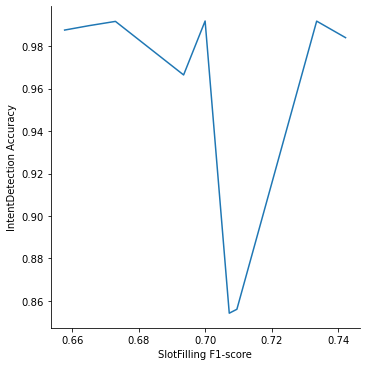

In [17]:
sns.relplot(data=tmp, x=('test_f1', 'slot'), y=('test_acc', 'intent'), kind='line')
plt.xlabel('SlotFilling F1-score')
plt.ylabel('IntentDetection Accuracy')
plt.savefig('plots/intent_and_slot_acc_atis.pdf', bbox_inches='tight')

In [18]:
tmp = history.copy()

tmp['target'] = tmp['model'].apply(lambda x: x.rsplit('_', 1)[-1])
tmp['alpha'] = tmp['model'].apply(lambda x: x.split('_')[0].split('=')[1])

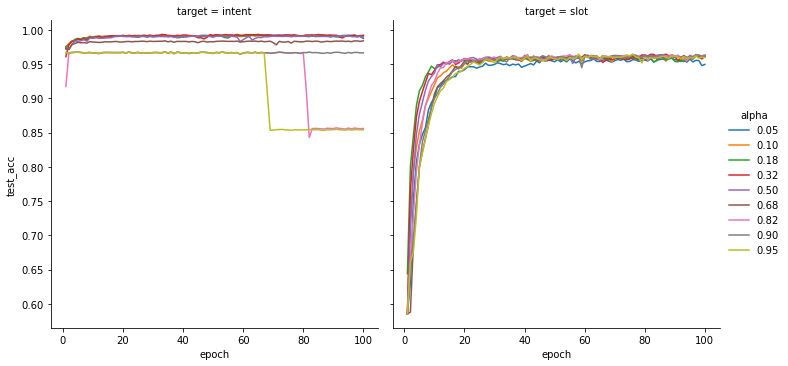

In [19]:
sns.relplot(data=tmp, x='epoch', y='test_acc', hue='alpha', col='target', kind='line')

# Token intent

In [27]:
class Net(nn.Module):
    def __init__(self, input_size, num_intent, hidden_size=50, lstm_layers=4):
        super(Net, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers 
        )
        
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * 2, num_intent),
#             nn.ReLU(),
            
#             nn.Linear(100, 200),
#             nn.ReLU(),
            
#             nn.Linear(200, num_intent)
        )
    
    def forward(self, X):
        X_lstm = self.__lstm(X)
        y = self.__fc(X_lstm[0])
        return y

In [28]:
net = Net(768, N_INTENT).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-6)

In [29]:
def eval_net(net):
    net.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct, total = 0, 0
        for inputs in d.test:
            text, intent, slot = inputs
            X, _ = d.encode(text)
            token_intent = torch.tile(intent.unsqueeze(1), [1, X.shape[1]]).to(device)
            slot = d.pad_slot(slot)

            y_intent = net(X)

            loss = criterion(y_intent.transpose(1, 2), token_intent)

            test_loss += loss.item()

            correct += (torch.mode(y_intent.argmax(axis=-1)).values.cpu() == intent).sum().item()
            total += intent.shape[0]

        print(f'Test loss: {test_loss / len(d.test):.4f}')
        print(f'Test acc: {correct / total:.4f}')
    net.train()
    return test_loss / len(d.test), correct / total

In [30]:
net.train()
history = defaultdict(list)
for i in trange(N_EPOCH):
    train_loss = 0.0
    correct, total = 0, 0
    for inputs in tqdm(d.train):
        text, intent, slot = inputs
        X, _ = d.encode(text)
        token_intent = torch.tile(intent.unsqueeze(1), [1, X.shape[1]]).to(device)
        slot = d.pad_slot(slot)
        
        y_intent = net(X)
        
        optimizer.zero_grad()
        loss = criterion(y_intent.transpose(1, 2), token_intent)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        correct += (torch.mode(y_intent.argmax(axis=-1)).values.cpu() == intent).sum().item()
        total += intent.shape[0]
    
    print(f'Epoch {i + 1} / {N_EPOCH}')
    print(f'Train loss: {train_loss / len(d.train):.4f}')
    print(f'Train acc: {correct / total:.4f}')
    
    test_loss, test_acc = eval_net(net)
    
    history['epoch'].append(i + 1)
    history['train_loss'].append(train_loss / len(d.train))
    history['train_acc'].append(correct / total)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 / 30
Train loss: 1.5526
Train acc: 0.5505
Test loss: 1.0392
Test acc: 0.6971


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 / 30
Train loss: 0.8126
Train acc: 0.8137
Test loss: 0.6449
Test acc: 0.8214


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 / 30
Train loss: 0.5659
Train acc: 0.8685
Test loss: 0.5463
Test acc: 0.8429


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 / 30
Train loss: 0.4543
Train acc: 0.8923
Test loss: 0.4250
Test acc: 0.8686


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 / 30
Train loss: 0.3875
Train acc: 0.9064
Test loss: 0.4314
Test acc: 0.8786


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 / 30
Train loss: 0.3452
Train acc: 0.9173
Test loss: 0.3384
Test acc: 0.9071


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 / 30
Train loss: 0.3090
Train acc: 0.9253
Test loss: 0.3670
Test acc: 0.8886


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 / 30
Train loss: 0.2876
Train acc: 0.9293
Test loss: 0.3179
Test acc: 0.9100


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9 / 30
Train loss: 0.2732
Train acc: 0.9334
Test loss: 0.3237
Test acc: 0.9043


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 / 30
Train loss: 0.2575
Train acc: 0.9379
Test loss: 0.2981
Test acc: 0.9086


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 / 30
Train loss: 0.2453
Train acc: 0.9411
Test loss: 0.3238
Test acc: 0.9057


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 / 30
Train loss: 0.2342
Train acc: 0.9432
Test loss: 0.3095
Test acc: 0.9157


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 / 30
Train loss: 0.2264
Train acc: 0.9456
Test loss: 0.3103
Test acc: 0.9043


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 / 30
Train loss: 0.2136
Train acc: 0.9487
Test loss: 0.2840
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 / 30
Train loss: 0.2062
Train acc: 0.9513
Test loss: 0.2993
Test acc: 0.9100


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 / 30
Train loss: 0.2044
Train acc: 0.9534
Test loss: 0.2963
Test acc: 0.9157


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 / 30
Train loss: 0.1921
Train acc: 0.9539
Test loss: 0.2842
Test acc: 0.9157


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 / 30
Train loss: 0.1875
Train acc: 0.9531
Test loss: 0.2868
Test acc: 0.9214


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19 / 30
Train loss: 0.1855
Train acc: 0.9569
Test loss: 0.2848
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 / 30
Train loss: 0.1747
Train acc: 0.9567
Test loss: 0.2719
Test acc: 0.9200


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 / 30
Train loss: 0.1701
Train acc: 0.9591
Test loss: 0.2766
Test acc: 0.9243


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 / 30
Train loss: 0.1662
Train acc: 0.9590
Test loss: 0.2807
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 / 30
Train loss: 0.1607
Train acc: 0.9604
Test loss: 0.2718
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 / 30
Train loss: 0.1600
Train acc: 0.9615
Test loss: 0.2773
Test acc: 0.9171


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 / 30
Train loss: 0.1490
Train acc: 0.9637
Test loss: 0.2648
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 / 30
Train loss: 0.1521
Train acc: 0.9638
Test loss: 0.2636
Test acc: 0.9186


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 / 30
Train loss: 0.1477
Train acc: 0.9655
Test loss: 0.2740
Test acc: 0.9229


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28 / 30
Train loss: 0.1432
Train acc: 0.9653
Test loss: 0.2780
Test acc: 0.9171


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29 / 30
Train loss: 0.1405
Train acc: 0.9665
Test loss: 0.2813
Test acc: 0.9157


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 / 30
Train loss: 0.1367
Train acc: 0.9677
Test loss: 0.2710
Test acc: 0.9200


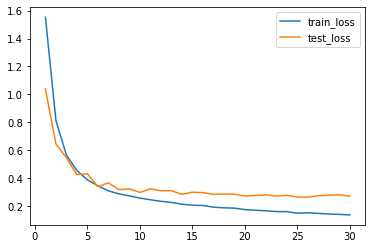

In [31]:
plt.plot(history['epoch'], history['train_loss'], label='train_loss')
plt.plot(history['epoch'], history['test_loss'], label='test_loss')
plt.legend()

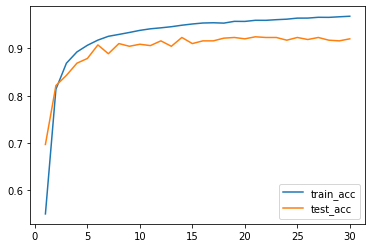

In [32]:
plt.plot(history['epoch'], history['train_acc'], label='train_acc')
plt.plot(history['epoch'], history['test_acc'], label='test_acc')
plt.legend()

In [34]:
net = Net(768, N_INTENT).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = Adam(net.parameters())

C:\Users\rusla\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [35]:
net.train()
for i in trange(N_EPOCH):
    train_loss = 0.0
    correct, total = 0, 0
    for inputs in tqdm(d.train):
        text, intent, slot = inputs
        X, _ = d.encode(text)
        slot = d.pad_slot(slot)
        token_intent = torch.tile(intent.unsqueeze(1), [1, X.shape[1]]).to(device)
        token_intent[slot > 0] = -1
        
        y_intent = net(X)
        
        optimizer.zero_grad()
        loss = criterion(y_intent.transpose(1, 2), token_intent)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        correct += (torch.mode(y_intent.argmax(axis=-1)).values.cpu() == intent).sum().item()
        total += intent.shape[0]
    
    print(f'Epoch {i + 1} / {N_EPOCH}')
    print(f'Train loss: {train_loss / len(d.train):.4f}')
    print(f'Acc: {correct / total:.4f}')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 1 / 50
Train loss: 1.0052
Acc: 0.6751


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2 / 50
Train loss: 0.2614
Acc: 0.9356


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3 / 50
Train loss: 0.1651
Acc: 0.9600


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4 / 50
Train loss: 0.1161
Acc: 0.9723


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5 / 50
Train loss: 0.0824
Acc: 0.9803


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6 / 50
Train loss: 0.0600
Acc: 0.9875


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7 / 50
Train loss: 0.0457
Acc: 0.9904


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8 / 50
Train loss: 0.0357
Acc: 0.9937


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9 / 50
Train loss: 0.0411
Acc: 0.9911


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10 / 50
Train loss: 0.0214
Acc: 0.9965


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11 / 50
Train loss: 0.0148
Acc: 0.9977


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12 / 50
Train loss: 0.0099
Acc: 0.9989


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13 / 50
Train loss: 0.0501
Acc: 0.9921


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14 / 50
Train loss: 0.0091
Acc: 0.9991


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15 / 50
Train loss: 0.0054
Acc: 0.9996


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16 / 50
Train loss: 0.0038
Acc: 0.9995


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17 / 50
Train loss: 0.0029
Acc: 0.9997


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18 / 50
Train loss: 0.0022
Acc: 0.9998


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19 / 50
Train loss: 0.0020
Acc: 0.9999


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20 / 50
Train loss: 0.0154
Acc: 0.9979


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21 / 50
Train loss: 0.0024
Acc: 0.9998


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22 / 50
Train loss: 0.0015
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23 / 50
Train loss: 0.0019
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24 / 50
Train loss: 0.0015
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25 / 50
Train loss: 0.0010
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26 / 50
Train loss: 0.0010
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27 / 50
Train loss: 0.0008
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28 / 50
Train loss: 0.0008
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29 / 50
Train loss: 0.0009
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30 / 50
Train loss: 0.0007
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 31 / 50
Train loss: 0.0006
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 32 / 50
Train loss: 0.0005
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 33 / 50
Train loss: 0.0005
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 34 / 50
Train loss: 0.0004
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 35 / 50
Train loss: 0.0006
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 36 / 50
Train loss: 0.0005
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 37 / 50
Train loss: 0.0004
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 38 / 50
Train loss: 0.0004
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 39 / 50
Train loss: 0.0021
Acc: 0.9999


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 40 / 50
Train loss: 0.0083
Acc: 0.9991


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 41 / 50
Train loss: 0.0161
Acc: 0.9979


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 42 / 50
Train loss: 0.0018
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 43 / 50
Train loss: 0.0011
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 44 / 50
Train loss: 0.0009
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 45 / 50
Train loss: 0.0006
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 46 / 50
Train loss: 0.0007
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 47 / 50
Train loss: 0.0006
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 48 / 50
Train loss: 0.0006
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 49 / 50
Train loss: 0.0005
Acc: 1.0000


  0%|          | 0/52 [00:00<?, ?it/s]

Epoch 50 / 50
Train loss: 0.0005
Acc: 1.0000


In [36]:
net.eval()
with torch.no_grad():
    test_loss = 0.0
    correct, total = 0, 0
    for inputs in tqdm(d.test):
        text, intent, slot = inputs
        X, _ = d.encode(text)
        token_intent = torch.tile(intent.unsqueeze(1), [1, X.shape[1]]).to(device)
        slot = d.pad_slot(slot)
        
        y_intent = net(X)
        
        loss = criterion(y_intent.transpose(1, 2), token_intent)

        test_loss += loss.item()
        
        correct += (torch.mode(y_intent.argmax(axis=-1)).values.cpu() == intent).sum().item()
        total += intent.shape[0]
    
    print(f'Test loss: {test_loss / len(d.test):.4f}')
    print(f'Acc: {correct / total:.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]

Test loss: 0.4392
Acc: 0.9529


# Сравнение импакта от информации о другой задаче

In [20]:
d = DatasetManager('./data/atis_snips/atis/', batch_size=256, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
class SlotNet(nn.Module):
    def __init__(self, input_size, num_slots, hidden_size=200, lstm_layers=4):
        super(SlotNet, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers 
        )
        
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * 2, num_slots)
        )
        
    def forward(self, X):
        X_lstm = self.__lstm(X)
        y = self.__fc(X_lstm[0])
        return y

In [34]:
class SlotStep(BaseStep):
    def forward(self, X, slot, intent):
        y_slot = self.net(X)
        loss = self.slot_criterion(y_slot.transpose(1, 2), slot.to(device))
        
        y_slot = y_slot.argmax(axis=-1)
        
        acc = accuracy(slot, y_slot)
        f1 = f1_score(
            y_true=slot.cpu().flatten(),
            y_pred=y_slot.cpu().flatten(), 
            labels=range(N_SLOT), average='macro',
            zero_division=1
        )
        
        return loss, acc, f1

In [35]:
class SlotWithIntentInfoStep(BaseStep):
    def forward(self, X, slot, intent):
        intent = (
            intent
            .unsqueeze(1)
            .tile((1, X.shape[1], 1))
        )

        X = torch.cat((X, intent.to(device)), dim=-1)
        y_slot = self.net(X)
        loss = self.slot_criterion(y_slot.transpose(1, 2), slot.to(device))
        
        y_slot = y_slot.argmax(axis=-1)
        
        acc = accuracy(slot, y_slot)
        f1 = f1_score(
            y_true=slot.cpu().flatten(),
            y_pred=y_slot.cpu().flatten(), 
            labels=range(N_SLOT), average='macro',
            zero_division=1
        )
        
        return loss, acc, f1

In [36]:
class IntentNet(nn.Module):
    def __init__(self, input_size, num_intent, hidden_size=200, lstm_layers=4):
        super(IntentNet, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers        
        )
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * lstm_layers * 4, num_intent),
            nn.Sigmoid()
        )
    
    def forward(self, X):
        X_lstm = self.__lstm(X)
        return self.__fc(torch.cat(X_lstm[1]).transpose(0, 1).reshape(X.shape[0], -1))

In [29]:
class IntentStep(BaseStep):
    def forward(self, X, slot, intent):
        y_intent = self.net(X)
        loss = self.intent_criterion(y_intent, intent.to(device))
        
        y_intent = (y_intent > 0.5).float()
        
        acc = accuracy(intent, y_intent)
        f1 = f1_score(intent.cpu(), y_intent.cpu(), average='macro', zero_division=1)
        
        return loss, acc, f1

In [37]:
class IntentWithSlotInfoStep(BaseStep):
    def forward(self, X, slot, intent):
        slot = (slot.unsqueeze(2) == torch.arange(len(d.slot_enc)).to(device))
        X = torch.cat((X, slot), dim=-1)
        
        y_intent = self.net(X)
        loss = self.intent_criterion(y_intent, intent.to(device))
        
        y_intent = (y_intent > 0.5).float()
        
        acc = accuracy(intent, y_intent)
        f1 = f1_score(intent.cpu(), y_intent.cpu(), average='macro', zero_division=1)
        
        return loss, acc, f1

In [38]:
steppers = dict()

torch.manual_seed(seed)
net = SlotNet(768, len(d.slot_enc), 200, 2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)

steppers['slot_without_intent_info'] = SlotStep(net, criterion, optimizer)

torch.manual_seed(seed)
net = SlotNet(768 + N_INTENT, len(d.slot_enc), 200, 2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)

steppers['slot_with_intent_info'] = SlotWithIntentInfoStep(net, criterion, optimizer)

torch.manual_seed(seed)
net = IntentNet(768, N_INTENT, 200, 2).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)

steppers['intent_without_slot_info'] = IntentStep(net, criterion, optimizer)

torch.manual_seed(seed)
net = IntentNet(768 + len(d.slot_enc), N_INTENT, 200, 2).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)

steppers['intent_with_slot_info'] = IntentWithSlotInfoStep(net, criterion, optimizer)

In [39]:
history = train(steppers, N_EPOCH)
history.to_csv('history/additional_info_atis.csv', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1 / 100
------------------
slot_without_intent_info
Train loss: 2.1337
Train acc: 0.5917
Train f1: 0.3252
Test loss: 2.0181
Test acc: 0.5891
Test f1: 0.3699
------------------
slot_with_intent_info
Train loss: 2.1380
Train acc: 0.5944
Train f1: 0.3275
Test loss: 1.9897
Test acc: 0.5891
Test f1: 0.3699
------------------
intent_without_slot_info
Train loss: 0.3557
Train acc: 0.9068
Train f1: 0.3050
Test loss: 0.1902
Test acc: 0.9602
Test f1: 0.3849
------------------
intent_with_slot_info
Train loss: 0.4076
Train acc: 0.8925
Train f1: 0.3048
Test loss: 0.2117
Test acc: 0.9667
Test f1: 0.3219


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2 / 100
------------------
slot_without_intent_info
Train loss: 1.7322
Train acc: 0.6299
Train f1: 0.3508
Test loss: 1.6223
Test acc: 0.5869
Test f1: 0.3764
------------------
slot_with_intent_info
Train loss: 1.6067
Train acc: 0.6443
Train f1: 0.3520
Test loss: 1.5117
Test acc: 0.7021
Test f1: 0.3821
------------------
intent_without_slot_info
Train loss: 0.0995
Train acc: 0.9763
Train f1: 0.4246
Test loss: 0.0919
Test acc: 0.9798
Test f1: 0.3892
------------------
intent_with_slot_info
Train loss: 0.1377
Train acc: 0.9690
Train f1: 0.3838
Test loss: 0.1313
Test acc: 0.9746
Test f1: 0.3535


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3 / 100
------------------
slot_without_intent_info
Train loss: 1.2238
Train acc: 0.7160
Train f1: 0.3535
Test loss: 1.1940
Test acc: 0.7211
Test f1: 0.3983
------------------
slot_with_intent_info
Train loss: 1.2347
Train acc: 0.7325
Train f1: 0.3536
Test loss: 1.2753
Test acc: 0.7183
Test f1: 0.3938
------------------
intent_without_slot_info
Train loss: 0.0557
Train acc: 0.9843
Train f1: 0.4540
Test loss: 0.0741
Test acc: 0.9828
Test f1: 0.3964
------------------
intent_with_slot_info
Train loss: 0.0682
Train acc: 0.9807
Train f1: 0.4383
Test loss: 0.0720
Test acc: 0.9814
Test f1: 0.3611


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4 / 100
------------------
slot_without_intent_info
Train loss: 0.9544
Train acc: 0.7771
Train f1: 0.3656
Test loss: 1.0155
Test acc: 0.7671
Test f1: 0.3858
------------------
slot_with_intent_info
Train loss: 1.0131
Train acc: 0.7626
Train f1: 0.3608
Test loss: 1.0581
Test acc: 0.7560
Test f1: 0.3797
------------------
intent_without_slot_info
Train loss: 0.0386
Train acc: 0.9883
Train f1: 0.5094
Test loss: 0.0551
Test acc: 0.9846
Test f1: 0.4692
------------------
intent_with_slot_info
Train loss: 0.0467
Train acc: 0.9858
Train f1: 0.4646
Test loss: 0.0601
Test acc: 0.9837
Test f1: 0.4296


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5 / 100
------------------
slot_without_intent_info
Train loss: 0.8191
Train acc: 0.7998
Train f1: 0.3704
Test loss: 0.8611
Test acc: 0.8015
Test f1: 0.4153
------------------
slot_with_intent_info
Train loss: 0.8453
Train acc: 0.8035
Train f1: 0.3723
Test loss: 0.9144
Test acc: 0.7879
Test f1: 0.4092
------------------
intent_without_slot_info
Train loss: 0.0291
Train acc: 0.9909
Train f1: 0.5648
Test loss: 0.0514
Test acc: 0.9861
Test f1: 0.4542
------------------
intent_with_slot_info
Train loss: 0.0363
Train acc: 0.9886
Train f1: 0.5233
Test loss: 0.0555
Test acc: 0.9851
Test f1: 0.4389


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6 / 100
------------------
slot_without_intent_info
Train loss: 0.6942
Train acc: 0.8322
Train f1: 0.3905
Test loss: 0.7441
Test acc: 0.8292
Test f1: 0.4207
------------------
slot_with_intent_info
Train loss: 0.7368
Train acc: 0.8248
Train f1: 0.3904
Test loss: 0.8283
Test acc: 0.8082
Test f1: 0.4274
------------------
intent_without_slot_info
Train loss: 0.0239
Train acc: 0.9921
Train f1: 0.6024
Test loss: 0.0420
Test acc: 0.9877
Test f1: 0.5606
------------------
intent_with_slot_info
Train loss: 0.0291
Train acc: 0.9907
Train f1: 0.5985
Test loss: 0.0481
Test acc: 0.9849
Test f1: 0.4987


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7 / 100
------------------
slot_without_intent_info
Train loss: 0.5911
Train acc: 0.8579
Train f1: 0.4189
Test loss: 0.6416
Test acc: 0.8463
Test f1: 0.4622
------------------
slot_with_intent_info
Train loss: 0.6415
Train acc: 0.8462
Train f1: 0.4129
Test loss: 0.7246
Test acc: 0.8229
Test f1: 0.4534
------------------
intent_without_slot_info
Train loss: 0.0186
Train acc: 0.9939
Train f1: 0.6562
Test loss: 0.0446
Test acc: 0.9872
Test f1: 0.4893
------------------
intent_with_slot_info
Train loss: 0.0237
Train acc: 0.9925
Train f1: 0.6328
Test loss: 0.0485
Test acc: 0.9862
Test f1: 0.4943


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8 / 100
------------------
slot_without_intent_info
Train loss: 0.5013
Train acc: 0.8816
Train f1: 0.4594
Test loss: 0.5408
Test acc: 0.8728
Test f1: 0.4770
------------------
slot_with_intent_info
Train loss: 0.5447
Train acc: 0.8713
Train f1: 0.4557
Test loss: 0.6190
Test acc: 0.8530
Test f1: 0.4743
------------------
intent_without_slot_info
Train loss: 0.0147
Train acc: 0.9952
Train f1: 0.6950
Test loss: 0.0401
Test acc: 0.9883
Test f1: 0.5268
------------------
intent_with_slot_info
Train loss: 0.0183
Train acc: 0.9940
Train f1: 0.6712
Test loss: 0.0422
Test acc: 0.9866
Test f1: 0.5100


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9 / 100
------------------
slot_without_intent_info
Train loss: 0.4265
Train acc: 0.8943
Train f1: 0.4645
Test loss: 0.4674
Test acc: 0.8838
Test f1: 0.4726
------------------
slot_with_intent_info
Train loss: 0.4579
Train acc: 0.8889
Train f1: 0.4773
Test loss: 0.5155
Test acc: 0.8680
Test f1: 0.4767
------------------
intent_without_slot_info
Train loss: 0.0123
Train acc: 0.9958
Train f1: 0.7504
Test loss: 0.0413
Test acc: 0.9893
Test f1: 0.5855
------------------
intent_with_slot_info
Train loss: 0.0149
Train acc: 0.9953
Train f1: 0.7350
Test loss: 0.0445
Test acc: 0.9880
Test f1: 0.5428


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10 / 100
------------------
slot_without_intent_info
Train loss: 0.3596
Train acc: 0.9076
Train f1: 0.4907
Test loss: 0.3983
Test acc: 0.8950
Test f1: 0.5128
------------------
slot_with_intent_info
Train loss: 0.3892
Train acc: 0.9014
Train f1: 0.5011
Test loss: 0.4454
Test acc: 0.8847
Test f1: 0.5335
------------------
intent_without_slot_info
Train loss: 0.0095
Train acc: 0.9969
Train f1: 0.7837
Test loss: 0.0422
Test acc: 0.9885
Test f1: 0.5784
------------------
intent_with_slot_info
Train loss: 0.0115
Train acc: 0.9963
Train f1: 0.7645
Test loss: 0.0448
Test acc: 0.9884
Test f1: 0.5865


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11 / 100
------------------
slot_without_intent_info
Train loss: 0.3091
Train acc: 0.9194
Train f1: 0.5021
Test loss: 0.3716
Test acc: 0.9008
Test f1: 0.5256
------------------
slot_with_intent_info
Train loss: 0.3345
Train acc: 0.9134
Train f1: 0.5045
Test loss: 0.4085
Test acc: 0.8944
Test f1: 0.5255
------------------
intent_without_slot_info
Train loss: 0.0080
Train acc: 0.9972
Train f1: 0.8037
Test loss: 0.0371
Test acc: 0.9896
Test f1: 0.5658
------------------
intent_with_slot_info
Train loss: 0.0095
Train acc: 0.9970
Train f1: 0.8098
Test loss: 0.0440
Test acc: 0.9885
Test f1: 0.5810


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12 / 100
------------------
slot_without_intent_info
Train loss: 0.2724
Train acc: 0.9291
Train f1: 0.5293
Test loss: 0.3451
Test acc: 0.9099
Test f1: 0.5325
------------------
slot_with_intent_info
Train loss: 0.2916
Train acc: 0.9243
Train f1: 0.5238
Test loss: 0.3713
Test acc: 0.9066
Test f1: 0.5582
------------------
intent_without_slot_info
Train loss: 0.0061
Train acc: 0.9984
Train f1: 0.8958
Test loss: 0.0371
Test acc: 0.9904
Test f1: 0.6744
------------------
intent_with_slot_info
Train loss: 0.0077
Train acc: 0.9977
Train f1: 0.8362
Test loss: 0.0387
Test acc: 0.9887
Test f1: 0.6484


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13 / 100
------------------
slot_without_intent_info
Train loss: 0.2385
Train acc: 0.9378
Train f1: 0.5689
Test loss: 0.3261
Test acc: 0.9170
Test f1: 0.5645
------------------
slot_with_intent_info
Train loss: 0.2549
Train acc: 0.9335
Train f1: 0.5547
Test loss: 0.3440
Test acc: 0.9146
Test f1: 0.5696
------------------
intent_without_slot_info
Train loss: 0.0056
Train acc: 0.9985
Train f1: 0.9265
Test loss: 0.0394
Test acc: 0.9894
Test f1: 0.5898
------------------
intent_with_slot_info
Train loss: 0.0061
Train acc: 0.9981
Train f1: 0.8868
Test loss: 0.0387
Test acc: 0.9897
Test f1: 0.5993


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14 / 100
------------------
slot_without_intent_info
Train loss: 0.2117
Train acc: 0.9431
Train f1: 0.5769
Test loss: 0.3023
Test acc: 0.9204
Test f1: 0.6153
------------------
slot_with_intent_info
Train loss: 0.2241
Train acc: 0.9407
Train f1: 0.5814
Test loss: 0.3161
Test acc: 0.9224
Test f1: 0.6253
------------------
intent_without_slot_info
Train loss: 0.0040
Train acc: 0.9987
Train f1: 0.9381
Test loss: 0.0448
Test acc: 0.9887
Test f1: 0.6479
------------------
intent_with_slot_info
Train loss: 0.0045
Train acc: 0.9987
Train f1: 0.8861
Test loss: 0.0422
Test acc: 0.9892
Test f1: 0.6843


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15 / 100
------------------
slot_without_intent_info
Train loss: 0.1913
Train acc: 0.9469
Train f1: 0.6053
Test loss: 0.2721
Test acc: 0.9290
Test f1: 0.6229
------------------
slot_with_intent_info
Train loss: 0.1994
Train acc: 0.9464
Train f1: 0.6016
Test loss: 0.3016
Test acc: 0.9207
Test f1: 0.5863
------------------
intent_without_slot_info
Train loss: 0.0031
Train acc: 0.9991
Train f1: 0.9484
Test loss: 0.0475
Test acc: 0.9896
Test f1: 0.6377
------------------
intent_with_slot_info
Train loss: 0.0031
Train acc: 0.9992
Train f1: 0.9339
Test loss: 0.0432
Test acc: 0.9900
Test f1: 0.6724


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16 / 100
------------------
slot_without_intent_info
Train loss: 0.1708
Train acc: 0.9534
Train f1: 0.6332
Test loss: 0.2759
Test acc: 0.9288
Test f1: 0.6141
------------------
slot_with_intent_info
Train loss: 0.1803
Train acc: 0.9506
Train f1: 0.6147
Test loss: 0.2838
Test acc: 0.9291
Test f1: 0.6277
------------------
intent_without_slot_info
Train loss: 0.0022
Train acc: 0.9996
Train f1: 0.9802
Test loss: 0.0404
Test acc: 0.9902
Test f1: 0.6566
------------------
intent_with_slot_info
Train loss: 0.0025
Train acc: 0.9995
Train f1: 0.9527
Test loss: 0.0441
Test acc: 0.9897
Test f1: 0.6687


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17 / 100
------------------
slot_without_intent_info
Train loss: 0.1528
Train acc: 0.9588
Train f1: 0.6510
Test loss: 0.2629
Test acc: 0.9342
Test f1: 0.6479
------------------
slot_with_intent_info
Train loss: 0.1631
Train acc: 0.9556
Train f1: 0.6396
Test loss: 0.2845
Test acc: 0.9295
Test f1: 0.6246
------------------
intent_without_slot_info
Train loss: 0.0017
Train acc: 0.9997
Train f1: 0.9784
Test loss: 0.0423
Test acc: 0.9901
Test f1: 0.6168
------------------
intent_with_slot_info
Train loss: 0.0021
Train acc: 0.9995
Train f1: 0.9684
Test loss: 0.0490
Test acc: 0.9898
Test f1: 0.6605


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18 / 100
------------------
slot_without_intent_info
Train loss: 0.1374
Train acc: 0.9641
Train f1: 0.6640
Test loss: 0.2731
Test acc: 0.9343
Test f1: 0.6558
------------------
slot_with_intent_info
Train loss: 0.1475
Train acc: 0.9604
Train f1: 0.6594
Test loss: 0.2736
Test acc: 0.9309
Test f1: 0.6488
------------------
intent_without_slot_info
Train loss: 0.0013
Train acc: 0.9998
Train f1: 0.9904
Test loss: 0.0409
Test acc: 0.9905
Test f1: 0.6703
------------------
intent_with_slot_info
Train loss: 0.0018
Train acc: 0.9997
Train f1: 0.9731
Test loss: 0.0452
Test acc: 0.9898
Test f1: 0.6659


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19 / 100
------------------
slot_without_intent_info
Train loss: 0.1233
Train acc: 0.9686
Train f1: 0.6939
Test loss: 0.2382
Test acc: 0.9435
Test f1: 0.6773
------------------
slot_with_intent_info
Train loss: 0.1344
Train acc: 0.9653
Train f1: 0.6690
Test loss: 0.2592
Test acc: 0.9369
Test f1: 0.6984
------------------
intent_without_slot_info
Train loss: 0.0011
Train acc: 0.9999
Train f1: 0.9956
Test loss: 0.0393
Test acc: 0.9900
Test f1: 0.6678
------------------
intent_with_slot_info
Train loss: 0.0015
Train acc: 0.9997
Train f1: 0.9859
Test loss: 0.0389
Test acc: 0.9912
Test f1: 0.7277


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20 / 100
------------------
slot_without_intent_info
Train loss: 0.1085
Train acc: 0.9728
Train f1: 0.7030
Test loss: 0.2320
Test acc: 0.9447
Test f1: 0.6968
------------------
slot_with_intent_info
Train loss: 0.1195
Train acc: 0.9697
Train f1: 0.6783
Test loss: 0.2399
Test acc: 0.9429
Test f1: 0.7103
------------------
intent_without_slot_info
Train loss: 0.0009
Train acc: 0.9999
Train f1: 0.9951
Test loss: 0.0453
Test acc: 0.9904
Test f1: 0.6376
------------------
intent_with_slot_info
Train loss: 0.0010
Train acc: 0.9999
Train f1: 0.9933
Test loss: 0.0456
Test acc: 0.9899
Test f1: 0.6451


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21 / 100
------------------
slot_without_intent_info
Train loss: 0.1008
Train acc: 0.9740
Train f1: 0.7014
Test loss: 0.2183
Test acc: 0.9471
Test f1: 0.6826
------------------
slot_with_intent_info
Train loss: 0.1067
Train acc: 0.9725
Train f1: 0.6966
Test loss: 0.2337
Test acc: 0.9440
Test f1: 0.6852
------------------
intent_without_slot_info
Train loss: 0.0007
Train acc: 1.0000
Train f1: 0.9960
Test loss: 0.0427
Test acc: 0.9905
Test f1: 0.6779
------------------
intent_with_slot_info
Train loss: 0.0008
Train acc: 1.0000
Train f1: 0.9996
Test loss: 0.0480
Test acc: 0.9901
Test f1: 0.6500


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22 / 100
------------------
slot_without_intent_info
Train loss: 0.0907
Train acc: 0.9772
Train f1: 0.7225
Test loss: 0.2226
Test acc: 0.9467
Test f1: 0.6783
------------------
slot_with_intent_info
Train loss: 0.0964
Train acc: 0.9757
Train f1: 0.7026
Test loss: 0.2557
Test acc: 0.9360
Test f1: 0.6311
------------------
intent_without_slot_info
Train loss: 0.0007
Train acc: 0.9999
Train f1: 0.9996
Test loss: 0.0406
Test acc: 0.9905
Test f1: 0.6169
------------------
intent_with_slot_info
Train loss: 0.0007
Train acc: 0.9999
Train f1: 0.9999
Test loss: 0.0486
Test acc: 0.9900
Test f1: 0.6421


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23 / 100
------------------
slot_without_intent_info
Train loss: 0.0818
Train acc: 0.9793
Train f1: 0.7359
Test loss: 0.2054
Test acc: 0.9509
Test f1: 0.6874
------------------
slot_with_intent_info
Train loss: 0.0915
Train acc: 0.9760
Train f1: 0.7124
Test loss: 0.2190
Test acc: 0.9470
Test f1: 0.6919
------------------
intent_without_slot_info
Train loss: 0.0005
Train acc: 1.0000
Train f1: 0.9989
Test loss: 0.0472
Test acc: 0.9901
Test f1: 0.7312
------------------
intent_with_slot_info
Train loss: 0.0005
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0493
Test acc: 0.9905
Test f1: 0.7168


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24 / 100
------------------
slot_without_intent_info
Train loss: 0.0732
Train acc: 0.9817
Train f1: 0.7422
Test loss: 0.2117
Test acc: 0.9517
Test f1: 0.6896
------------------
slot_with_intent_info
Train loss: 0.0814
Train acc: 0.9796
Train f1: 0.7188
Test loss: 0.2063
Test acc: 0.9525
Test f1: 0.6633
------------------
intent_without_slot_info
Train loss: 0.0004
Train acc: 1.0000
Train f1: 0.9963
Test loss: 0.0439
Test acc: 0.9906
Test f1: 0.6741
------------------
intent_with_slot_info
Train loss: 0.0004
Train acc: 1.0000
Train f1: 0.9965
Test loss: 0.0487
Test acc: 0.9896
Test f1: 0.6564


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25 / 100
------------------
slot_without_intent_info
Train loss: 0.0662
Train acc: 0.9838
Train f1: 0.7392
Test loss: 0.2147
Test acc: 0.9531
Test f1: 0.7033
------------------
slot_with_intent_info
Train loss: 0.0724
Train acc: 0.9821
Train f1: 0.7233
Test loss: 0.2306
Test acc: 0.9468
Test f1: 0.6565
------------------
intent_without_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0480
Test acc: 0.9902
Test f1: 0.6764
------------------
intent_with_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0523
Test acc: 0.9900
Test f1: 0.6646


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26 / 100
------------------
slot_without_intent_info
Train loss: 0.0625
Train acc: 0.9846
Train f1: 0.7532
Test loss: 0.2168
Test acc: 0.9544
Test f1: 0.7280
------------------
slot_with_intent_info
Train loss: 0.0693
Train acc: 0.9824
Train f1: 0.7385
Test loss: 0.2420
Test acc: 0.9467
Test f1: 0.7360
------------------
intent_without_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0420
Test acc: 0.9910
Test f1: 0.6573
------------------
intent_with_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0460
Test acc: 0.9905
Test f1: 0.6574


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27 / 100
------------------
slot_without_intent_info
Train loss: 0.0562
Train acc: 0.9864
Train f1: 0.7527
Test loss: 0.1902
Test acc: 0.9577
Test f1: 0.7191
------------------
slot_with_intent_info
Train loss: 0.0660
Train acc: 0.9840
Train f1: 0.7527
Test loss: 0.2078
Test acc: 0.9529
Test f1: 0.7356
------------------
intent_without_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0466
Test acc: 0.9905
Test f1: 0.6833
------------------
intent_with_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0490
Test acc: 0.9902
Test f1: 0.7039


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28 / 100
------------------
slot_without_intent_info
Train loss: 0.0527
Train acc: 0.9867
Train f1: 0.7616
Test loss: 0.1906
Test acc: 0.9588
Test f1: 0.7470
------------------
slot_with_intent_info
Train loss: 0.0574
Train acc: 0.9856
Train f1: 0.7411
Test loss: 0.2006
Test acc: 0.9554
Test f1: 0.6717
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0489
Test acc: 0.9905
Test f1: 0.6167
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0535
Test acc: 0.9903
Test f1: 0.6401


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29 / 100
------------------
slot_without_intent_info
Train loss: 0.0489
Train acc: 0.9878
Train f1: 0.7653
Test loss: 0.2132
Test acc: 0.9555
Test f1: 0.6932
------------------
slot_with_intent_info
Train loss: 0.0530
Train acc: 0.9873
Train f1: 0.7335
Test loss: 0.2001
Test acc: 0.9565
Test f1: 0.6951
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0474
Test acc: 0.9908
Test f1: 0.6480
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0528
Test acc: 0.9901
Test f1: 0.6776


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30 / 100
------------------
slot_without_intent_info
Train loss: 0.0418
Train acc: 0.9900
Train f1: 0.7864
Test loss: 0.1955
Test acc: 0.9584
Test f1: 0.7176
------------------
slot_with_intent_info
Train loss: 0.0542
Train acc: 0.9862
Train f1: 0.7677
Test loss: 0.2145
Test acc: 0.9520
Test f1: 0.7218
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0457
Test acc: 0.9903
Test f1: 0.6757
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0502
Test acc: 0.9901
Test f1: 0.6568


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31 / 100
------------------
slot_without_intent_info
Train loss: 0.0383
Train acc: 0.9908
Train f1: 0.7603
Test loss: 0.2247
Test acc: 0.9552
Test f1: 0.7026
------------------
slot_with_intent_info
Train loss: 0.0464
Train acc: 0.9886
Train f1: 0.7698
Test loss: 0.2278
Test acc: 0.9528
Test f1: 0.7189
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0508
Test acc: 0.9908
Test f1: 0.6393
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0556
Test acc: 0.9904
Test f1: 0.6507


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32 / 100
------------------
slot_without_intent_info
Train loss: 0.0356
Train acc: 0.9916
Train f1: 0.7655
Test loss: 0.2192
Test acc: 0.9539
Test f1: 0.7132
------------------
slot_with_intent_info
Train loss: 0.0439
Train acc: 0.9891
Train f1: 0.7549
Test loss: 0.2100
Test acc: 0.9558
Test f1: 0.6637
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0472
Test acc: 0.9908
Test f1: 0.6624
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0516
Test acc: 0.9904
Test f1: 0.6613


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33 / 100
------------------
slot_without_intent_info
Train loss: 0.0316
Train acc: 0.9925
Train f1: 0.7836
Test loss: 0.2097
Test acc: 0.9550
Test f1: 0.7095
------------------
slot_with_intent_info
Train loss: 0.0406
Train acc: 0.9903
Train f1: 0.7453
Test loss: 0.2154
Test acc: 0.9566
Test f1: 0.7214
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0448
Test acc: 0.9907
Test f1: 0.6685
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0480
Test acc: 0.9906
Test f1: 0.6899


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34 / 100
------------------
slot_without_intent_info
Train loss: 0.0283
Train acc: 0.9937
Train f1: 0.7931
Test loss: 0.2022
Test acc: 0.9575
Test f1: 0.7279
------------------
slot_with_intent_info
Train loss: 0.0383
Train acc: 0.9906
Train f1: 0.7246
Test loss: 0.1997
Test acc: 0.9570
Test f1: 0.7169
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0443
Test acc: 0.9910
Test f1: 0.6824
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0506
Test acc: 0.9905
Test f1: 0.7115


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35 / 100
------------------
slot_without_intent_info
Train loss: 0.0253
Train acc: 0.9942
Train f1: 0.8024
Test loss: 0.2104
Test acc: 0.9582
Test f1: 0.7171
------------------
slot_with_intent_info
Train loss: 0.0349
Train acc: 0.9917
Train f1: 0.7542
Test loss: 0.2060
Test acc: 0.9555
Test f1: 0.6916
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0455
Test acc: 0.9905
Test f1: 0.6657
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0485
Test acc: 0.9899
Test f1: 0.6747


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36 / 100
------------------
slot_without_intent_info
Train loss: 0.0243
Train acc: 0.9943
Train f1: 0.8080
Test loss: 0.2184
Test acc: 0.9573
Test f1: 0.7001
------------------
slot_with_intent_info
Train loss: 0.0335
Train acc: 0.9921
Train f1: 0.7150
Test loss: 0.2133
Test acc: 0.9576
Test f1: 0.6942
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0473
Test acc: 0.9909
Test f1: 0.6632
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0497
Test acc: 0.9902
Test f1: 0.6982


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37 / 100
------------------
slot_without_intent_info
Train loss: 0.0218
Train acc: 0.9948
Train f1: 0.8079
Test loss: 0.2070
Test acc: 0.9589
Test f1: 0.7201
------------------
slot_with_intent_info
Train loss: 0.0316
Train acc: 0.9924
Train f1: 0.7049
Test loss: 0.2073
Test acc: 0.9590
Test f1: 0.6696
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0467
Test acc: 0.9909
Test f1: 0.6965
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0536
Test acc: 0.9904
Test f1: 0.6985


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38 / 100
------------------
slot_without_intent_info
Train loss: 0.0217
Train acc: 0.9952
Train f1: 0.8114
Test loss: 0.2325
Test acc: 0.9558
Test f1: 0.7255
------------------
slot_with_intent_info
Train loss: 0.0289
Train acc: 0.9932
Train f1: 0.7538
Test loss: 0.2301
Test acc: 0.9527
Test f1: 0.6926
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0436
Test acc: 0.9911
Test f1: 0.6454
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0489
Test acc: 0.9897
Test f1: 0.6391


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39 / 100
------------------
slot_without_intent_info
Train loss: 0.0197
Train acc: 0.9957
Train f1: 0.7895
Test loss: 0.2120
Test acc: 0.9599
Test f1: 0.7192
------------------
slot_with_intent_info
Train loss: 0.0284
Train acc: 0.9932
Train f1: 0.7246
Test loss: 0.2107
Test acc: 0.9562
Test f1: 0.6913
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0500
Test acc: 0.9908
Test f1: 0.6801
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0547
Test acc: 0.9903
Test f1: 0.6651


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 40 / 100
------------------
slot_without_intent_info
Train loss: 0.0184
Train acc: 0.9958
Train f1: 0.8091
Test loss: 0.2345
Test acc: 0.9579
Test f1: 0.7218
------------------
slot_with_intent_info
Train loss: 0.0247
Train acc: 0.9944
Train f1: 0.7696
Test loss: 0.2211
Test acc: 0.9559
Test f1: 0.6804
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0438
Test acc: 0.9912
Test f1: 0.6727
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0496
Test acc: 0.9908
Test f1: 0.6807


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 41 / 100
------------------
slot_without_intent_info
Train loss: 0.0174
Train acc: 0.9964
Train f1: 0.8174
Test loss: 0.2215
Test acc: 0.9581
Test f1: 0.7468
------------------
slot_with_intent_info
Train loss: 0.0217
Train acc: 0.9952
Train f1: 0.7701
Test loss: 0.2095
Test acc: 0.9576
Test f1: 0.7376
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0431
Test acc: 0.9913
Test f1: 0.7170
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0536
Test acc: 0.9899
Test f1: 0.6478


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 42 / 100
------------------
slot_without_intent_info
Train loss: 0.0176
Train acc: 0.9960
Train f1: 0.7906
Test loss: 0.2272
Test acc: 0.9583
Test f1: 0.6830
------------------
slot_with_intent_info
Train loss: 0.0193
Train acc: 0.9957
Train f1: 0.7833
Test loss: 0.2017
Test acc: 0.9591
Test f1: 0.7198
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0486
Test acc: 0.9905
Test f1: 0.6664
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9967
Test loss: 0.0560
Test acc: 0.9900
Test f1: 0.6569


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 43 / 100
------------------
slot_without_intent_info
Train loss: 0.0161
Train acc: 0.9961
Train f1: 0.8028
Test loss: 0.2057
Test acc: 0.9603
Test f1: 0.7383
------------------
slot_with_intent_info
Train loss: 0.0210
Train acc: 0.9951
Train f1: 0.7619
Test loss: 0.1951
Test acc: 0.9600
Test f1: 0.7069
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0507
Test acc: 0.9908
Test f1: 0.6670
------------------
intent_with_slot_info
Train loss: 0.0008
Train acc: 0.9998
Train f1: 0.9971
Test loss: 0.0587
Test acc: 0.9899
Test f1: 0.6425


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 44 / 100
------------------
slot_without_intent_info
Train loss: 0.0166
Train acc: 0.9962
Train f1: 0.7992
Test loss: 0.2379
Test acc: 0.9544
Test f1: 0.7111
------------------
slot_with_intent_info
Train loss: 0.0201
Train acc: 0.9954
Train f1: 0.7311
Test loss: 0.2173
Test acc: 0.9571
Test f1: 0.7031
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0498
Test acc: 0.9904
Test f1: 0.7117
------------------
intent_with_slot_info
Train loss: 0.0012
Train acc: 0.9997
Train f1: 0.9837
Test loss: 0.0640
Test acc: 0.9891
Test f1: 0.6625


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 45 / 100
------------------
slot_without_intent_info
Train loss: 0.0178
Train acc: 0.9957
Train f1: 0.8128
Test loss: 0.2252
Test acc: 0.9575
Test f1: 0.7585
------------------
slot_with_intent_info
Train loss: 0.0176
Train acc: 0.9961
Train f1: 0.7459
Test loss: 0.2184
Test acc: 0.9569
Test f1: 0.7340
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0443
Test acc: 0.9911
Test f1: 0.6666
------------------
intent_with_slot_info
Train loss: 0.0017
Train acc: 0.9995
Train f1: 0.9727
Test loss: 0.0474
Test acc: 0.9898
Test f1: 0.6708


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 46 / 100
------------------
slot_without_intent_info
Train loss: 0.0176
Train acc: 0.9955
Train f1: 0.8038
Test loss: 0.2335
Test acc: 0.9568
Test f1: 0.7114
------------------
slot_with_intent_info
Train loss: 0.0171
Train acc: 0.9961
Train f1: 0.7488
Test loss: 0.2147
Test acc: 0.9589
Test f1: 0.6996
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0469
Test acc: 0.9911
Test f1: 0.6432
------------------
intent_with_slot_info
Train loss: 0.0065
Train acc: 0.9978
Train f1: 0.9399
Test loss: 0.0588
Test acc: 0.9890
Test f1: 0.6125


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 47 / 100
------------------
slot_without_intent_info
Train loss: 0.0159
Train acc: 0.9960
Train f1: 0.8163
Test loss: 0.2178
Test acc: 0.9615
Test f1: 0.7726
------------------
slot_with_intent_info
Train loss: 0.0163
Train acc: 0.9963
Train f1: 0.7273
Test loss: 0.2162
Test acc: 0.9613
Test f1: 0.7473
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0504
Test acc: 0.9906
Test f1: 0.6686
------------------
intent_with_slot_info
Train loss: 0.0070
Train acc: 0.9975
Train f1: 0.9094
Test loss: 0.0604
Test acc: 0.9888
Test f1: 0.6367


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 48 / 100
------------------
slot_without_intent_info
Train loss: 0.0172
Train acc: 0.9957
Train f1: 0.8247
Test loss: 0.2266
Test acc: 0.9568
Test f1: 0.6957
------------------
slot_with_intent_info
Train loss: 0.0151
Train acc: 0.9967
Train f1: 0.7674
Test loss: 0.2076
Test acc: 0.9608
Test f1: 0.6676
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0497
Test acc: 0.9908
Test f1: 0.7137
------------------
intent_with_slot_info
Train loss: 0.0046
Train acc: 0.9984
Train f1: 0.9247
Test loss: 0.0561
Test acc: 0.9898
Test f1: 0.6947


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 49 / 100
------------------
slot_without_intent_info
Train loss: 0.0135
Train acc: 0.9970
Train f1: 0.7922
Test loss: 0.2216
Test acc: 0.9580
Test f1: 0.6845
------------------
slot_with_intent_info
Train loss: 0.0146
Train acc: 0.9966
Train f1: 0.7338
Test loss: 0.2163
Test acc: 0.9586
Test f1: 0.7123
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0545
Test acc: 0.9905
Test f1: 0.6764
------------------
intent_with_slot_info
Train loss: 0.0018
Train acc: 0.9994
Train f1: 0.9584
Test loss: 0.0561
Test acc: 0.9892
Test f1: 0.6105


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 50 / 100
------------------
slot_without_intent_info
Train loss: 0.0121
Train acc: 0.9973
Train f1: 0.7964
Test loss: 0.2412
Test acc: 0.9578
Test f1: 0.7203
------------------
slot_with_intent_info
Train loss: 0.0132
Train acc: 0.9973
Train f1: 0.7482
Test loss: 0.2386
Test acc: 0.9560
Test f1: 0.6815
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0517
Test acc: 0.9902
Test f1: 0.7134
------------------
intent_with_slot_info
Train loss: 0.0012
Train acc: 0.9996
Train f1: 0.9809
Test loss: 0.0556
Test acc: 0.9895
Test f1: 0.6625


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 51 / 100
------------------
slot_without_intent_info
Train loss: 0.0111
Train acc: 0.9974
Train f1: 0.7917
Test loss: 0.2161
Test acc: 0.9600
Test f1: 0.7342
------------------
slot_with_intent_info
Train loss: 0.0131
Train acc: 0.9972
Train f1: 0.7603
Test loss: 0.2105
Test acc: 0.9626
Test f1: 0.6789
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0498
Test acc: 0.9910
Test f1: 0.6852
------------------
intent_with_slot_info
Train loss: 0.0006
Train acc: 0.9998
Train f1: 0.9907
Test loss: 0.0600
Test acc: 0.9899
Test f1: 0.6477


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 52 / 100
------------------
slot_without_intent_info
Train loss: 0.0110
Train acc: 0.9978
Train f1: 0.7900
Test loss: 0.2249
Test acc: 0.9584
Test f1: 0.6651
------------------
slot_with_intent_info
Train loss: 0.0129
Train acc: 0.9971
Train f1: 0.7633
Test loss: 0.2190
Test acc: 0.9596
Test f1: 0.6930
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0505
Test acc: 0.9907
Test f1: 0.6354
------------------
intent_with_slot_info
Train loss: 0.0003
Train acc: 1.0000
Train f1: 0.9984
Test loss: 0.0608
Test acc: 0.9894
Test f1: 0.6131


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 53 / 100
------------------
slot_without_intent_info
Train loss: 0.0100
Train acc: 0.9977
Train f1: 0.7643
Test loss: 0.2340
Test acc: 0.9609
Test f1: 0.7481
------------------
slot_with_intent_info
Train loss: 0.0122
Train acc: 0.9972
Train f1: 0.7606
Test loss: 0.2226
Test acc: 0.9597
Test f1: 0.7195
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0560
Test acc: 0.9912
Test f1: 0.6681
------------------
intent_with_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0611
Test acc: 0.9901
Test f1: 0.6457


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 54 / 100
------------------
slot_without_intent_info
Train loss: 0.0093
Train acc: 0.9980
Train f1: 0.8173
Test loss: 0.2135
Test acc: 0.9609
Test f1: 0.6897
------------------
slot_with_intent_info
Train loss: 0.0099
Train acc: 0.9981
Train f1: 0.7889
Test loss: 0.2247
Test acc: 0.9598
Test f1: 0.6959
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0437
Test acc: 0.9916
Test f1: 0.7075
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0545
Test acc: 0.9908
Test f1: 0.7122


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 55 / 100
------------------
slot_without_intent_info
Train loss: 0.0082
Train acc: 0.9984
Train f1: 0.8121
Test loss: 0.2437
Test acc: 0.9589
Test f1: 0.7163
------------------
slot_with_intent_info
Train loss: 0.0092
Train acc: 0.9983
Train f1: 0.7878
Test loss: 0.2281
Test acc: 0.9612
Test f1: 0.6458
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0528
Test acc: 0.9909
Test f1: 0.6363
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0635
Test acc: 0.9901
Test f1: 0.6282


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 56 / 100
------------------
slot_without_intent_info
Train loss: 0.0082
Train acc: 0.9982
Train f1: 0.8190
Test loss: 0.2247
Test acc: 0.9607
Test f1: 0.7036
------------------
slot_with_intent_info
Train loss: 0.0099
Train acc: 0.9978
Train f1: 0.7267
Test loss: 0.2219
Test acc: 0.9609
Test f1: 0.7086
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0468
Test acc: 0.9910
Test f1: 0.6657
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0610
Test acc: 0.9900
Test f1: 0.6406


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 57 / 100
------------------
slot_without_intent_info
Train loss: 0.0076
Train acc: 0.9985
Train f1: 0.7980
Test loss: 0.2338
Test acc: 0.9607
Test f1: 0.7126
------------------
slot_with_intent_info
Train loss: 0.0121
Train acc: 0.9970
Train f1: 0.7513
Test loss: 0.2123
Test acc: 0.9624
Test f1: 0.7022
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0506
Test acc: 0.9912
Test f1: 0.7019
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0652
Test acc: 0.9901
Test f1: 0.6584


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 58 / 100
------------------
slot_without_intent_info
Train loss: 0.0086
Train acc: 0.9978
Train f1: 0.7918
Test loss: 0.2403
Test acc: 0.9584
Test f1: 0.7429
------------------
slot_with_intent_info
Train loss: 0.0136
Train acc: 0.9965
Train f1: 0.7335
Test loss: 0.2346
Test acc: 0.9577
Test f1: 0.7057
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0542
Test acc: 0.9907
Test f1: 0.6777
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0665
Test acc: 0.9898
Test f1: 0.6742


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 59 / 100
------------------
slot_without_intent_info
Train loss: 0.0081
Train acc: 0.9983
Train f1: 0.8142
Test loss: 0.2149
Test acc: 0.9603
Test f1: 0.7206
------------------
slot_with_intent_info
Train loss: 0.0178
Train acc: 0.9950
Train f1: 0.7157
Test loss: 0.2013
Test acc: 0.9612
Test f1: 0.6355
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0556
Test acc: 0.9911
Test f1: 0.6762
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0593
Test acc: 0.9905
Test f1: 0.6431


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 60 / 100
------------------
slot_without_intent_info
Train loss: 0.0083
Train acc: 0.9982
Train f1: 0.8220
Test loss: 0.2343
Test acc: 0.9592
Test f1: 0.7377
------------------
slot_with_intent_info
Train loss: 0.0171
Train acc: 0.9955
Train f1: 0.7276
Test loss: 0.2146
Test acc: 0.9606
Test f1: 0.6877
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0479
Test acc: 0.9915
Test f1: 0.6883
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0543
Test acc: 0.9910
Test f1: 0.6565


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 61 / 100
------------------
slot_without_intent_info
Train loss: 0.0082
Train acc: 0.9981
Train f1: 0.8379
Test loss: 0.2343
Test acc: 0.9606
Test f1: 0.7383
------------------
slot_with_intent_info
Train loss: 0.0117
Train acc: 0.9975
Train f1: 0.7259
Test loss: 0.2146
Test acc: 0.9609
Test f1: 0.6927
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0500
Test acc: 0.9913
Test f1: 0.6899
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0607
Test acc: 0.9899
Test f1: 0.6418


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 62 / 100
------------------
slot_without_intent_info
Train loss: 0.0092
Train acc: 0.9978
Train f1: 0.8008
Test loss: 0.2110
Test acc: 0.9625
Test f1: 0.7070
------------------
slot_with_intent_info
Train loss: 0.0101
Train acc: 0.9976
Train f1: 0.7610
Test loss: 0.2062
Test acc: 0.9625
Test f1: 0.7284
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0646
Test acc: 0.9898
Test f1: 0.6583
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0607
Test acc: 0.9901
Test f1: 0.6742


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 63 / 100
------------------
slot_without_intent_info
Train loss: 0.0079
Train acc: 0.9983
Train f1: 0.8137
Test loss: 0.2159
Test acc: 0.9607
Test f1: 0.7263
------------------
slot_with_intent_info
Train loss: 0.0096
Train acc: 0.9975
Train f1: 0.7283
Test loss: 0.2176
Test acc: 0.9610
Test f1: 0.6500
------------------
intent_without_slot_info
Train loss: 0.0005
Train acc: 0.9998
Train f1: 0.9838
Test loss: 0.0522
Test acc: 0.9900
Test f1: 0.6538
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0597
Test acc: 0.9907
Test f1: 0.6840


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 64 / 100
------------------
slot_without_intent_info
Train loss: 0.0072
Train acc: 0.9984
Train f1: 0.8011
Test loss: 0.2303
Test acc: 0.9607
Test f1: 0.7198
------------------
slot_with_intent_info
Train loss: 0.0089
Train acc: 0.9979
Train f1: 0.7356
Test loss: 0.2110
Test acc: 0.9607
Test f1: 0.7520
------------------
intent_without_slot_info
Train loss: 0.0071
Train acc: 0.9975
Train f1: 0.9278
Test loss: 0.0558
Test acc: 0.9876
Test f1: 0.5136
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0629
Test acc: 0.9907
Test f1: 0.6504


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 65 / 100
------------------
slot_without_intent_info
Train loss: 0.0065
Train acc: 0.9985
Train f1: 0.8189
Test loss: 0.2424
Test acc: 0.9595
Test f1: 0.7116
------------------
slot_with_intent_info
Train loss: 0.0087
Train acc: 0.9981
Train f1: 0.7542
Test loss: 0.2320
Test acc: 0.9598
Test f1: 0.7302
------------------
intent_without_slot_info
Train loss: 0.0180
Train acc: 0.9949
Train f1: 0.7901
Test loss: 0.0934
Test acc: 0.9842
Test f1: 0.5418
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0587
Test acc: 0.9906
Test f1: 0.6873


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 66 / 100
------------------
slot_without_intent_info
Train loss: 0.0067
Train acc: 0.9986
Train f1: 0.8334
Test loss: 0.2440
Test acc: 0.9591
Test f1: 0.7197
------------------
slot_with_intent_info
Train loss: 0.0078
Train acc: 0.9983
Train f1: 0.7942
Test loss: 0.2413
Test acc: 0.9611
Test f1: 0.6881
------------------
intent_without_slot_info
Train loss: 0.0204
Train acc: 0.9953
Train f1: 0.7988
Test loss: 0.0701
Test acc: 0.9886
Test f1: 0.5857
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0621
Test acc: 0.9905
Test f1: 0.6828


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 67 / 100
------------------
slot_without_intent_info
Train loss: 0.0058
Train acc: 0.9989
Train f1: 0.8366
Test loss: 0.2380
Test acc: 0.9599
Test f1: 0.7455
------------------
slot_with_intent_info
Train loss: 0.0078
Train acc: 0.9983
Train f1: 0.7541
Test loss: 0.2279
Test acc: 0.9612
Test f1: 0.7038
------------------
intent_without_slot_info
Train loss: 0.0131
Train acc: 0.9969
Train f1: 0.8585
Test loss: 0.0590
Test acc: 0.9902
Test f1: 0.5988
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0581
Test acc: 0.9905
Test f1: 0.6645


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 68 / 100
------------------
slot_without_intent_info
Train loss: 0.0053
Train acc: 0.9990
Train f1: 0.8265
Test loss: 0.2635
Test acc: 0.9586
Test f1: 0.7665
------------------
slot_with_intent_info
Train loss: 0.0068
Train acc: 0.9986
Train f1: 0.7589
Test loss: 0.2430
Test acc: 0.9603
Test f1: 0.7069
------------------
intent_without_slot_info
Train loss: 0.0092
Train acc: 0.9981
Train f1: 0.9202
Test loss: 0.0539
Test acc: 0.9893
Test f1: 0.6223
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0568
Test acc: 0.9901
Test f1: 0.6468


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 69 / 100
------------------
slot_without_intent_info
Train loss: 0.0050
Train acc: 0.9991
Train f1: 0.8641
Test loss: 0.2255
Test acc: 0.9618
Test f1: 0.7493
------------------
slot_with_intent_info
Train loss: 0.0064
Train acc: 0.9987
Train f1: 0.7919
Test loss: 0.2198
Test acc: 0.9633
Test f1: 0.7101
------------------
intent_without_slot_info
Train loss: 0.0110
Train acc: 0.9975
Train f1: 0.9127
Test loss: 0.0713
Test acc: 0.9894
Test f1: 0.5673
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0646
Test acc: 0.9900
Test f1: 0.6259


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 70 / 100
------------------
slot_without_intent_info
Train loss: 0.0061
Train acc: 0.9985
Train f1: 0.8380
Test loss: 0.2537
Test acc: 0.9587
Test f1: 0.7241
------------------
slot_with_intent_info
Train loss: 0.0065
Train acc: 0.9984
Train f1: 0.7665
Test loss: 0.2317
Test acc: 0.9615
Test f1: 0.6945
------------------
intent_without_slot_info
Train loss: 0.0072
Train acc: 0.9985
Train f1: 0.9267
Test loss: 0.0869
Test acc: 0.9901
Test f1: 0.6459
------------------
intent_with_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0627
Test acc: 0.9905
Test f1: 0.6683


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 71 / 100
------------------
slot_without_intent_info
Train loss: 0.0067
Train acc: 0.9985
Train f1: 0.8435
Test loss: 0.2388
Test acc: 0.9604
Test f1: 0.7052
------------------
slot_with_intent_info
Train loss: 0.0066
Train acc: 0.9986
Train f1: 0.7634
Test loss: 0.2295
Test acc: 0.9605
Test f1: 0.6821
------------------
intent_without_slot_info
Train loss: 0.0048
Train acc: 0.9993
Train f1: 0.9638
Test loss: 0.0828
Test acc: 0.9898
Test f1: 0.6152
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0605
Test acc: 0.9903
Test f1: 0.6561


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 72 / 100
------------------
slot_without_intent_info
Train loss: 0.0072
Train acc: 0.9982
Train f1: 0.8373
Test loss: 0.2660
Test acc: 0.9608
Test f1: 0.7656
------------------
slot_with_intent_info
Train loss: 0.0062
Train acc: 0.9987
Train f1: 0.7583
Test loss: 0.2420
Test acc: 0.9613
Test f1: 0.7216
------------------
intent_without_slot_info
Train loss: 0.0032
Train acc: 0.9997
Train f1: 0.9717
Test loss: 0.0819
Test acc: 0.9897
Test f1: 0.6057
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0640
Test acc: 0.9900
Test f1: 0.6332


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 73 / 100
------------------
slot_without_intent_info
Train loss: 0.0072
Train acc: 0.9985
Train f1: 0.8310
Test loss: 0.2262
Test acc: 0.9618
Test f1: 0.7162
------------------
slot_with_intent_info
Train loss: 0.0098
Train acc: 0.9976
Train f1: 0.7404
Test loss: 0.2225
Test acc: 0.9596
Test f1: 0.6914
------------------
intent_without_slot_info
Train loss: 0.0024
Train acc: 0.9998
Train f1: 0.9837
Test loss: 0.0580
Test acc: 0.9912
Test f1: 0.6716
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0589
Test acc: 0.9905
Test f1: 0.6691


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 74 / 100
------------------
slot_without_intent_info
Train loss: 0.0061
Train acc: 0.9986
Train f1: 0.8147
Test loss: 0.2430
Test acc: 0.9599
Test f1: 0.7245
------------------
slot_with_intent_info
Train loss: 0.0126
Train acc: 0.9966
Train f1: 0.7739
Test loss: 0.2333
Test acc: 0.9582
Test f1: 0.7185
------------------
intent_without_slot_info
Train loss: 0.0014
Train acc: 0.9999
Train f1: 0.9826
Test loss: 0.0515
Test acc: 0.9910
Test f1: 0.6505
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0598
Test acc: 0.9901
Test f1: 0.6635


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 75 / 100
------------------
slot_without_intent_info
Train loss: 0.0060
Train acc: 0.9986
Train f1: 0.8121
Test loss: 0.2397
Test acc: 0.9611
Test f1: 0.7520
------------------
slot_with_intent_info
Train loss: 0.0131
Train acc: 0.9963
Train f1: 0.7413
Test loss: 0.2340
Test acc: 0.9603
Test f1: 0.7456
------------------
intent_without_slot_info
Train loss: 0.0005
Train acc: 0.9999
Train f1: 0.9863
Test loss: 0.0630
Test acc: 0.9900
Test f1: 0.6470
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0609
Test acc: 0.9901
Test f1: 0.6674


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 76 / 100
------------------
slot_without_intent_info
Train loss: 0.0052
Train acc: 0.9991
Train f1: 0.8022
Test loss: 0.2367
Test acc: 0.9602
Test f1: 0.7092
------------------
slot_with_intent_info
Train loss: 0.0104
Train acc: 0.9973
Train f1: 0.7509
Test loss: 0.2238
Test acc: 0.9633
Test f1: 0.7008
------------------
intent_without_slot_info
Train loss: 0.0003
Train acc: 0.9999
Train f1: 0.9945
Test loss: 0.0607
Test acc: 0.9909
Test f1: 0.6967
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0617
Test acc: 0.9904
Test f1: 0.6610


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 77 / 100
------------------
slot_without_intent_info
Train loss: 0.0050
Train acc: 0.9991
Train f1: 0.8429
Test loss: 0.2559
Test acc: 0.9597
Test f1: 0.7383
------------------
slot_with_intent_info
Train loss: 0.0097
Train acc: 0.9975
Train f1: 0.7478
Test loss: 0.2404
Test acc: 0.9588
Test f1: 0.6622
------------------
intent_without_slot_info
Train loss: 0.0002
Train acc: 1.0000
Train f1: 0.9996
Test loss: 0.0559
Test acc: 0.9911
Test f1: 0.6408
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0629
Test acc: 0.9905
Test f1: 0.6662


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 78 / 100
------------------
slot_without_intent_info
Train loss: 0.0049
Train acc: 0.9989
Train f1: 0.8296
Test loss: 0.2406
Test acc: 0.9595
Test f1: 0.7408
------------------
slot_with_intent_info
Train loss: 0.0124
Train acc: 0.9965
Train f1: 0.7467
Test loss: 0.2228
Test acc: 0.9603
Test f1: 0.7096
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0596
Test acc: 0.9910
Test f1: 0.6290
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0608
Test acc: 0.9901
Test f1: 0.6191


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 79 / 100
------------------
slot_without_intent_info
Train loss: 0.0051
Train acc: 0.9988
Train f1: 0.8543
Test loss: 0.2445
Test acc: 0.9619
Test f1: 0.7382
------------------
slot_with_intent_info
Train loss: 0.0137
Train acc: 0.9963
Train f1: 0.7212
Test loss: 0.2285
Test acc: 0.9591
Test f1: 0.7260
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0610
Test acc: 0.9914
Test f1: 0.7123
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0597
Test acc: 0.9904
Test f1: 0.6614


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 80 / 100
------------------
slot_without_intent_info
Train loss: 0.0060
Train acc: 0.9988
Train f1: 0.8036
Test loss: 0.2480
Test acc: 0.9603
Test f1: 0.7379
------------------
slot_with_intent_info
Train loss: 0.0101
Train acc: 0.9973
Train f1: 0.7657
Test loss: 0.2363
Test acc: 0.9591
Test f1: 0.7458
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0730
Test acc: 0.9908
Test f1: 0.6637
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0731
Test acc: 0.9898
Test f1: 0.6526


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 81 / 100
------------------
slot_without_intent_info
Train loss: 0.0060
Train acc: 0.9986
Train f1: 0.8123
Test loss: 0.2797
Test acc: 0.9581
Test f1: 0.7245
------------------
slot_with_intent_info
Train loss: 0.0078
Train acc: 0.9982
Train f1: 0.7459
Test loss: 0.2380
Test acc: 0.9602
Test f1: 0.6886
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0772
Test acc: 0.9912
Test f1: 0.6919
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0599
Test acc: 0.9905
Test f1: 0.6880


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 82 / 100
------------------
slot_without_intent_info
Train loss: 0.0053
Train acc: 0.9988
Train f1: 0.8217
Test loss: 0.2330
Test acc: 0.9606
Test f1: 0.7342
------------------
slot_with_intent_info
Train loss: 0.0073
Train acc: 0.9981
Train f1: 0.7464
Test loss: 0.2404
Test acc: 0.9625
Test f1: 0.6519
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0602
Test acc: 0.9908
Test f1: 0.6722
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0597
Test acc: 0.9901
Test f1: 0.6695


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 83 / 100
------------------
slot_without_intent_info
Train loss: 0.0047
Train acc: 0.9989
Train f1: 0.8389
Test loss: 0.2395
Test acc: 0.9608
Test f1: 0.7044
------------------
slot_with_intent_info
Train loss: 0.0059
Train acc: 0.9987
Train f1: 0.7242
Test loss: 0.2313
Test acc: 0.9620
Test f1: 0.6625
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9993
Test loss: 0.0813
Test acc: 0.9902
Test f1: 0.6782
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0801
Test acc: 0.9897
Test f1: 0.6506


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 84 / 100
------------------
slot_without_intent_info
Train loss: 0.0052
Train acc: 0.9987
Train f1: 0.8163
Test loss: 0.2528
Test acc: 0.9595
Test f1: 0.6723
------------------
slot_with_intent_info
Train loss: 0.0053
Train acc: 0.9987
Train f1: 0.7415
Test loss: 0.2280
Test acc: 0.9609
Test f1: 0.6924
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9995
Test loss: 0.0576
Test acc: 0.9909
Test f1: 0.6676
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0682
Test acc: 0.9903
Test f1: 0.6637


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 85 / 100
------------------
slot_without_intent_info
Train loss: 0.0053
Train acc: 0.9986
Train f1: 0.8315
Test loss: 0.2452
Test acc: 0.9601
Test f1: 0.6917
------------------
slot_with_intent_info
Train loss: 0.0055
Train acc: 0.9989
Train f1: 0.7762
Test loss: 0.2355
Test acc: 0.9626
Test f1: 0.7123
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 0.9984
Test loss: 0.0695
Test acc: 0.9909
Test f1: 0.6893
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0663
Test acc: 0.9902
Test f1: 0.6503


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 86 / 100
------------------
slot_without_intent_info
Train loss: 0.0045
Train acc: 0.9989
Train f1: 0.8388
Test loss: 0.2484
Test acc: 0.9608
Test f1: 0.7125
------------------
slot_with_intent_info
Train loss: 0.0051
Train acc: 0.9989
Train f1: 0.7589
Test loss: 0.2299
Test acc: 0.9620
Test f1: 0.6932
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0492
Test acc: 0.9916
Test f1: 0.7016
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0614
Test acc: 0.9907
Test f1: 0.6579


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 87 / 100
------------------
slot_without_intent_info
Train loss: 0.0052
Train acc: 0.9988
Train f1: 0.8136
Test loss: 0.2397
Test acc: 0.9622
Test f1: 0.7337
------------------
slot_with_intent_info
Train loss: 0.0051
Train acc: 0.9989
Train f1: 0.7491
Test loss: 0.2170
Test acc: 0.9645
Test f1: 0.6755
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0722
Test acc: 0.9913
Test f1: 0.6933
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0632
Test acc: 0.9905
Test f1: 0.6827


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 88 / 100
------------------
slot_without_intent_info
Train loss: 0.0046
Train acc: 0.9990
Train f1: 0.8210
Test loss: 0.2369
Test acc: 0.9619
Test f1: 0.6978
------------------
slot_with_intent_info
Train loss: 0.0042
Train acc: 0.9992
Train f1: 0.7793
Test loss: 0.2297
Test acc: 0.9613
Test f1: 0.6898
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0556
Test acc: 0.9911
Test f1: 0.7160
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0626
Test acc: 0.9908
Test f1: 0.6854


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 89 / 100
------------------
slot_without_intent_info
Train loss: 0.0060
Train acc: 0.9983
Train f1: 0.8231
Test loss: 0.2573
Test acc: 0.9624
Test f1: 0.7250
------------------
slot_with_intent_info
Train loss: 0.0041
Train acc: 0.9991
Train f1: 0.7668
Test loss: 0.2279
Test acc: 0.9643
Test f1: 0.7292
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0606
Test acc: 0.9916
Test f1: 0.6775
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0602
Test acc: 0.9909
Test f1: 0.6467


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 90 / 100
------------------
slot_without_intent_info
Train loss: 0.0103
Train acc: 0.9970
Train f1: 0.8086
Test loss: 0.2388
Test acc: 0.9608
Test f1: 0.6992
------------------
slot_with_intent_info
Train loss: 0.0047
Train acc: 0.9989
Train f1: 0.7618
Test loss: 0.2457
Test acc: 0.9622
Test f1: 0.7354
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0488
Test acc: 0.9919
Test f1: 0.6712
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0534
Test acc: 0.9908
Test f1: 0.6527


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 91 / 100
------------------
slot_without_intent_info
Train loss: 0.0174
Train acc: 0.9953
Train f1: 0.8398
Test loss: 0.2608
Test acc: 0.9557
Test f1: 0.6745
------------------
slot_with_intent_info
Train loss: 0.0047
Train acc: 0.9989
Train f1: 0.8120
Test loss: 0.2172
Test acc: 0.9654
Test f1: 0.6929
------------------
intent_without_slot_info
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0622
Test acc: 0.9919
Test f1: 0.6678
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0648
Test acc: 0.9906
Test f1: 0.6537


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 92 / 100
------------------
slot_without_intent_info
Train loss: 0.0151
Train acc: 0.9954
Train f1: 0.7959
Test loss: 0.2500
Test acc: 0.9610
Test f1: 0.7407
------------------
slot_with_intent_info
Train loss: 0.0047
Train acc: 0.9989
Train f1: 0.7912
Test loss: 0.2312
Test acc: 0.9632
Test f1: 0.7652
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0548
Test acc: 0.9907
Test f1: 0.6898
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0655
Test acc: 0.9901
Test f1: 0.6782


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 93 / 100
------------------
slot_without_intent_info
Train loss: 0.0109
Train acc: 0.9971
Train f1: 0.7785
Test loss: 0.2524
Test acc: 0.9590
Test f1: 0.7479
------------------
slot_with_intent_info
Train loss: 0.0042
Train acc: 0.9992
Train f1: 0.7889
Test loss: 0.2410
Test acc: 0.9613
Test f1: 0.7190
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0734
Test acc: 0.9908
Test f1: 0.6672
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0677
Test acc: 0.9905
Test f1: 0.6519


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 94 / 100
------------------
slot_without_intent_info
Train loss: 0.0109
Train acc: 0.9971
Train f1: 0.7922
Test loss: 0.2482
Test acc: 0.9588
Test f1: 0.7740
------------------
slot_with_intent_info
Train loss: 0.0049
Train acc: 0.9989
Train f1: 0.7691
Test loss: 0.2294
Test acc: 0.9638
Test f1: 0.7492
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0600
Test acc: 0.9915
Test f1: 0.7016
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0617
Test acc: 0.9909
Test f1: 0.6866


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 95 / 100
------------------
slot_without_intent_info
Train loss: 0.0116
Train acc: 0.9968
Train f1: 0.8196
Test loss: 0.2473
Test acc: 0.9590
Test f1: 0.7376
------------------
slot_with_intent_info
Train loss: 0.0035
Train acc: 0.9993
Train f1: 0.8098
Test loss: 0.2312
Test acc: 0.9634
Test f1: 0.7744
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0566
Test acc: 0.9910
Test f1: 0.6539
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0581
Test acc: 0.9906
Test f1: 0.6733


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 96 / 100
------------------
slot_without_intent_info
Train loss: 0.0104
Train acc: 0.9970
Train f1: 0.8166
Test loss: 0.2368
Test acc: 0.9616
Test f1: 0.7315
------------------
slot_with_intent_info
Train loss: 0.0035
Train acc: 0.9992
Train f1: 0.8200
Test loss: 0.2448
Test acc: 0.9615
Test f1: 0.6914
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0662
Test acc: 0.9912
Test f1: 0.6875
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0606
Test acc: 0.9906
Test f1: 0.6295


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 97 / 100
------------------
slot_without_intent_info
Train loss: 0.0093
Train acc: 0.9975
Train f1: 0.8320
Test loss: 0.2338
Test acc: 0.9628
Test f1: 0.7144
------------------
slot_with_intent_info
Train loss: 0.0039
Train acc: 0.9991
Train f1: 0.7615
Test loss: 0.2195
Test acc: 0.9660
Test f1: 0.7366
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0674
Test acc: 0.9909
Test f1: 0.6623
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0619
Test acc: 0.9900
Test f1: 0.6278


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 98 / 100
------------------
slot_without_intent_info
Train loss: 0.0094
Train acc: 0.9973
Train f1: 0.8541
Test loss: 0.2301
Test acc: 0.9626
Test f1: 0.7878
------------------
slot_with_intent_info
Train loss: 0.0060
Train acc: 0.9985
Train f1: 0.7924
Test loss: 0.2283
Test acc: 0.9636
Test f1: 0.7389
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0600
Test acc: 0.9916
Test f1: 0.7181
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0706
Test acc: 0.9910
Test f1: 0.6723


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 99 / 100
------------------
slot_without_intent_info
Train loss: 0.0074
Train acc: 0.9980
Train f1: 0.8376
Test loss: 0.2499
Test acc: 0.9614
Test f1: 0.7236
------------------
slot_with_intent_info
Train loss: 0.0065
Train acc: 0.9984
Train f1: 0.7895
Test loss: 0.2279
Test acc: 0.9611
Test f1: 0.7129
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0564
Test acc: 0.9918
Test f1: 0.7108
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0561
Test acc: 0.9909
Test f1: 0.6599


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 100 / 100
------------------
slot_without_intent_info
Train loss: 0.0054
Train acc: 0.9988
Train f1: 0.8346
Test loss: 0.2253
Test acc: 0.9644
Test f1: 0.7541
------------------
slot_with_intent_info
Train loss: 0.0072
Train acc: 0.9981
Train f1: 0.7384
Test loss: 0.2309
Test acc: 0.9600
Test f1: 0.6896
------------------
intent_without_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0657
Test acc: 0.9918
Test f1: 0.7437
------------------
intent_with_slot_info
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0546
Test acc: 0.9914
Test f1: 0.6897


In [40]:
history = pd.read_csv('history/additional_info_atis.csv')

In [41]:
tmp = history.copy()

tmp_train = (
    tmp[['epoch', 'model', 'train_loss', 'train_acc', 'train_f1']]
    .rename(columns={'train_loss': 'loss', 'train_acc': 'acc', 'train_f1': 'f1'})
)
tmp_train['dataset'] = 'train'

tmp_test = (
    tmp[['epoch', 'model', 'test_loss', 'test_acc', 'test_f1']]
    .rename(columns={'test_loss': 'loss', 'test_acc': 'acc', 'test_f1': 'f1'})
)
tmp_test['dataset'] = 'test'

tmp = pd.concat([tmp_train, tmp_test])
tmp['target'] = tmp['model'].apply(lambda x: x.split('_', 1)[0])
tmp['with_info'] = tmp['model'].apply(lambda x: x.split('_')[1] == 'with')
tmp.head()

,epoch,model,loss,acc,f1,dataset,target,with_info
0,1,slot_without_intent_info,2.133666,0.591742,0.325227,train,slot,False
1,1,slot_with_intent_info,2.138026,0.594365,0.327507,train,slot,True
2,1,intent_without_slot_info,0.355693,0.906766,0.304985,train,intent,False
3,1,intent_with_slot_info,0.407608,0.892469,0.304816,train,intent,True
4,2,slot_without_intent_info,1.732180,0.629866,0.350778,train,slot,False


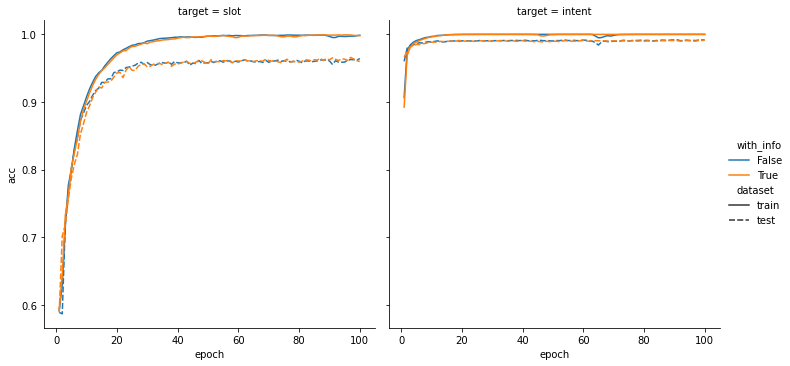

In [42]:
sns.relplot(data=tmp, x='epoch', y='acc', hue='with_info', style='dataset', col='target', kind='line')
plt.savefig('plots/additional_info_acc_atis.pdf', bbox_inches='tight')

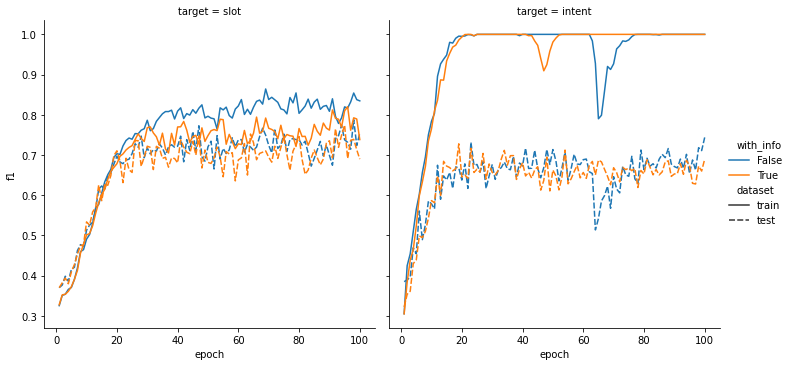

In [43]:
sns.relplot(data=tmp, x='epoch', y='f1', hue='with_info', style='dataset', col='target', kind='line')
plt.savefig('plots/additional_info_f1_atis.pdf', bbox_inches='tight')

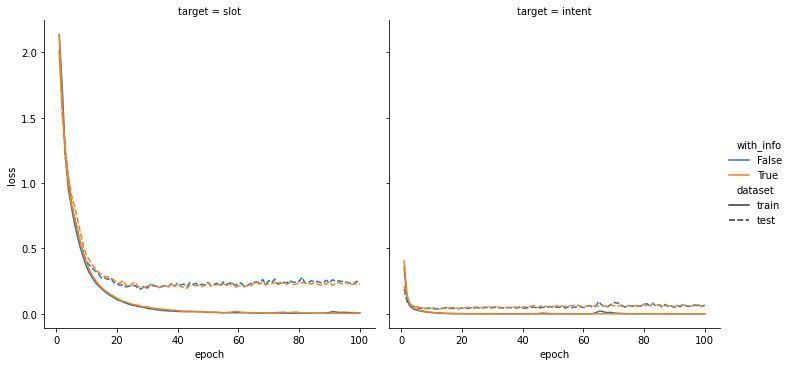

In [44]:
sns.relplot(data=tmp, x='epoch', y='loss', hue='with_info', style='dataset', col='target', kind='line')
plt.savefig('plots/additional_info_loss_atis.pdf', bbox_inches='tight')

# Новая модель

In [7]:
d = DatasetManager('./data/atis_snips/atis/', batch_size=256, device=device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
class SlotNet(nn.Module):
    def __init__(self, input_size, num_slots, hidden_size=200, lstm_layers=4):
        super(SlotNet, self).__init__()
        self.__softmax = nn.Softmax(dim=1)
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers 
        )
        
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * 2, num_slots)
        )
        
    def forward(self, X):
        X_lstm = self.__lstm(X)
        y = self.__fc(X_lstm[0])
        return y
    
class IntentNet(nn.Module):
    def __init__(self, input_size, num_intent, hidden_size=200, lstm_layers=4):
        super(IntentNet, self).__init__()
        self.__lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            bidirectional=True,
            dropout=0.4,
            num_layers=lstm_layers        
        )
        self.__fc = nn.Sequential(
            nn.Linear(hidden_size * lstm_layers * 4, num_intent),
            nn.Sigmoid()
        )
    
    def forward(self, X, slot):
        X_lstm = self.__lstm(torch.cat((X, slot), dim=-1))
        return self.__fc(torch.cat(X_lstm[1]).transpose(0, 1).reshape(X.shape[0], -1))
    
class Net(nn.Module):
    def __init__(
        self, 
        input_size,
        num_intent, 
        num_slots, 
        intent_hidden_size=200,
        slot_hidden_size=200,        
        lstm_layers=4
    ):
        super(Net, self).__init__()
        self.__slot_net = SlotNet(input_size, num_slots, slot_hidden_size, lstm_layers)
        self.__intent_net = IntentNet(input_size + num_slots, num_intent, intent_hidden_size, lstm_layers)
        
    def forward(self, X):
        y_slot = self.__slot_net(X)
        y_intent = self.__intent_net(X, y_slot)
        return y_intent, y_slot

In [9]:
class SlotAndIntentStep(BaseStep):
    def __init__(self, net, criterion, optimizer, alpha):
        super(SlotAndIntentStep, self).__init__(net, criterion, optimizer)
        self.alpha = alpha
        
    def forward(self, X, slot, intent):
        y_intent, y_slot = self.net(X)
        
        loss = {
            'intent': self.intent_criterion(y_intent, intent.to(device)),
            'slot': self.slot_criterion(y_slot.transpose(1, 2), slot.to(device))
        }
        
        y_intent = (y_intent > 0.5).float()
        y_slot = y_slot.argmax(axis=-1)
        
        acc = {
            'intent': accuracy(intent, y_intent),
            'slot': accuracy(slot, y_slot)
        }
        
        f1 = {
            'intent': f1_score(intent.cpu(), y_intent.cpu(), average='macro', zero_division=1),
            'slot': f1_score(
                y_true=slot.cpu().flatten(),
                y_pred=y_slot.cpu().flatten(), 
                labels=range(N_SLOT), average='macro',
                zero_division=1
            )
        } 
        
        return loss, f1, acc
    
    def step(self, X, slot, intent):
        self.optimizer.zero_grad()
        
        loss, f1, acc = self.forward(X, slot, intent)
        
        total_loss = (1 - self.alpha) * loss['intent'] + self.alpha * loss['slot']
        
        total_loss.backward()
        
        self.optimizer.step()
        
        return loss, f1, acc

In [10]:
steppers = dict()
a = np.linspace(-3, 3, 9)
alpha_list = [round(i, 2) for i in sigmoid(a)]

for alpha in alpha_list:
    torch.manual_seed(seed)
    net = Net(768, N_INTENT, len(d.slot_enc), 200, 200, 2).to(device)

    criterion = {
        'intent': nn.BCELoss(),
        'slot': nn.CrossEntropyLoss(ignore_index=-1)
    }
    optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-6)
    
    steppers[f'alpha={alpha}'] = SlotAndIntentStep(net, criterion, optimizer, alpha)

In [11]:
history = train(steppers, N_EPOCH)
history.to_csv('history/new_model_atis.csv', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1 / 100
------------------
alpha=0.05_intent
Train loss: 2.5767
Train acc: 0.2972
Train f1: 0.8837
Test loss: 3.2455
Test acc: 0.2848
Test f1: 0.9671
------------------
alpha=0.05_slot
Train loss: 4.0908
Train acc: 0.4000
Train f1: 0.4210
Test loss: 4.0066
Test acc: 0.4563
Test f1: 0.5874
------------------
alpha=0.1_intent
Train loss: 2.6657
Train acc: 0.2978
Train f1: 0.8822
Test loss: 3.2787
Test acc: 0.2848
Test f1: 0.9671
------------------
alpha=0.1_slot
Train loss: 3.8025
Train acc: 0.4069
Train f1: 0.4223
Test loss: 3.5537
Test acc: 0.4563
Test f1: 0.5874
------------------
alpha=0.18_intent
Train loss: 0.7421
Train acc: 0.2984
Train f1: 0.8659
Test loss: 0.2650
Test acc: 0.3304
Test f1: 0.9696
------------------
alpha=0.18_slot
Train loss: 3.3354
Train acc: 0.4092
Train f1: 0.4201
Test loss: 2.5327
Test acc: 0.4563
Test f1: 0.5874
------------------
alpha=0.32_intent
Train loss: 0.6984
Train acc: 0.2924
Train f1: 0.8717
Test loss: 0.1208
Test acc: 0.2828
Test f1: 0.9687


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2 / 100
------------------
alpha=0.05_intent
Train loss: 3.0461
Train acc: 0.3181
Train f1: 0.9694
Test loss: 3.2104
Test acc: 0.2997
Test f1: 0.9675
------------------
alpha=0.05_slot
Train loss: 3.1239
Train acc: 0.4249
Train f1: 0.6295
Test loss: 2.8886
Test acc: 0.4599
Test f1: 0.5870
------------------
alpha=0.1_intent
Train loss: 3.0590
Train acc: 0.3181
Train f1: 0.9694
Test loss: 3.2358
Test acc: 0.2997
Test f1: 0.9675
------------------
alpha=0.1_slot
Train loss: 2.8502
Train acc: 0.4249
Train f1: 0.6295
Test loss: 2.6039
Test acc: 0.4599
Test f1: 0.5870
------------------
alpha=0.18_intent
Train loss: 0.1509
Train acc: 0.3364
Train f1: 0.9690
Test loss: 0.1010
Test acc: 0.3241
Test f1: 0.9757
------------------
alpha=0.18_slot
Train loss: 2.1021
Train acc: 0.4249
Train f1: 0.6295
Test loss: 2.1026
Test acc: 0.4599
Test f1: 0.5870
------------------
alpha=0.32_intent
Train loss: 0.0972
Train acc: 0.3314
Train f1: 0.9715
Test loss: 0.1022
Test acc: 0.3523
Test f1: 0.9676


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3 / 100
------------------
alpha=0.05_intent
Train loss: 3.0650
Train acc: 0.3279
Train f1: 0.9693
Test loss: 3.3066
Test acc: 0.2552
Test f1: 0.9665
------------------
alpha=0.05_slot
Train loss: 2.4009
Train acc: 0.4263
Train f1: 0.6298
Test loss: 2.3259
Test acc: 0.4773
Test f1: 0.5892
------------------
alpha=0.1_intent
Train loss: 3.0695
Train acc: 0.3279
Train f1: 0.9693
Test loss: 3.3410
Test acc: 0.2552
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 2.2835
Train acc: 0.4263
Train f1: 0.6298
Test loss: 2.2383
Test acc: 0.4773
Test f1: 0.5892
------------------
alpha=0.18_intent
Train loss: 0.0709
Train acc: 0.3977
Train f1: 0.9798
Test loss: 0.0776
Test acc: 0.3413
Test f1: 0.9795
------------------
alpha=0.18_slot
Train loss: 1.9051
Train acc: 0.4263
Train f1: 0.6298
Test loss: 2.0354
Test acc: 0.4773
Test f1: 0.5892
------------------
alpha=0.32_intent
Train loss: 0.0702
Train acc: 0.3719
Train f1: 0.9780
Test loss: 0.0755
Test acc: 0.3411
Test f1: 0.9779


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4 / 100
------------------
alpha=0.05_intent
Train loss: 3.0471
Train acc: 0.3410
Train f1: 0.9695
Test loss: 3.3406
Test acc: 0.2993
Test f1: 0.9663
------------------
alpha=0.05_slot
Train loss: 2.0923
Train acc: 0.4432
Train f1: 0.6296
Test loss: 2.1605
Test acc: 0.4948
Test f1: 0.5891
------------------
alpha=0.1_intent
Train loss: 3.0471
Train acc: 0.3410
Train f1: 0.9695
Test loss: 3.3658
Test acc: 0.2993
Test f1: 0.9663
------------------
alpha=0.1_slot
Train loss: 2.0481
Train acc: 0.4432
Train f1: 0.6296
Test loss: 2.1088
Test acc: 0.4948
Test f1: 0.5891
------------------
alpha=0.18_intent
Train loss: 0.0523
Train acc: 0.4654
Train f1: 0.9839
Test loss: 0.0683
Test acc: 0.4604
Test f1: 0.9826
------------------
alpha=0.18_slot
Train loss: 1.8506
Train acc: 0.4432
Train f1: 0.6296
Test loss: 1.9910
Test acc: 0.4948
Test f1: 0.5891
------------------
alpha=0.32_intent
Train loss: 0.0522
Train acc: 0.4648
Train f1: 0.9832
Test loss: 0.0728
Test acc: 0.4235
Test f1: 0.9792


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5 / 100
------------------
alpha=0.05_intent
Train loss: 3.0426
Train acc: 0.3508
Train f1: 0.9695
Test loss: 3.2768
Test acc: 0.2995
Test f1: 0.9670
------------------
alpha=0.05_slot
Train loss: 1.9220
Train acc: 0.4209
Train f1: 0.6294
Test loss: 2.0138
Test acc: 0.4459
Test f1: 0.5874
------------------
alpha=0.1_intent
Train loss: 3.0471
Train acc: 0.3508
Train f1: 0.9695
Test loss: 3.2878
Test acc: 0.2995
Test f1: 0.9670
------------------
alpha=0.1_slot
Train loss: 1.9007
Train acc: 0.4209
Train f1: 0.6294
Test loss: 1.9865
Test acc: 0.4459
Test f1: 0.5874
------------------
alpha=0.18_intent
Train loss: 0.0371
Train acc: 0.5520
Train f1: 0.9888
Test loss: 0.0601
Test acc: 0.4771
Test f1: 0.9849
------------------
alpha=0.18_slot
Train loss: 1.7715
Train acc: 0.4209
Train f1: 0.6294
Test loss: 1.8457
Test acc: 0.4459
Test f1: 0.5874
------------------
alpha=0.32_intent
Train loss: 0.0443
Train acc: 0.5206
Train f1: 0.9856
Test loss: 0.0648
Test acc: 0.4012
Test f1: 0.9804


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6 / 100
------------------
alpha=0.05_intent
Train loss: 3.0384
Train acc: 0.3475
Train f1: 0.9695
Test loss: 3.3519
Test acc: 0.2994
Test f1: 0.9665
------------------
alpha=0.05_slot
Train loss: 1.6909
Train acc: 0.4304
Train f1: 0.6295
Test loss: 1.7120
Test acc: 0.4734
Test f1: 0.5887
------------------
alpha=0.1_intent
Train loss: 3.0458
Train acc: 0.3475
Train f1: 0.9695
Test loss: 3.3519
Test acc: 0.2994
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 1.7200
Train acc: 0.4303
Train f1: 0.6295
Test loss: 1.7761
Test acc: 0.4734
Test f1: 0.5887
------------------
alpha=0.18_intent
Train loss: 0.0297
Train acc: 0.5905
Train f1: 0.9911
Test loss: 0.0589
Test acc: 0.5204
Test f1: 0.9863
------------------
alpha=0.18_slot
Train loss: 1.5421
Train acc: 0.4303
Train f1: 0.6297
Test loss: 1.5726
Test acc: 0.4735
Test f1: 0.6012
------------------
alpha=0.32_intent
Train loss: 0.0409
Train acc: 0.5537
Train f1: 0.9869
Test loss: 0.0528
Test acc: 0.5063
Test f1: 0.9847


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7 / 100
------------------
alpha=0.05_intent
Train loss: 3.0571
Train acc: 0.3508
Train f1: 0.9694
Test loss: 3.3287
Test acc: 0.2845
Test f1: 0.9660
------------------
alpha=0.05_slot
Train loss: 1.4458
Train acc: 0.4273
Train f1: 0.6762
Test loss: 1.5369
Test acc: 0.4792
Test f1: 0.6666
------------------
alpha=0.1_intent
Train loss: 3.0577
Train acc: 0.3508
Train f1: 0.9694
Test loss: 3.3715
Test acc: 0.2845
Test f1: 0.9660
------------------
alpha=0.1_slot
Train loss: 1.5374
Train acc: 0.4270
Train f1: 0.6311
Test loss: 1.6143
Test acc: 0.4783
Test f1: 0.6315
------------------
alpha=0.18_intent
Train loss: 0.0240
Train acc: 0.6333
Train f1: 0.9922
Test loss: 0.0531
Test acc: 0.5306
Test f1: 0.9869
------------------
alpha=0.18_slot
Train loss: 1.3494
Train acc: 0.4276
Train f1: 0.6952
Test loss: 1.4583
Test acc: 0.4793
Test f1: 0.6686
------------------
alpha=0.32_intent
Train loss: 0.0312
Train acc: 0.5904
Train f1: 0.9901
Test loss: 0.0555
Test acc: 0.4612
Test f1: 0.9847


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8 / 100
------------------
alpha=0.05_intent
Train loss: 3.0415
Train acc: 0.3541
Train f1: 0.9696
Test loss: 3.3341
Test acc: 0.3141
Test f1: 0.9666
------------------
alpha=0.05_slot
Train loss: 1.3385
Train acc: 0.4183
Train f1: 0.7017
Test loss: 1.4639
Test acc: 0.4670
Test f1: 0.6616
------------------
alpha=0.1_intent
Train loss: 3.0419
Train acc: 0.3541
Train f1: 0.9696
Test loss: 3.3399
Test acc: 0.3141
Test f1: 0.9666
------------------
alpha=0.1_slot
Train loss: 1.4033
Train acc: 0.4181
Train f1: 0.7022
Test loss: 1.4925
Test acc: 0.4671
Test f1: 0.7214
------------------
alpha=0.18_intent
Train loss: 0.0206
Train acc: 0.6539
Train f1: 0.9935
Test loss: 0.0516
Test acc: 0.5044
Test f1: 0.9873
------------------
alpha=0.18_slot
Train loss: 1.2749
Train acc: 0.4188
Train f1: 0.7057
Test loss: 1.4040
Test acc: 0.4678
Test f1: 0.6766
------------------
alpha=0.32_intent
Train loss: 0.0266
Train acc: 0.6435
Train f1: 0.9916
Test loss: 0.0529
Test acc: 0.4637
Test f1: 0.9853


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9 / 100
------------------
alpha=0.05_intent
Train loss: 3.0597
Train acc: 0.3442
Train f1: 0.9694
Test loss: 3.3562
Test acc: 0.2698
Test f1: 0.9662
------------------
alpha=0.05_slot
Train loss: 1.2703
Train acc: 0.4291
Train f1: 0.7038
Test loss: 1.3979
Test acc: 0.4608
Test f1: 0.6689
------------------
alpha=0.1_intent
Train loss: 3.0603
Train acc: 0.3442
Train f1: 0.9694
Test loss: 3.3717
Test acc: 0.2698
Test f1: 0.9662
------------------
alpha=0.1_slot
Train loss: 1.2867
Train acc: 0.4291
Train f1: 0.7242
Test loss: 1.3908
Test acc: 0.4608
Test f1: 0.6695
------------------
alpha=0.18_intent
Train loss: 0.0178
Train acc: 0.6875
Train f1: 0.9943
Test loss: 0.0490
Test acc: 0.5778
Test f1: 0.9882
------------------
alpha=0.18_slot
Train loss: 1.2187
Train acc: 0.4296
Train f1: 0.7231
Test loss: 1.3405
Test acc: 0.4615
Test f1: 0.6932
------------------
alpha=0.32_intent
Train loss: 0.0226
Train acc: 0.6702
Train f1: 0.9923
Test loss: 0.0428
Test acc: 0.5746
Test f1: 0.9879


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10 / 100
------------------
alpha=0.05_intent
Train loss: 3.0522
Train acc: 0.3312
Train f1: 0.9695
Test loss: 3.2802
Test acc: 0.3142
Test f1: 0.9670
------------------
alpha=0.05_slot
Train loss: 1.1995
Train acc: 0.4207
Train f1: 0.7045
Test loss: 1.3128
Test acc: 0.4743
Test f1: 0.6691
------------------
alpha=0.1_intent
Train loss: 3.0531
Train acc: 0.3312
Train f1: 0.9695
Test loss: 3.2853
Test acc: 0.3142
Test f1: 0.9670
------------------
alpha=0.1_slot
Train loss: 1.1908
Train acc: 0.4206
Train f1: 0.7307
Test loss: 1.2937
Test acc: 0.4743
Test f1: 0.7286
------------------
alpha=0.18_intent
Train loss: 0.0144
Train acc: 0.7293
Train f1: 0.9955
Test loss: 0.0457
Test acc: 0.5869
Test f1: 0.9880
------------------
alpha=0.18_slot
Train loss: 1.1486
Train acc: 0.4211
Train f1: 0.7331
Test loss: 1.2560
Test acc: 0.4747
Test f1: 0.7127
------------------
alpha=0.32_intent
Train loss: 0.0199
Train acc: 0.7043
Train f1: 0.9937
Test loss: 0.0419
Test acc: 0.6376
Test f1: 0.9878

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11 / 100
------------------
alpha=0.05_intent
Train loss: 3.0671
Train acc: 0.3311
Train f1: 0.9693
Test loss: 3.2777
Test acc: 0.2995
Test f1: 0.9671
------------------
alpha=0.05_slot
Train loss: 1.1110
Train acc: 0.4240
Train f1: 0.7061
Test loss: 1.2327
Test acc: 0.4610
Test f1: 0.6896
------------------
alpha=0.1_intent
Train loss: 3.0733
Train acc: 0.3311
Train f1: 0.9693
Test loss: 3.2857
Test acc: 0.2995
Test f1: 0.9671
------------------
alpha=0.1_slot
Train loss: 1.1059
Train acc: 0.4238
Train f1: 0.7442
Test loss: 1.2081
Test acc: 0.4571
Test f1: 0.7340
------------------
alpha=0.18_intent
Train loss: 0.0119
Train acc: 0.7664
Train f1: 0.9964
Test loss: 0.0466
Test acc: 0.6110
Test f1: 0.9887
------------------
alpha=0.18_slot
Train loss: 1.0621
Train acc: 0.4242
Train f1: 0.7391
Test loss: 1.1703
Test acc: 0.4577
Test f1: 0.7151
------------------
alpha=0.32_intent
Train loss: 0.0165
Train acc: 0.7342
Train f1: 0.9946
Test loss: 0.0382
Test acc: 0.6208
Test f1: 0.9885

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12 / 100
------------------
alpha=0.05_intent
Train loss: 3.0496
Train acc: 0.3344
Train f1: 0.9694
Test loss: 3.2829
Test acc: 0.2847
Test f1: 0.9668
------------------
alpha=0.05_slot
Train loss: 1.0395
Train acc: 0.4275
Train f1: 0.7178
Test loss: 1.1518
Test acc: 0.4724
Test f1: 0.6888
------------------
alpha=0.1_intent
Train loss: 3.0560
Train acc: 0.3344
Train f1: 0.9694
Test loss: 3.2937
Test acc: 0.2847
Test f1: 0.9668
------------------
alpha=0.1_slot
Train loss: 0.9966
Train acc: 0.4269
Train f1: 0.7716
Test loss: 1.0682
Test acc: 0.4742
Test f1: 0.7555
------------------
alpha=0.18_intent
Train loss: 0.0126
Train acc: 0.7875
Train f1: 0.9964
Test loss: 0.0429
Test acc: 0.5738
Test f1: 0.9882
------------------
alpha=0.18_slot
Train loss: 0.9925
Train acc: 0.4258
Train f1: 0.7646
Test loss: 1.0950
Test acc: 0.4698
Test f1: 0.7710
------------------
alpha=0.32_intent
Train loss: 0.0163
Train acc: 0.8117
Train f1: 0.9946
Test loss: 0.0377
Test acc: 0.5652
Test f1: 0.9886

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13 / 100
------------------
alpha=0.05_intent
Train loss: 3.0633
Train acc: 0.3442
Train f1: 0.9693
Test loss: 3.2732
Test acc: 0.3142
Test f1: 0.9671
------------------
alpha=0.05_slot
Train loss: 0.9752
Train acc: 0.4300
Train f1: 0.7369
Test loss: 1.0817
Test acc: 0.4758
Test f1: 0.7116
------------------
alpha=0.1_intent
Train loss: 3.0660
Train acc: 0.3442
Train f1: 0.9693
Test loss: 3.2812
Test acc: 0.3142
Test f1: 0.9671
------------------
alpha=0.1_slot
Train loss: 0.8747
Train acc: 0.4363
Train f1: 0.8065
Test loss: 0.9481
Test acc: 0.4872
Test f1: 0.7931
------------------
alpha=0.18_intent
Train loss: 0.0100
Train acc: 0.8187
Train f1: 0.9968
Test loss: 0.0385
Test acc: 0.6387
Test f1: 0.9902
------------------
alpha=0.18_slot
Train loss: 0.9339
Train acc: 0.4280
Train f1: 0.7928
Test loss: 1.0378
Test acc: 0.4740
Test f1: 0.7835
------------------
alpha=0.32_intent
Train loss: 0.0126
Train acc: 0.8186
Train f1: 0.9956
Test loss: 0.0426
Test acc: 0.5543
Test f1: 0.9882

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14 / 100
------------------
alpha=0.05_intent
Train loss: 3.0548
Train acc: 0.3377
Train f1: 0.9693
Test loss: 3.3500
Test acc: 0.2846
Test f1: 0.9664
------------------
alpha=0.05_slot
Train loss: 0.9199
Train acc: 0.4217
Train f1: 0.7482
Test loss: 1.0289
Test acc: 0.4824
Test f1: 0.7231
------------------
alpha=0.1_intent
Train loss: 3.0616
Train acc: 0.3377
Train f1: 0.9693
Test loss: 3.3479
Test acc: 0.2846
Test f1: 0.9664
------------------
alpha=0.1_slot
Train loss: 0.7739
Train acc: 0.4302
Train f1: 0.8265
Test loss: 0.8605
Test acc: 0.4825
Test f1: 0.8002
------------------
alpha=0.18_intent
Train loss: 0.0069
Train acc: 0.8592
Train f1: 0.9978
Test loss: 0.0383
Test acc: 0.6997
Test f1: 0.9910
------------------
alpha=0.18_slot
Train loss: 0.8795
Train acc: 0.4160
Train f1: 0.8097
Test loss: 0.9772
Test acc: 0.4725
Test f1: 0.7933
------------------
alpha=0.32_intent
Train loss: 0.0118
Train acc: 0.7874
Train f1: 0.9960
Test loss: 0.0400
Test acc: 0.6498
Test f1: 0.9899

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15 / 100
------------------
alpha=0.05_intent
Train loss: 3.0380
Train acc: 0.3443
Train f1: 0.9695
Test loss: 3.3278
Test acc: 0.2994
Test f1: 0.9665
------------------
alpha=0.05_slot
Train loss: 0.8601
Train acc: 0.4408
Train f1: 0.7712
Test loss: 0.9568
Test acc: 0.4965
Test f1: 0.7401
------------------
alpha=0.1_intent
Train loss: 3.0449
Train acc: 0.3443
Train f1: 0.9695
Test loss: 3.3237
Test acc: 0.2994
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 0.6902
Train acc: 0.4467
Train f1: 0.8384
Test loss: 0.7788
Test acc: 0.4988
Test f1: 0.8295
------------------
alpha=0.18_intent
Train loss: 0.0054
Train acc: 0.9282
Train f1: 0.9985
Test loss: 0.0419
Test acc: 0.6272
Test f1: 0.9890
------------------
alpha=0.18_slot
Train loss: 0.8167
Train acc: 0.4377
Train f1: 0.8196
Test loss: 0.9054
Test acc: 0.4813
Test f1: 0.8037
------------------
alpha=0.32_intent
Train loss: 0.0092
Train acc: 0.8588
Train f1: 0.9970
Test loss: 0.0405
Test acc: 0.6334
Test f1: 0.9895

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16 / 100
------------------
alpha=0.05_intent
Train loss: 3.0549
Train acc: 0.3475
Train f1: 0.9694
Test loss: 3.2455
Test acc: 0.2995
Test f1: 0.9671
------------------
alpha=0.05_slot
Train loss: 0.7905
Train acc: 0.4464
Train f1: 0.8094
Test loss: 0.8833
Test acc: 0.4969
Test f1: 0.8148
------------------
alpha=0.1_intent
Train loss: 3.0573
Train acc: 0.3475
Train f1: 0.9694
Test loss: 3.2557
Test acc: 0.2995
Test f1: 0.9671
------------------
alpha=0.1_slot
Train loss: 0.6210
Train acc: 0.4525
Train f1: 0.8584
Test loss: 0.6979
Test acc: 0.4963
Test f1: 0.8481
------------------
alpha=0.18_intent
Train loss: 0.0044
Train acc: 0.9136
Train f1: 0.9986
Test loss: 0.0339
Test acc: 0.6634
Test f1: 0.9914
------------------
alpha=0.18_slot
Train loss: 0.7533
Train acc: 0.4425
Train f1: 0.8353
Test loss: 0.8281
Test acc: 0.4973
Test f1: 0.8338
------------------
alpha=0.32_intent
Train loss: 0.0080
Train acc: 0.8818
Train f1: 0.9975
Test loss: 0.0329
Test acc: 0.6224
Test f1: 0.9893

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17 / 100
------------------
alpha=0.05_intent
Train loss: 3.0480
Train acc: 0.3410
Train f1: 0.9694
Test loss: 3.3072
Test acc: 0.3140
Test f1: 0.9663
------------------
alpha=0.05_slot
Train loss: 0.7103
Train acc: 0.4538
Train f1: 0.8478
Test loss: 0.7738
Test acc: 0.5336
Test f1: 0.8416
------------------
alpha=0.1_intent
Train loss: 3.0544
Train acc: 0.3410
Train f1: 0.9694
Test loss: 3.3263
Test acc: 0.3140
Test f1: 0.9663
------------------
alpha=0.1_slot
Train loss: 0.5567
Train acc: 0.4604
Train f1: 0.8752
Test loss: 0.6384
Test acc: 0.5363
Test f1: 0.8665
------------------
alpha=0.18_intent
Train loss: 0.0038
Train acc: 0.9348
Train f1: 0.9988
Test loss: 0.0381
Test acc: 0.6584
Test f1: 0.9903
------------------
alpha=0.18_slot
Train loss: 0.6800
Train acc: 0.4467
Train f1: 0.8536
Test loss: 0.7580
Test acc: 0.5095
Test f1: 0.8426
------------------
alpha=0.32_intent
Train loss: 0.0079
Train acc: 0.8645
Train f1: 0.9976
Test loss: 0.0452
Test acc: 0.5972
Test f1: 0.9882

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18 / 100
------------------
alpha=0.05_intent
Train loss: 3.0356
Train acc: 0.3443
Train f1: 0.9695
Test loss: 3.3236
Test acc: 0.2846
Test f1: 0.9667
------------------
alpha=0.05_slot
Train loss: 0.6064
Train acc: 0.4781
Train f1: 0.8731
Test loss: 0.6796
Test acc: 0.5431
Test f1: 0.8625
------------------
alpha=0.1_intent
Train loss: 3.0408
Train acc: 0.3443
Train f1: 0.9695
Test loss: 3.3120
Test acc: 0.2846
Test f1: 0.9667
------------------
alpha=0.1_slot
Train loss: 0.4921
Train acc: 0.4835
Train f1: 0.8910
Test loss: 0.5732
Test acc: 0.5455
Test f1: 0.8713
------------------
alpha=0.18_intent
Train loss: 0.0044
Train acc: 0.9553
Train f1: 0.9986
Test loss: 0.0564
Test acc: 0.6449
Test f1: 0.9891
------------------
alpha=0.18_slot
Train loss: 0.6078
Train acc: 0.4572
Train f1: 0.8696
Test loss: 0.6894
Test acc: 0.5207
Test f1: 0.8583
------------------
alpha=0.32_intent
Train loss: 0.0054
Train acc: 0.9100
Train f1: 0.9983
Test loss: 0.0384
Test acc: 0.6204
Test f1: 0.9884

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19 / 100
------------------
alpha=0.05_intent
Train loss: 3.0147
Train acc: 0.3312
Train f1: 0.9695
Test loss: 3.2403
Test acc: 0.2700
Test f1: 0.9667
------------------
alpha=0.05_slot
Train loss: 0.5353
Train acc: 0.4855
Train f1: 0.8837
Test loss: 0.5964
Test acc: 0.5438
Test f1: 0.8717
------------------
alpha=0.1_intent
Train loss: 3.0350
Train acc: 0.3312
Train f1: 0.9695
Test loss: 3.2924
Test acc: 0.2700
Test f1: 0.9667
------------------
alpha=0.1_slot
Train loss: 0.4337
Train acc: 0.4978
Train f1: 0.9031
Test loss: 0.5131
Test acc: 0.5517
Test f1: 0.8871
------------------
alpha=0.18_intent
Train loss: 0.0039
Train acc: 0.9635
Train f1: 0.9989
Test loss: 0.0448
Test acc: 0.6935
Test f1: 0.9901
------------------
alpha=0.18_slot
Train loss: 0.5468
Train acc: 0.4658
Train f1: 0.8841
Test loss: 0.6290
Test acc: 0.5241
Test f1: 0.8700
------------------
alpha=0.32_intent
Train loss: 0.0054
Train acc: 0.9335
Train f1: 0.9983
Test loss: 0.0422
Test acc: 0.6405
Test f1: 0.9889

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20 / 100
------------------
alpha=0.05_intent
Train loss: 2.9914
Train acc: 0.3247
Train f1: 0.9696
Test loss: 3.2913
Test acc: 0.2402
Test f1: 0.9658
------------------
alpha=0.05_slot
Train loss: 0.4698
Train acc: 0.4802
Train f1: 0.8953
Test loss: 0.5357
Test acc: 0.5278
Test f1: 0.8862
------------------
alpha=0.1_intent
Train loss: 3.0220
Train acc: 0.3247
Train f1: 0.9696
Test loss: 3.3476
Test acc: 0.2402
Test f1: 0.9658
------------------
alpha=0.1_slot
Train loss: 0.3803
Train acc: 0.5057
Train f1: 0.9165
Test loss: 0.4847
Test acc: 0.5333
Test f1: 0.8960
------------------
alpha=0.18_intent
Train loss: 0.0022
Train acc: 0.9819
Train f1: 0.9996
Test loss: 0.0362
Test acc: 0.6961
Test f1: 0.9915
------------------
alpha=0.18_slot
Train loss: 0.4852
Train acc: 0.4571
Train f1: 0.8970
Test loss: 0.5704
Test acc: 0.4926
Test f1: 0.8786
------------------
alpha=0.32_intent
Train loss: 0.0045
Train acc: 0.9533
Train f1: 0.9986
Test loss: 0.0430
Test acc: 0.5829
Test f1: 0.9894

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21 / 100
------------------
alpha=0.05_intent
Train loss: 3.0045
Train acc: 0.3377
Train f1: 0.9695
Test loss: 3.2353
Test acc: 0.2407
Test f1: 0.9669
------------------
alpha=0.05_slot
Train loss: 0.4185
Train acc: 0.5017
Train f1: 0.9064
Test loss: 0.4907
Test acc: 0.5790
Test f1: 0.8957
------------------
alpha=0.1_intent
Train loss: 3.0386
Train acc: 0.3377
Train f1: 0.9695
Test loss: 3.2546
Test acc: 0.2407
Test f1: 0.9669
------------------
alpha=0.1_slot
Train loss: 0.3351
Train acc: 0.5165
Train f1: 0.9243
Test loss: 0.4296
Test acc: 0.5854
Test f1: 0.9032
------------------
alpha=0.18_intent
Train loss: 0.0017
Train acc: 0.9793
Train f1: 0.9997
Test loss: 0.0401
Test acc: 0.7042
Test f1: 0.9917
------------------
alpha=0.18_slot
Train loss: 0.4175
Train acc: 0.4723
Train f1: 0.9117
Test loss: 0.4943
Test acc: 0.5473
Test f1: 0.8957
------------------
alpha=0.32_intent
Train loss: 0.0040
Train acc: 0.9317
Train f1: 0.9988
Test loss: 0.0475
Test acc: 0.6096
Test f1: 0.9892

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22 / 100
------------------
alpha=0.05_intent
Train loss: 3.0146
Train acc: 0.3606
Train f1: 0.9694
Test loss: 3.2510
Test acc: 0.2697
Test f1: 0.9659
------------------
alpha=0.05_slot
Train loss: 0.3731
Train acc: 0.5080
Train f1: 0.9177
Test loss: 0.4485
Test acc: 0.5787
Test f1: 0.8994
------------------
alpha=0.1_intent
Train loss: 3.0396
Train acc: 0.3606
Train f1: 0.9694
Test loss: 3.2849
Test acc: 0.2697
Test f1: 0.9659
------------------
alpha=0.1_slot
Train loss: 0.2988
Train acc: 0.5289
Train f1: 0.9318
Test loss: 0.3960
Test acc: 0.6012
Test f1: 0.9109
------------------
alpha=0.18_intent
Train loss: 0.0012
Train acc: 0.9942
Train f1: 0.9998
Test loss: 0.0394
Test acc: 0.6557
Test f1: 0.9904
------------------
alpha=0.18_slot
Train loss: 0.3583
Train acc: 0.4756
Train f1: 0.9219
Test loss: 0.4443
Test acc: 0.5424
Test f1: 0.9026
------------------
alpha=0.32_intent
Train loss: 0.0024
Train acc: 0.9835
Train f1: 0.9993
Test loss: 0.0412
Test acc: 0.6011
Test f1: 0.9891

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23 / 100
------------------
alpha=0.05_intent
Train loss: 2.9730
Train acc: 0.3509
Train f1: 0.9697
Test loss: 3.3219
Test acc: 0.2845
Test f1: 0.9661
------------------
alpha=0.05_slot
Train loss: 0.3353
Train acc: 0.5241
Train f1: 0.9257
Test loss: 0.4226
Test acc: 0.5549
Test f1: 0.9039
------------------
alpha=0.1_intent
Train loss: 3.0000
Train acc: 0.3509
Train f1: 0.9697
Test loss: 3.2864
Test acc: 0.2845
Test f1: 0.9661
------------------
alpha=0.1_slot
Train loss: 0.2610
Train acc: 0.5533
Train f1: 0.9398
Test loss: 0.3586
Test acc: 0.5784
Test f1: 0.9144
------------------
alpha=0.18_intent
Train loss: 0.0011
Train acc: 0.9867
Train f1: 0.9999
Test loss: 0.0399
Test acc: 0.6648
Test f1: 0.9908
------------------
alpha=0.18_slot
Train loss: 0.3146
Train acc: 0.4839
Train f1: 0.9290
Test loss: 0.4070
Test acc: 0.5296
Test f1: 0.9113
------------------
alpha=0.32_intent
Train loss: 0.0038
Train acc: 0.9491
Train f1: 0.9987
Test loss: 0.0485
Test acc: 0.6111
Test f1: 0.9885

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24 / 100
------------------
alpha=0.05_intent
Train loss: 3.0146
Train acc: 0.3279
Train f1: 0.9694
Test loss: 3.3152
Test acc: 0.2695
Test f1: 0.9656
------------------
alpha=0.05_slot
Train loss: 0.3017
Train acc: 0.5426
Train f1: 0.9317
Test loss: 0.3937
Test acc: 0.6038
Test f1: 0.9098
------------------
alpha=0.1_intent
Train loss: 3.0083
Train acc: 0.3279
Train f1: 0.9694
Test loss: 3.3338
Test acc: 0.2695
Test f1: 0.9656
------------------
alpha=0.1_slot
Train loss: 0.2306
Train acc: 0.5735
Train f1: 0.9446
Test loss: 0.3538
Test acc: 0.6309
Test f1: 0.9186
------------------
alpha=0.18_intent
Train loss: 0.0013
Train acc: 0.9951
Train f1: 0.9999
Test loss: 0.0490
Test acc: 0.7046
Test f1: 0.9900
------------------
alpha=0.18_slot
Train loss: 0.2819
Train acc: 0.5010
Train f1: 0.9353
Test loss: 0.3839
Test acc: 0.5667
Test f1: 0.9112
------------------
alpha=0.32_intent
Train loss: 0.0029
Train acc: 0.9724
Train f1: 0.9992
Test loss: 0.0466
Test acc: 0.6429
Test f1: 0.9896

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25 / 100
------------------
alpha=0.05_intent
Train loss: 2.9959
Train acc: 0.3410
Train f1: 0.9694
Test loss: 3.1917
Test acc: 0.3141
Test f1: 0.9666
------------------
alpha=0.05_slot
Train loss: 0.2738
Train acc: 0.5631
Train f1: 0.9371
Test loss: 0.3713
Test acc: 0.5748
Test f1: 0.9146
------------------
alpha=0.1_intent
Train loss: 3.0106
Train acc: 0.3410
Train f1: 0.9694
Test loss: 3.1993
Test acc: 0.3141
Test f1: 0.9666
------------------
alpha=0.1_slot
Train loss: 0.2060
Train acc: 0.5926
Train f1: 0.9494
Test loss: 0.3144
Test acc: 0.6350
Test f1: 0.9262
------------------
alpha=0.18_intent
Train loss: 0.0011
Train acc: 0.9884
Train f1: 0.9998
Test loss: 0.0432
Test acc: 0.7465
Test f1: 0.9909
------------------
alpha=0.18_slot
Train loss: 0.2549
Train acc: 0.5054
Train f1: 0.9409
Test loss: 0.3483
Test acc: 0.5461
Test f1: 0.9195
------------------
alpha=0.32_intent
Train loss: 0.0038
Train acc: 0.9591
Train f1: 0.9986
Test loss: 0.0417
Test acc: 0.6785
Test f1: 0.9902

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26 / 100
------------------
alpha=0.05_intent
Train loss: 3.9756
Train acc: 0.3466
Train f1: 0.9574
Test loss: 11.0663
Test acc: 0.2131
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 4.2602
Train acc: 0.4828
Train f1: 0.6257
Test loss: 6.8002
Test acc: 0.4879
Test f1: 0.5881
------------------
alpha=0.1_intent
Train loss: 2.9894
Train acc: 0.3443
Train f1: 0.9696
Test loss: 3.1808
Test acc: 0.2552
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 0.1855
Train acc: 0.5982
Train f1: 0.9542
Test loss: 0.3028
Test acc: 0.6329
Test f1: 0.9265
------------------
alpha=0.18_intent
Train loss: 0.0010
Train acc: 0.9950
Train f1: 0.9999
Test loss: 0.0444
Test acc: 0.6946
Test f1: 0.9907
------------------
alpha=0.18_slot
Train loss: 0.2302
Train acc: 0.5061
Train f1: 0.9451
Test loss: 0.3322
Test acc: 0.5937
Test f1: 0.9214
------------------
alpha=0.32_intent
Train loss: 0.0028
Train acc: 0.9518
Train f1: 0.9992
Test loss: 0.0459
Test acc: 0.6056
Test f1: 0.990

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27 / 100
------------------
alpha=0.05_intent
Train loss: 10.7296
Train acc: 0.2875
Train f1: 0.8927
Test loss: 11.0483
Test acc: 0.2722
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 5.1708
Train acc: 0.4264
Train f1: 0.6020
Test loss: 4.5800
Test acc: 0.4704
Test f1: 0.6591
------------------
alpha=0.1_intent
Train loss: 2.9936
Train acc: 0.3279
Train f1: 0.9694
Test loss: 3.1988
Test acc: 0.3141
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 0.1699
Train acc: 0.6198
Train f1: 0.9575
Test loss: 0.2945
Test acc: 0.6352
Test f1: 0.9301
------------------
alpha=0.18_intent
Train loss: 0.0010
Train acc: 0.9945
Train f1: 0.9999
Test loss: 0.0443
Test acc: 0.7523
Test f1: 0.9916
------------------
alpha=0.18_slot
Train loss: 0.2078
Train acc: 0.5412
Train f1: 0.9510
Test loss: 0.3246
Test acc: 0.5846
Test f1: 0.9231
------------------
alpha=0.32_intent
Train loss: 0.0022
Train acc: 0.9525
Train f1: 0.9994
Test loss: 0.0540
Test acc: 0.6215
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 28 / 100
------------------
alpha=0.05_intent
Train loss: 10.7507
Train acc: 0.2873
Train f1: 0.8925
Test loss: 11.0723
Test acc: 0.2278
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 3.3304
Train acc: 0.4327
Train f1: 0.6844
Test loss: 2.6190
Test acc: 0.4850
Test f1: 0.6576
------------------
alpha=0.1_intent
Train loss: 2.9546
Train acc: 0.3279
Train f1: 0.9695
Test loss: 3.1464
Test acc: 0.2700
Test f1: 0.9667
------------------
alpha=0.1_slot
Train loss: 0.1534
Train acc: 0.6450
Train f1: 0.9623
Test loss: 0.2768
Test acc: 0.6569
Test f1: 0.9318
------------------
alpha=0.18_intent
Train loss: 0.0009
Train acc: 0.9970
Train f1: 0.9999
Test loss: 0.0436
Test acc: 0.7191
Test f1: 0.9916
------------------
alpha=0.18_slot
Train loss: 0.1843
Train acc: 0.5674
Train f1: 0.9570
Test loss: 0.3029
Test acc: 0.5983
Test f1: 0.9298
------------------
alpha=0.32_intent
Train loss: 0.0022
Train acc: 0.9702
Train f1: 0.9995
Test loss: 0.0418
Test acc: 0.6416
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 29 / 100
------------------
alpha=0.05_intent
Train loss: 10.7270
Train acc: 0.3039
Train f1: 0.8927
Test loss: 11.0603
Test acc: 0.2575
Test f1: 0.8894
------------------
alpha=0.05_slot
Train loss: 1.8635
Train acc: 0.4254
Train f1: 0.6978
Test loss: 1.5600
Test acc: 0.4681
Test f1: 0.6680
------------------
alpha=0.1_intent
Train loss: 2.9647
Train acc: 0.3443
Train f1: 0.9695
Test loss: 3.0428
Test acc: 0.2996
Test f1: 0.9673
------------------
alpha=0.1_slot
Train loss: 0.1374
Train acc: 0.6484
Train f1: 0.9671
Test loss: 0.2710
Test acc: 0.6701
Test f1: 0.9378
------------------
alpha=0.18_intent
Train loss: 0.0009
Train acc: 0.9981
Train f1: 0.9999
Test loss: 0.0417
Test acc: 0.7286
Test f1: 0.9919
------------------
alpha=0.18_slot
Train loss: 0.1637
Train acc: 0.5899
Train f1: 0.9625
Test loss: 0.2847
Test acc: 0.6347
Test f1: 0.9361
------------------
alpha=0.32_intent
Train loss: 0.0024
Train acc: 0.9738
Train f1: 0.9993
Test loss: 0.0504
Test acc: 0.6243
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 30 / 100
------------------
alpha=0.05_intent
Train loss: 10.7402
Train acc: 0.3005
Train f1: 0.8926
Test loss: 11.0663
Test acc: 0.2572
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 1.1633
Train acc: 0.4187
Train f1: 0.7209
Test loss: 1.1855
Test acc: 0.4672
Test f1: 0.6922
------------------
alpha=0.1_intent
Train loss: 3.1981
Train acc: 0.3411
Train f1: 0.9664
Test loss: 3.3459
Test acc: 0.2993
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 1.5436
Train acc: 0.4791
Train f1: 0.7788
Test loss: 1.0603
Test acc: 0.4828
Test f1: 0.7748
------------------
alpha=0.18_intent
Train loss: 0.0007
Train acc: 0.9989
Train f1: 1.0000
Test loss: 0.0531
Test acc: 0.6793
Test f1: 0.9909
------------------
alpha=0.18_slot
Train loss: 0.1396
Train acc: 0.6091
Train f1: 0.9692
Test loss: 0.2791
Test acc: 0.6499
Test f1: 0.9368
------------------
alpha=0.32_intent
Train loss: 0.0021
Train acc: 0.9760
Train f1: 0.9995
Test loss: 0.0482
Test acc: 0.6568
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 31 / 100
------------------
alpha=0.05_intent
Train loss: 10.7217
Train acc: 0.3072
Train f1: 0.8928
Test loss: 11.0603
Test acc: 0.2132
Test f1: 0.8894
------------------
alpha=0.05_slot
Train loss: 0.9426
Train acc: 0.4213
Train f1: 0.7737
Test loss: 0.9650
Test acc: 0.4773
Test f1: 0.7971
------------------
alpha=0.1_intent
Train loss: 3.0643
Train acc: 0.3475
Train f1: 0.9694
Test loss: 3.3519
Test acc: 0.2552
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 0.7402
Train acc: 0.4406
Train f1: 0.8362
Test loss: 0.6423
Test acc: 0.5095
Test f1: 0.8548
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9993
Train f1: 1.0000
Test loss: 0.0498
Test acc: 0.6375
Test f1: 0.9904
------------------
alpha=0.18_slot
Train loss: 0.1264
Train acc: 0.6328
Train f1: 0.9722
Test loss: 0.2553
Test acc: 0.6411
Test f1: 0.9398
------------------
alpha=0.32_intent
Train loss: 0.0013
Train acc: 0.9851
Train f1: 0.9997
Test loss: 0.0524
Test acc: 0.5608
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 32 / 100
------------------
alpha=0.05_intent
Train loss: 10.7402
Train acc: 0.2809
Train f1: 0.8926
Test loss: 11.0663
Test acc: 0.2133
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 0.7668
Train acc: 0.4579
Train f1: 0.8273
Test loss: 0.8140
Test acc: 0.5064
Test f1: 0.8269
------------------
alpha=0.1_intent
Train loss: 3.0484
Train acc: 0.3214
Train f1: 0.9695
Test loss: 3.3580
Test acc: 0.2552
Test f1: 0.9664
------------------
alpha=0.1_slot
Train loss: 0.4951
Train acc: 0.4806
Train f1: 0.8840
Test loss: 0.5040
Test acc: 0.5316
Test f1: 0.8793
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9964
Train f1: 1.0000
Test loss: 0.0502
Test acc: 0.6523
Test f1: 0.9904
------------------
alpha=0.18_slot
Train loss: 0.1096
Train acc: 0.6454
Train f1: 0.9767
Test loss: 0.2358
Test acc: 0.6465
Test f1: 0.9475
------------------
alpha=0.32_intent
Train loss: 0.0013
Train acc: 0.9888
Train f1: 0.9997
Test loss: 0.0435
Test acc: 0.6688
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 33 / 100
------------------
alpha=0.05_intent
Train loss: 10.7375
Train acc: 0.2940
Train f1: 0.8926
Test loss: 11.0784
Test acc: 0.2866
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.6459
Train acc: 0.4796
Train f1: 0.8564
Test loss: 0.6959
Test acc: 0.5217
Test f1: 0.8442
------------------
alpha=0.1_intent
Train loss: 3.0484
Train acc: 0.3345
Train f1: 0.9695
Test loss: 3.3459
Test acc: 0.3288
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 0.3887
Train acc: 0.5037
Train f1: 0.9061
Test loss: 0.4292
Test acc: 0.5684
Test f1: 0.8989
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9983
Train f1: 0.9999
Test loss: 0.0441
Test acc: 0.6915
Test f1: 0.9906
------------------
alpha=0.18_slot
Train loss: 0.0944
Train acc: 0.6457
Train f1: 0.9800
Test loss: 0.2329
Test acc: 0.6648
Test f1: 0.9491
------------------
alpha=0.32_intent
Train loss: 0.0013
Train acc: 0.9816
Train f1: 0.9997
Test loss: 0.0491
Test acc: 0.6637
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 34 / 100
------------------
alpha=0.05_intent
Train loss: 10.7362
Train acc: 0.2842
Train f1: 0.8926
Test loss: 11.0362
Test acc: 0.2722
Test f1: 0.8896
------------------
alpha=0.05_slot
Train loss: 0.5440
Train acc: 0.4804
Train f1: 0.8787
Test loss: 0.6082
Test acc: 0.5442
Test f1: 0.8668
------------------
alpha=0.1_intent
Train loss: 3.0550
Train acc: 0.3247
Train f1: 0.9694
Test loss: 3.4001
Test acc: 0.3138
Test f1: 0.9660
------------------
alpha=0.1_slot
Train loss: 0.3102
Train acc: 0.5259
Train f1: 0.9223
Test loss: 0.3723
Test acc: 0.6016
Test f1: 0.9076
------------------
alpha=0.18_intent
Train loss: 0.0006
Train acc: 0.9960
Train f1: 0.9999
Test loss: 0.0523
Test acc: 0.6662
Test f1: 0.9909
------------------
alpha=0.18_slot
Train loss: 0.0820
Train acc: 0.6932
Train f1: 0.9833
Test loss: 0.2328
Test acc: 0.6576
Test f1: 0.9491
------------------
alpha=0.32_intent
Train loss: 0.0014
Train acc: 0.9892
Train f1: 0.9997
Test loss: 0.0490
Test acc: 0.6354
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 35 / 100
------------------
alpha=0.05_intent
Train loss: 10.7415
Train acc: 0.2842
Train f1: 0.8926
Test loss: 11.0242
Test acc: 0.2578
Test f1: 0.8898
------------------
alpha=0.05_slot
Train loss: 0.4636
Train acc: 0.4949
Train f1: 0.8976
Test loss: 0.5122
Test acc: 0.5426
Test f1: 0.8819
------------------
alpha=0.1_intent
Train loss: 3.0419
Train acc: 0.3247
Train f1: 0.9696
Test loss: 3.3399
Test acc: 0.2994
Test f1: 0.9666
------------------
alpha=0.1_slot
Train loss: 0.2487
Train acc: 0.5459
Train f1: 0.9362
Test loss: 0.3163
Test acc: 0.6230
Test f1: 0.9181
------------------
alpha=0.18_intent
Train loss: 0.0007
Train acc: 0.9811
Train f1: 0.9999
Test loss: 0.0556
Test acc: 0.6924
Test f1: 0.9911
------------------
alpha=0.18_slot
Train loss: 0.0737
Train acc: 0.6818
Train f1: 0.9853
Test loss: 0.2100
Test acc: 0.6963
Test f1: 0.9549
------------------
alpha=0.32_intent
Train loss: 0.0012
Train acc: 0.9893
Train f1: 0.9997
Test loss: 0.0444
Test acc: 0.6511
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 36 / 100
------------------
alpha=0.05_intent
Train loss: 10.7454
Train acc: 0.3135
Train f1: 0.8925
Test loss: 11.0483
Test acc: 0.2282
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.4020
Train acc: 0.5059
Train f1: 0.9082
Test loss: 0.4711
Test acc: 0.5519
Test f1: 0.8916
------------------
alpha=0.1_intent
Train loss: 3.0458
Train acc: 0.3541
Train f1: 0.9695
Test loss: 3.3760
Test acc: 0.2699
Test f1: 0.9662
------------------
alpha=0.1_slot
Train loss: 0.2121
Train acc: 0.5877
Train f1: 0.9458
Test loss: 0.3058
Test acc: 0.6435
Test f1: 0.9241
------------------
alpha=0.18_intent
Train loss: 0.0019
Train acc: 0.9388
Train f1: 0.9994
Test loss: 0.0557
Test acc: 0.6909
Test f1: 0.9903
------------------
alpha=0.18_slot
Train loss: 0.0705
Train acc: 0.6859
Train f1: 0.9857
Test loss: 0.2225
Test acc: 0.6533
Test f1: 0.9507
------------------
alpha=0.32_intent
Train loss: 0.0013
Train acc: 0.9858
Train f1: 0.9997
Test loss: 0.0439
Test acc: 0.6868
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 37 / 100
------------------
alpha=0.05_intent
Train loss: 10.7349
Train acc: 0.2940
Train f1: 0.8927
Test loss: 11.0483
Test acc: 0.3017
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.3560
Train acc: 0.5216
Train f1: 0.9161
Test loss: 0.4455
Test acc: 0.5897
Test f1: 0.8943
------------------
alpha=0.1_intent
Train loss: 3.0379
Train acc: 0.3345
Train f1: 0.9696
Test loss: 3.2797
Test acc: 0.3437
Test f1: 0.9672
------------------
alpha=0.1_slot
Train loss: 0.1868
Train acc: 0.6198
Train f1: 0.9530
Test loss: 0.3038
Test acc: 0.6400
Test f1: 0.9270
------------------
alpha=0.18_intent
Train loss: 0.0041
Train acc: 0.9378
Train f1: 0.9986
Test loss: 0.0526
Test acc: 0.7072
Test f1: 0.9900
------------------
alpha=0.18_slot
Train loss: 0.0757
Train acc: 0.7012
Train f1: 0.9832
Test loss: 0.2450
Test acc: 0.6357
Test f1: 0.9470
------------------
alpha=0.32_intent
Train loss: 0.0014
Train acc: 0.9925
Train f1: 0.9997
Test loss: 0.0428
Test acc: 0.7394
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 38 / 100
------------------
alpha=0.05_intent
Train loss: 10.7349
Train acc: 0.3136
Train f1: 0.8927
Test loss: 11.0723
Test acc: 0.2573
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 0.3201
Train acc: 0.5353
Train f1: 0.9229
Test loss: 0.3922
Test acc: 0.5866
Test f1: 0.9075
------------------
alpha=0.1_intent
Train loss: 3.0403
Train acc: 0.3541
Train f1: 0.9696
Test loss: 3.2797
Test acc: 0.2996
Test f1: 0.9672
------------------
alpha=0.1_slot
Train loss: 0.1664
Train acc: 0.6354
Train f1: 0.9583
Test loss: 0.2713
Test acc: 0.6976
Test f1: 0.9344
------------------
alpha=0.18_intent
Train loss: 0.0065
Train acc: 0.8912
Train f1: 0.9978
Test loss: 0.0568
Test acc: 0.6384
Test f1: 0.9902
------------------
alpha=0.18_slot
Train loss: 0.0837
Train acc: 0.7050
Train f1: 0.9808
Test loss: 0.2259
Test acc: 0.6914
Test f1: 0.9477
------------------
alpha=0.32_intent
Train loss: 0.0018
Train acc: 0.9636
Train f1: 0.9995
Test loss: 0.0420
Test acc: 0.7004
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 39 / 100
------------------
alpha=0.05_intent
Train loss: 10.7375
Train acc: 0.3006
Train f1: 0.8926
Test loss: 11.0844
Test acc: 0.2719
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.2828
Train acc: 0.5359
Train f1: 0.9314
Test loss: 0.3659
Test acc: 0.5982
Test f1: 0.9108
------------------
alpha=0.1_intent
Train loss: 3.0481
Train acc: 0.3410
Train f1: 0.9695
Test loss: 3.3278
Test acc: 0.3141
Test f1: 0.9667
------------------
alpha=0.1_slot
Train loss: 0.1470
Train acc: 0.6395
Train f1: 0.9632
Test loss: 0.2536
Test acc: 0.6920
Test f1: 0.9415
------------------
alpha=0.18_intent
Train loss: 0.0039
Train acc: 0.9455
Train f1: 0.9987
Test loss: 0.0543
Test acc: 0.6535
Test f1: 0.9897
------------------
alpha=0.18_slot
Train loss: 0.0733
Train acc: 0.7228
Train f1: 0.9841
Test loss: 0.2236
Test acc: 0.7373
Test f1: 0.9530
------------------
alpha=0.32_intent
Train loss: 0.0017
Train acc: 0.9739
Train f1: 0.9995
Test loss: 0.0419
Test acc: 0.7468
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 40 / 100
------------------
alpha=0.05_intent
Train loss: 10.7257
Train acc: 0.3104
Train f1: 0.8927
Test loss: 11.0362
Test acc: 0.2282
Test f1: 0.8896
------------------
alpha=0.05_slot
Train loss: 0.2582
Train acc: 0.5667
Train f1: 0.9369
Test loss: 0.3610
Test acc: 0.6029
Test f1: 0.9126
------------------
alpha=0.1_intent
Train loss: 3.0517
Train acc: 0.3508
Train f1: 0.9695
Test loss: 3.3676
Test acc: 0.2699
Test f1: 0.9662
------------------
alpha=0.1_slot
Train loss: 0.1312
Train acc: 0.6624
Train f1: 0.9674
Test loss: 0.2688
Test acc: 0.6438
Test f1: 0.9376
------------------
alpha=0.18_intent
Train loss: 0.0026
Train acc: 0.9672
Train f1: 0.9992
Test loss: 0.0469
Test acc: 0.6864
Test f1: 0.9906
------------------
alpha=0.18_slot
Train loss: 0.0637
Train acc: 0.7205
Train f1: 0.9864
Test loss: 0.2001
Test acc: 0.7101
Test f1: 0.9562
------------------
alpha=0.32_intent
Train loss: 0.0021
Train acc: 0.9659
Train f1: 0.9994
Test loss: 0.0415
Test acc: 0.6477
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 41 / 100
------------------
alpha=0.05_intent
Train loss: 10.7336
Train acc: 0.3006
Train f1: 0.8927
Test loss: 11.0904
Test acc: 0.2865
Test f1: 0.8891
------------------
alpha=0.05_slot
Train loss: 0.2420
Train acc: 0.6045
Train f1: 0.9412
Test loss: 0.3407
Test acc: 0.6440
Test f1: 0.9215
------------------
alpha=0.1_intent
Train loss: 3.0461
Train acc: 0.3410
Train f1: 0.9695
Test loss: 3.3820
Test acc: 0.3286
Test f1: 0.9662
------------------
alpha=0.1_slot
Train loss: 0.1224
Train acc: 0.6782
Train f1: 0.9707
Test loss: 0.2623
Test acc: 0.6852
Test f1: 0.9403
------------------
alpha=0.18_intent
Train loss: 0.0013
Train acc: 0.9699
Train f1: 0.9996
Test loss: 0.0594
Test acc: 0.6999
Test f1: 0.9902
------------------
alpha=0.18_slot
Train loss: 0.0551
Train acc: 0.7408
Train f1: 0.9887
Test loss: 0.2210
Test acc: 0.7089
Test f1: 0.9557
------------------
alpha=0.32_intent
Train loss: 0.0031
Train acc: 0.9441
Train f1: 0.9991
Test loss: 0.0439
Test acc: 0.6896
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 42 / 100
------------------
alpha=0.05_intent
Train loss: 10.7323
Train acc: 0.2875
Train f1: 0.8927
Test loss: 11.0302
Test acc: 0.2430
Test f1: 0.8897
------------------
alpha=0.05_slot
Train loss: 0.2183
Train acc: 0.6153
Train f1: 0.9465
Test loss: 0.3037
Test acc: 0.6802
Test f1: 0.9288
------------------
alpha=0.1_intent
Train loss: 3.0429
Train acc: 0.3279
Train f1: 0.9696
Test loss: 3.3700
Test acc: 0.2846
Test f1: 0.9663
------------------
alpha=0.1_slot
Train loss: 0.1059
Train acc: 0.7185
Train f1: 0.9741
Test loss: 0.2329
Test acc: 0.7178
Test f1: 0.9487
------------------
alpha=0.18_intent
Train loss: 0.0010
Train acc: 0.9878
Train f1: 0.9998
Test loss: 0.0417
Test acc: 0.7262
Test f1: 0.9924
------------------
alpha=0.18_slot
Train loss: 0.0475
Train acc: 0.7502
Train f1: 0.9902
Test loss: 0.1939
Test acc: 0.7309
Test f1: 0.9598
------------------
alpha=0.32_intent
Train loss: 0.0015
Train acc: 0.9757
Train f1: 0.9996
Test loss: 0.0450
Test acc: 0.6149
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 43 / 100
------------------
alpha=0.05_intent
Train loss: 10.7283
Train acc: 0.2875
Train f1: 0.8927
Test loss: 11.0784
Test acc: 0.2424
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.2025
Train acc: 0.6450
Train f1: 0.9514
Test loss: 0.3111
Test acc: 0.6634
Test f1: 0.9287
------------------
alpha=0.1_intent
Train loss: 3.0733
Train acc: 0.3279
Train f1: 0.9693
Test loss: 3.2496
Test acc: 0.2849
Test f1: 0.9675
------------------
alpha=0.1_slot
Train loss: 0.0970
Train acc: 0.7205
Train f1: 0.9771
Test loss: 0.2269
Test acc: 0.6979
Test f1: 0.9503
------------------
alpha=0.18_intent
Train loss: 0.0008
Train acc: 0.9919
Train f1: 0.9998
Test loss: 0.0515
Test acc: 0.6914
Test f1: 0.9916
------------------
alpha=0.18_slot
Train loss: 0.0410
Train acc: 0.7401
Train f1: 0.9919
Test loss: 0.1985
Test acc: 0.6959
Test f1: 0.9581
------------------
alpha=0.32_intent
Train loss: 0.0010
Train acc: 0.9870
Train f1: 0.9998
Test loss: 0.0486
Test acc: 0.6828
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 44 / 100
------------------
alpha=0.05_intent
Train loss: 10.7191
Train acc: 0.3203
Train f1: 0.8928
Test loss: 11.0302
Test acc: 0.2724
Test f1: 0.8897
------------------
alpha=0.05_slot
Train loss: 0.1894
Train acc: 0.6614
Train f1: 0.9542
Test loss: 0.3082
Test acc: 0.6869
Test f1: 0.9303
------------------
alpha=0.1_intent
Train loss: 3.0387
Train acc: 0.3470
Train f1: 0.9653
Test loss: 3.4422
Test acc: 0.3138
Test f1: 0.9656
------------------
alpha=0.1_slot
Train loss: 1.4321
Train acc: 0.6542
Train f1: 0.8234
Test loss: 7.4424
Test acc: 0.4325
Test f1: 0.2543
------------------
alpha=0.18_intent
Train loss: 0.0006
Train acc: 0.9900
Train f1: 0.9999
Test loss: 0.0452
Test acc: 0.7241
Test f1: 0.9911
------------------
alpha=0.18_slot
Train loss: 0.0354
Train acc: 0.7542
Train f1: 0.9927
Test loss: 0.2017
Test acc: 0.7347
Test f1: 0.9597
------------------
alpha=0.32_intent
Train loss: 0.0009
Train acc: 0.9907
Train f1: 0.9998
Test loss: 0.0526
Test acc: 0.6493
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 45 / 100
------------------
alpha=0.05_intent
Train loss: 10.7296
Train acc: 0.2973
Train f1: 0.8927
Test loss: 11.0964
Test acc: 0.2424
Test f1: 0.8890
------------------
alpha=0.05_slot
Train loss: 0.1750
Train acc: 0.6796
Train f1: 0.9585
Test loss: 0.2794
Test acc: 0.6871
Test f1: 0.9325
------------------
alpha=0.1_intent
Train loss: 3.0827
Train acc: 0.3376
Train f1: 0.9692
Test loss: 3.4121
Test acc: 0.2844
Test f1: 0.9659
------------------
alpha=0.1_slot
Train loss: 4.6742
Train acc: 0.4369
Train f1: 0.6904
Test loss: 3.8348
Test acc: 0.4766
Test f1: 0.7674
------------------
alpha=0.18_intent
Train loss: 0.0006
Train acc: 0.9897
Train f1: 0.9999
Test loss: 0.0371
Test acc: 0.7572
Test f1: 0.9923
------------------
alpha=0.18_slot
Train loss: 0.0341
Train acc: 0.7564
Train f1: 0.9924
Test loss: 0.2130
Test acc: 0.7084
Test f1: 0.9562
------------------
alpha=0.32_intent
Train loss: 0.0009
Train acc: 0.9882
Train f1: 0.9997
Test loss: 0.0456
Test acc: 0.6979
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 46 / 100
------------------
alpha=0.05_intent
Train loss: 10.7402
Train acc: 0.3038
Train f1: 0.8926
Test loss: 11.0723
Test acc: 0.2132
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 0.1643
Train acc: 0.6764
Train f1: 0.9608
Test loss: 0.2728
Test acc: 0.6846
Test f1: 0.9362
------------------
alpha=0.1_intent
Train loss: 3.0537
Train acc: 0.3443
Train f1: 0.9695
Test loss: 3.2917
Test acc: 0.2554
Test f1: 0.9671
------------------
alpha=0.1_slot
Train loss: 2.4358
Train acc: 0.4417
Train f1: 0.8034
Test loss: 1.8610
Test acc: 0.4977
Test f1: 0.8146
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9940
Train f1: 0.9999
Test loss: 0.0535
Test acc: 0.7106
Test f1: 0.9923
------------------
alpha=0.18_slot
Train loss: 0.0362
Train acc: 0.7460
Train f1: 0.9924
Test loss: 0.2067
Test acc: 0.6808
Test f1: 0.9566
------------------
alpha=0.32_intent
Train loss: 0.0010
Train acc: 0.9935
Train f1: 0.9997
Test loss: 0.0495
Test acc: 0.6549
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 47 / 100
------------------
alpha=0.05_intent
Train loss: 10.7349
Train acc: 0.2875
Train f1: 0.8927
Test loss: 11.0121
Test acc: 0.2137
Test f1: 0.8899
------------------
alpha=0.05_slot
Train loss: 0.1554
Train acc: 0.6898
Train f1: 0.9630
Test loss: 0.2845
Test acc: 0.7230
Test f1: 0.9370
------------------
alpha=0.1_intent
Train loss: 3.0484
Train acc: 0.3279
Train f1: 0.9695
Test loss: 3.2436
Test acc: 0.2556
Test f1: 0.9676
------------------
alpha=0.1_slot
Train loss: 1.2624
Train acc: 0.4625
Train f1: 0.8432
Test loss: 1.0885
Test acc: 0.5221
Test f1: 0.8450
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9988
Train f1: 0.9999
Test loss: 0.0595
Test acc: 0.6822
Test f1: 0.9912
------------------
alpha=0.18_slot
Train loss: 0.0325
Train acc: 0.7688
Train f1: 0.9932
Test loss: 0.2078
Test acc: 0.7382
Test f1: 0.9576
------------------
alpha=0.32_intent
Train loss: 0.0010
Train acc: 0.9914
Train f1: 0.9997
Test loss: 0.0507
Test acc: 0.6739
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 48 / 100
------------------
alpha=0.05_intent
Train loss: 10.7191
Train acc: 0.3007
Train f1: 0.8928
Test loss: 11.0543
Test acc: 0.2575
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.1476
Train acc: 0.7033
Train f1: 0.9651
Test loss: 0.2638
Test acc: 0.6975
Test f1: 0.9381
------------------
alpha=0.1_intent
Train loss: 3.0669
Train acc: 0.3409
Train f1: 0.9693
Test loss: 3.3580
Test acc: 0.2993
Test f1: 0.9664
------------------
alpha=0.1_slot
Train loss: 0.7455
Train acc: 0.4848
Train f1: 0.8724
Test loss: 0.7338
Test acc: 0.5840
Test f1: 0.8734
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9958
Train f1: 0.9999
Test loss: 0.0432
Test acc: 0.7276
Test f1: 0.9924
------------------
alpha=0.18_slot
Train loss: 0.0311
Train acc: 0.7414
Train f1: 0.9934
Test loss: 0.2096
Test acc: 0.7514
Test f1: 0.9586
------------------
alpha=0.32_intent
Train loss: 0.0008
Train acc: 0.9937
Train f1: 0.9998
Test loss: 0.0479
Test acc: 0.6977
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 49 / 100
------------------
alpha=0.05_intent
Train loss: 10.7428
Train acc: 0.2972
Train f1: 0.8926
Test loss: 11.0543
Test acc: 0.2575
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.1367
Train acc: 0.6893
Train f1: 0.9679
Test loss: 0.2551
Test acc: 0.7504
Test f1: 0.9430
------------------
alpha=0.1_intent
Train loss: 3.0379
Train acc: 0.3378
Train f1: 0.9696
Test loss: 3.3941
Test acc: 0.2992
Test f1: 0.9661
------------------
alpha=0.1_slot
Train loss: 0.5322
Train acc: 0.5095
Train f1: 0.8977
Test loss: 0.5583
Test acc: 0.5801
Test f1: 0.8888
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9997
Train f1: 0.9999
Test loss: 0.0498
Test acc: 0.6995
Test f1: 0.9916
------------------
alpha=0.18_slot
Train loss: 0.0311
Train acc: 0.7555
Train f1: 0.9936
Test loss: 0.2131
Test acc: 0.7078
Test f1: 0.9586
------------------
alpha=0.32_intent
Train loss: 0.0006
Train acc: 0.9990
Train f1: 0.9999
Test loss: 0.0483
Test acc: 0.6248
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 50 / 100
------------------
alpha=0.05_intent
Train loss: 10.7310
Train acc: 0.2973
Train f1: 0.8927
Test loss: 11.0723
Test acc: 0.2425
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 0.1272
Train acc: 0.7115
Train f1: 0.9697
Test loss: 0.2338
Test acc: 0.7482
Test f1: 0.9508
------------------
alpha=0.1_intent
Train loss: 3.0471
Train acc: 0.3377
Train f1: 0.9695
Test loss: 3.2797
Test acc: 0.2849
Test f1: 0.9672
------------------
alpha=0.1_slot
Train loss: 0.3949
Train acc: 0.5268
Train f1: 0.9185
Test loss: 0.4207
Test acc: 0.5745
Test f1: 0.9108
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9944
Train f1: 0.9999
Test loss: 0.0489
Test acc: 0.6822
Test f1: 0.9921
------------------
alpha=0.18_slot
Train loss: 0.0249
Train acc: 0.7549
Train f1: 0.9951
Test loss: 0.1777
Test acc: 0.6921
Test f1: 0.9628
------------------
alpha=0.32_intent
Train loss: 0.0006
Train acc: 0.9938
Train f1: 0.9999
Test loss: 0.0474
Test acc: 0.6682
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 51 / 100
------------------
alpha=0.05_intent
Train loss: 10.7323
Train acc: 0.3234
Train f1: 0.8927
Test loss: 11.0422
Test acc: 0.2429
Test f1: 0.8896
------------------
alpha=0.05_slot
Train loss: 0.1146
Train acc: 0.7269
Train f1: 0.9737
Test loss: 0.2321
Test acc: 0.7402
Test f1: 0.9469
------------------
alpha=0.1_intent
Train loss: 3.0612
Train acc: 0.3638
Train f1: 0.9694
Test loss: 3.3820
Test acc: 0.2845
Test f1: 0.9662
------------------
alpha=0.1_slot
Train loss: 0.3202
Train acc: 0.5482
Train f1: 0.9307
Test loss: 0.3654
Test acc: 0.5991
Test f1: 0.9192
------------------
alpha=0.18_intent
Train loss: 0.0011
Train acc: 0.9936
Train f1: 0.9996
Test loss: 0.0543
Test acc: 0.7320
Test f1: 0.9924
------------------
alpha=0.18_slot
Train loss: 0.0254
Train acc: 0.7693
Train f1: 0.9952
Test loss: 0.2012
Test acc: 0.7610
Test f1: 0.9606
------------------
alpha=0.32_intent
Train loss: 0.0012
Train acc: 0.9842
Train f1: 0.9997
Test loss: 0.0421
Test acc: 0.7030
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 52 / 100
------------------
alpha=0.05_intent
Train loss: 10.7244
Train acc: 0.3105
Train f1: 0.8928
Test loss: 11.0663
Test acc: 0.2426
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 0.1098
Train acc: 0.7331
Train f1: 0.9752
Test loss: 0.2436
Test acc: 0.7607
Test f1: 0.9468
------------------
alpha=0.1_intent
Train loss: 3.0399
Train acc: 0.3508
Train f1: 0.9696
Test loss: 3.3445
Test acc: 0.2847
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 0.2658
Train acc: 0.5515
Train f1: 0.9409
Test loss: 0.3361
Test acc: 0.6321
Test f1: 0.9248
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9990
Train f1: 0.9999
Test loss: 0.0509
Test acc: 0.6814
Test f1: 0.9913
------------------
alpha=0.18_slot
Train loss: 0.0218
Train acc: 0.7564
Train f1: 0.9957
Test loss: 0.2015
Test acc: 0.6965
Test f1: 0.9605
------------------
alpha=0.32_intent
Train loss: 0.0014
Train acc: 0.9920
Train f1: 0.9996
Test loss: 0.0593
Test acc: 0.5968
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 53 / 100
------------------
alpha=0.05_intent
Train loss: 10.7375
Train acc: 0.2972
Train f1: 0.8926
Test loss: 11.0483
Test acc: 0.2428
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.1029
Train acc: 0.7435
Train f1: 0.9764
Test loss: 0.2374
Test acc: 0.7825
Test f1: 0.9510
------------------
alpha=0.1_intent
Train loss: 3.0381
Train acc: 0.3378
Train f1: 0.9696
Test loss: 3.2676
Test acc: 0.2849
Test f1: 0.9673
------------------
alpha=0.1_slot
Train loss: 0.2264
Train acc: 0.5727
Train f1: 0.9488
Test loss: 0.2947
Test acc: 0.6622
Test f1: 0.9347
------------------
alpha=0.18_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0521
Test acc: 0.6768
Test f1: 0.9916
------------------
alpha=0.18_slot
Train loss: 0.0200
Train acc: 0.7742
Train f1: 0.9963
Test loss: 0.1971
Test acc: 0.7601
Test f1: 0.9605
------------------
alpha=0.32_intent
Train loss: 0.0023
Train acc: 0.9726
Train f1: 0.9993
Test loss: 0.0460
Test acc: 0.6309
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 54 / 100
------------------
alpha=0.05_intent
Train loss: 10.7244
Train acc: 0.3104
Train f1: 0.8928
Test loss: 11.0061
Test acc: 0.2726
Test f1: 0.8899
------------------
alpha=0.05_slot
Train loss: 0.1000
Train acc: 0.7443
Train f1: 0.9772
Test loss: 0.2172
Test acc: 0.7753
Test f1: 0.9539
------------------
alpha=0.1_intent
Train loss: 3.0573
Train acc: 0.3508
Train f1: 0.9694
Test loss: 3.3580
Test acc: 0.3140
Test f1: 0.9664
------------------
alpha=0.1_slot
Train loss: 0.2044
Train acc: 0.5676
Train f1: 0.9523
Test loss: 0.2914
Test acc: 0.6555
Test f1: 0.9378
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0535
Test acc: 0.7313
Test f1: 0.9916
------------------
alpha=0.18_slot
Train loss: 0.0193
Train acc: 0.7692
Train f1: 0.9964
Test loss: 0.2094
Test acc: 0.7272
Test f1: 0.9569
------------------
alpha=0.32_intent
Train loss: 0.0021
Train acc: 0.9741
Train f1: 0.9993
Test loss: 0.0540
Test acc: 0.6928
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 55 / 100
------------------
alpha=0.05_intent
Train loss: 10.7283
Train acc: 0.2974
Train f1: 0.8927
Test loss: 11.0242
Test acc: 0.2135
Test f1: 0.8898
------------------
alpha=0.05_slot
Train loss: 0.1000
Train acc: 0.7381
Train f1: 0.9767
Test loss: 0.2225
Test acc: 0.7660
Test f1: 0.9510
------------------
alpha=0.1_intent
Train loss: 3.0494
Train acc: 0.3377
Train f1: 0.9695
Test loss: 3.3459
Test acc: 0.2551
Test f1: 0.9662
------------------
alpha=0.1_slot
Train loss: 0.1816
Train acc: 0.5841
Train f1: 0.9573
Test loss: 0.2647
Test acc: 0.6388
Test f1: 0.9379
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0558
Test acc: 0.6895
Test f1: 0.9917
------------------
alpha=0.18_slot
Train loss: 0.0187
Train acc: 0.7474
Train f1: 0.9964
Test loss: 0.2028
Test acc: 0.7010
Test f1: 0.9599
------------------
alpha=0.32_intent
Train loss: 0.0012
Train acc: 0.9782
Train f1: 0.9997
Test loss: 0.0574
Test acc: 0.6097
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 56 / 100
------------------
alpha=0.05_intent
Train loss: 10.7231
Train acc: 0.2941
Train f1: 0.8928
Test loss: 11.0483
Test acc: 0.2575
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.0973
Train acc: 0.7444
Train f1: 0.9769
Test loss: 0.2258
Test acc: 0.7224
Test f1: 0.9504
------------------
alpha=0.1_intent
Train loss: 3.0451
Train acc: 0.3345
Train f1: 0.9695
Test loss: 3.3409
Test acc: 0.2993
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 0.1639
Train acc: 0.6013
Train f1: 0.9615
Test loss: 0.2786
Test acc: 0.6037
Test f1: 0.9329
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0545
Test acc: 0.7107
Test f1: 0.9921
------------------
alpha=0.18_slot
Train loss: 0.0174
Train acc: 0.7420
Train f1: 0.9967
Test loss: 0.1937
Test acc: 0.7001
Test f1: 0.9624
------------------
alpha=0.32_intent
Train loss: 0.0012
Train acc: 0.9764
Train f1: 0.9996
Test loss: 0.0533
Test acc: 0.6612
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 57 / 100
------------------
alpha=0.05_intent
Train loss: 10.7336
Train acc: 0.2908
Train f1: 0.8927
Test loss: 11.0844
Test acc: 0.2571
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.0839
Train acc: 0.7512
Train f1: 0.9811
Test loss: 0.2200
Test acc: 0.7247
Test f1: 0.9520
------------------
alpha=0.1_intent
Train loss: 3.0473
Train acc: 0.3312
Train f1: 0.9695
Test loss: 3.2733
Test acc: 0.2995
Test f1: 0.9672
------------------
alpha=0.1_slot
Train loss: 0.1578
Train acc: 0.6081
Train f1: 0.9632
Test loss: 0.2737
Test acc: 0.6390
Test f1: 0.9403
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0589
Test acc: 0.7010
Test f1: 0.9917
------------------
alpha=0.18_slot
Train loss: 0.0185
Train acc: 0.7450
Train f1: 0.9962
Test loss: 0.2074
Test acc: 0.7058
Test f1: 0.9592
------------------
alpha=0.32_intent
Train loss: 0.0016
Train acc: 0.9832
Train f1: 0.9995
Test loss: 0.0518
Test acc: 0.6863
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 58 / 100
------------------
alpha=0.05_intent
Train loss: 10.7296
Train acc: 0.2908
Train f1: 0.8927
Test loss: 11.0362
Test acc: 0.2723
Test f1: 0.8896
------------------
alpha=0.05_slot
Train loss: 0.0795
Train acc: 0.7557
Train f1: 0.9826
Test loss: 0.2168
Test acc: 0.7604
Test f1: 0.9521
------------------
alpha=0.1_intent
Train loss: 3.0587
Train acc: 0.3311
Train f1: 0.9693
Test loss: 3.2297
Test acc: 0.3143
Test f1: 0.9674
------------------
alpha=0.1_slot
Train loss: 0.1420
Train acc: 0.6092
Train f1: 0.9678
Test loss: 0.2532
Test acc: 0.6554
Test f1: 0.9442
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0659
Test acc: 0.7270
Test f1: 0.9926
------------------
alpha=0.18_slot
Train loss: 0.0165
Train acc: 0.7477
Train f1: 0.9966
Test loss: 0.2133
Test acc: 0.7255
Test f1: 0.9609
------------------
alpha=0.32_intent
Train loss: 0.0017
Train acc: 0.9873
Train f1: 0.9995
Test loss: 0.0619
Test acc: 0.6951
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 59 / 100
------------------
alpha=0.05_intent
Train loss: 10.7362
Train acc: 0.3071
Train f1: 0.8926
Test loss: 11.0543
Test acc: 0.2133
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.0775
Train acc: 0.7609
Train f1: 0.9826
Test loss: 0.2176
Test acc: 0.7442
Test f1: 0.9539
------------------
alpha=0.1_intent
Train loss: 3.0409
Train acc: 0.3475
Train f1: 0.9694
Test loss: 3.3582
Test acc: 0.2550
Test f1: 0.9661
------------------
alpha=0.1_slot
Train loss: 0.1309
Train acc: 0.6176
Train f1: 0.9698
Test loss: 0.2559
Test acc: 0.6497
Test f1: 0.9451
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0591
Test acc: 0.6771
Test f1: 0.9921
------------------
alpha=0.18_slot
Train loss: 0.0162
Train acc: 0.7367
Train f1: 0.9964
Test loss: 0.2106
Test acc: 0.6731
Test f1: 0.9619
------------------
alpha=0.32_intent
Train loss: 0.0016
Train acc: 0.9848
Train f1: 0.9995
Test loss: 0.0464
Test acc: 0.7001
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 60 / 100
------------------
alpha=0.05_intent
Train loss: 10.7125
Train acc: 0.3171
Train f1: 0.8929
Test loss: 11.0543
Test acc: 0.2426
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.0710
Train acc: 0.7797
Train f1: 0.9845
Test loss: 0.2152
Test acc: 0.7753
Test f1: 0.9571
------------------
alpha=0.1_intent
Train loss: 3.0403
Train acc: 0.3573
Train f1: 0.9693
Test loss: 3.2589
Test acc: 0.2848
Test f1: 0.9671
------------------
alpha=0.1_slot
Train loss: 0.1223
Train acc: 0.6419
Train f1: 0.9721
Test loss: 0.2348
Test acc: 0.6177
Test f1: 0.9458
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0689
Test acc: 0.7201
Test f1: 0.9921
------------------
alpha=0.18_slot
Train loss: 0.0136
Train acc: 0.7240
Train f1: 0.9975
Test loss: 0.2001
Test acc: 0.7075
Test f1: 0.9621
------------------
alpha=0.32_intent
Train loss: 0.0010
Train acc: 0.9889
Train f1: 0.9997
Test loss: 0.0466
Test acc: 0.7262
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 61 / 100
------------------
alpha=0.05_intent
Train loss: 10.7389
Train acc: 0.2940
Train f1: 0.8926
Test loss: 11.0302
Test acc: 0.2283
Test f1: 0.8897
------------------
alpha=0.05_slot
Train loss: 0.0669
Train acc: 0.7713
Train f1: 0.9854
Test loss: 0.2151
Test acc: 0.7409
Test f1: 0.9556
------------------
alpha=0.1_intent
Train loss: 3.0441
Train acc: 0.3344
Train f1: 0.9694
Test loss: 3.2245
Test acc: 0.2702
Test f1: 0.9673
------------------
alpha=0.1_slot
Train loss: 0.1153
Train acc: 0.6101
Train f1: 0.9738
Test loss: 0.2161
Test acc: 0.6392
Test f1: 0.9504
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0635
Test acc: 0.6908
Test f1: 0.9920
------------------
alpha=0.18_slot
Train loss: 0.0127
Train acc: 0.7305
Train f1: 0.9978
Test loss: 0.1953
Test acc: 0.7137
Test f1: 0.9634
------------------
alpha=0.32_intent
Train loss: 0.0017
Train acc: 0.9814
Train f1: 0.9995
Test loss: 0.0488
Test acc: 0.6326
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 62 / 100
------------------
alpha=0.05_intent
Train loss: 10.7375
Train acc: 0.2973
Train f1: 0.8926
Test loss: 11.0422
Test acc: 0.2724
Test f1: 0.8896
------------------
alpha=0.05_slot
Train loss: 0.0646
Train acc: 0.7767
Train f1: 0.9860
Test loss: 0.2039
Test acc: 0.7590
Test f1: 0.9561
------------------
alpha=0.1_intent
Train loss: 3.0292
Train acc: 0.3377
Train f1: 0.9695
Test loss: 3.4132
Test acc: 0.3138
Test f1: 0.9657
------------------
alpha=0.1_slot
Train loss: 0.1094
Train acc: 0.6249
Train f1: 0.9758
Test loss: 0.2246
Test acc: 0.5953
Test f1: 0.9500
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0649
Test acc: 0.7210
Test f1: 0.9919
------------------
alpha=0.18_slot
Train loss: 0.0131
Train acc: 0.7529
Train f1: 0.9977
Test loss: 0.2092
Test acc: 0.6755
Test f1: 0.9630
------------------
alpha=0.32_intent
Train loss: 0.0009
Train acc: 0.9918
Train f1: 0.9998
Test loss: 0.0537
Test acc: 0.7000
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 63 / 100
------------------
alpha=0.05_intent
Train loss: 10.7152
Train acc: 0.2779
Train f1: 0.8928
Test loss: 11.0422
Test acc: 0.2577
Test f1: 0.8896
------------------
alpha=0.05_slot
Train loss: 0.0590
Train acc: 0.7895
Train f1: 0.9878
Test loss: 0.2275
Test acc: 0.7523
Test f1: 0.9561
------------------
alpha=0.1_intent
Train loss: 3.0554
Train acc: 0.3181
Train f1: 0.9693
Test loss: 3.3243
Test acc: 0.2994
Test f1: 0.9664
------------------
alpha=0.1_slot
Train loss: 0.1024
Train acc: 0.6614
Train f1: 0.9766
Test loss: 0.2403
Test acc: 0.6882
Test f1: 0.9490
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0600
Test acc: 0.7238
Test f1: 0.9917
------------------
alpha=0.18_slot
Train loss: 0.0131
Train acc: 0.7587
Train f1: 0.9974
Test loss: 0.2273
Test acc: 0.7157
Test f1: 0.9590
------------------
alpha=0.32_intent
Train loss: 0.0005
Train acc: 0.9983
Train f1: 0.9998
Test loss: 0.0539
Test acc: 0.6365
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 64 / 100
------------------
alpha=0.05_intent
Train loss: 10.7402
Train acc: 0.2874
Train f1: 0.8926
Test loss: 11.0784
Test acc: 0.2572
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.0553
Train acc: 0.7929
Train f1: 0.9884
Test loss: 0.2033
Test acc: 0.7087
Test f1: 0.9552
------------------
alpha=0.1_intent
Train loss: 3.0358
Train acc: 0.3279
Train f1: 0.9695
Test loss: 3.1937
Test acc: 0.2998
Test f1: 0.9680
------------------
alpha=0.1_slot
Train loss: 0.0938
Train acc: 0.6433
Train f1: 0.9788
Test loss: 0.2321
Test acc: 0.6853
Test f1: 0.9528
------------------
alpha=0.18_intent
Train loss: 0.0000
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0686
Test acc: 0.7023
Test f1: 0.9919
------------------
alpha=0.18_slot
Train loss: 0.0128
Train acc: 0.7385
Train f1: 0.9976
Test loss: 0.2019
Test acc: 0.7088
Test f1: 0.9632
------------------
alpha=0.32_intent
Train loss: 0.0004
Train acc: 0.9915
Train f1: 0.9999
Test loss: 0.0497
Test acc: 0.6719
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 65 / 100
------------------
alpha=0.05_intent
Train loss: 10.7270
Train acc: 0.2745
Train f1: 0.8927
Test loss: 11.0362
Test acc: 0.2577
Test f1: 0.8896
------------------
alpha=0.05_slot
Train loss: 0.0663
Train acc: 0.7658
Train f1: 0.9840
Test loss: 0.2174
Test acc: 0.7730
Test f1: 0.9525
------------------
alpha=0.1_intent
Train loss: 3.0220
Train acc: 0.3148
Train f1: 0.9694
Test loss: 3.3325
Test acc: 0.2992
Test f1: 0.9661
------------------
alpha=0.1_slot
Train loss: 0.0881
Train acc: 0.6513
Train f1: 0.9807
Test loss: 0.2312
Test acc: 0.6899
Test f1: 0.9515
------------------
alpha=0.18_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0515
Test acc: 0.7196
Test f1: 0.9920
------------------
alpha=0.18_slot
Train loss: 0.0134
Train acc: 0.7386
Train f1: 0.9973
Test loss: 0.2137
Test acc: 0.6992
Test f1: 0.9614
------------------
alpha=0.32_intent
Train loss: 0.0004
Train acc: 0.9959
Train f1: 0.9999
Test loss: 0.0516
Test acc: 0.7181
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 66 / 100
------------------
alpha=0.05_intent
Train loss: 10.7349
Train acc: 0.3071
Train f1: 0.8927
Test loss: 11.0242
Test acc: 0.2577
Test f1: 0.8898
------------------
alpha=0.05_slot
Train loss: 0.0616
Train acc: 0.7758
Train f1: 0.9859
Test loss: 0.1989
Test acc: 0.7078
Test f1: 0.9541
------------------
alpha=0.1_intent
Train loss: 3.0100
Train acc: 0.3475
Train f1: 0.9694
Test loss: 3.2555
Test acc: 0.2994
Test f1: 0.9670
------------------
alpha=0.1_slot
Train loss: 0.0854
Train acc: 0.6654
Train f1: 0.9800
Test loss: 0.2324
Test acc: 0.6585
Test f1: 0.9528
------------------
alpha=0.18_intent
Train loss: 0.0002
Train acc: 0.9956
Train f1: 0.9999
Test loss: 0.0472
Test acc: 0.7262
Test f1: 0.9923
------------------
alpha=0.18_slot
Train loss: 0.0202
Train acc: 0.7696
Train f1: 0.9953
Test loss: 0.2277
Test acc: 0.7189
Test f1: 0.9563
------------------
alpha=0.32_intent
Train loss: 0.0005
Train acc: 0.9988
Train f1: 0.9999
Test loss: 0.0500
Test acc: 0.7109
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 67 / 100
------------------
alpha=0.05_intent
Train loss: 10.7217
Train acc: 0.3072
Train f1: 0.8928
Test loss: 11.1024
Test acc: 0.2863
Test f1: 0.8890
------------------
alpha=0.05_slot
Train loss: 0.0574
Train acc: 0.7857
Train f1: 0.9869
Test loss: 0.2024
Test acc: 0.7746
Test f1: 0.9580
------------------
alpha=0.1_intent
Train loss: 3.0390
Train acc: 0.3483
Train f1: 0.9693
Test loss: 3.2977
Test acc: 0.3289
Test f1: 0.9670
------------------
alpha=0.1_slot
Train loss: 0.3329
Train acc: 0.5194
Train f1: 0.9160
Test loss: 0.3494
Test acc: 0.5905
Test f1: 0.9184
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9987
Train f1: 1.0000
Test loss: 0.0538
Test acc: 0.7495
Test f1: 0.9915
------------------
alpha=0.18_slot
Train loss: 0.0268
Train acc: 0.7359
Train f1: 0.9928
Test loss: 0.1891
Test acc: 0.7077
Test f1: 0.9607
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 0.9995
Train f1: 1.0000
Test loss: 0.0526
Test acc: 0.7200
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 68 / 100
------------------
alpha=0.05_intent
Train loss: 10.7231
Train acc: 0.3203
Train f1: 0.8928
Test loss: 11.0964
Test acc: 0.2717
Test f1: 0.8890
------------------
alpha=0.05_slot
Train loss: 0.0491
Train acc: 0.8211
Train f1: 0.9896
Test loss: 0.2207
Test acc: 0.7553
Test f1: 0.9523
------------------
alpha=0.1_intent
Train loss: 3.0550
Train acc: 0.3606
Train f1: 0.9694
Test loss: 3.3158
Test acc: 0.3141
Test f1: 0.9668
------------------
alpha=0.1_slot
Train loss: 0.2328
Train acc: 0.4926
Train f1: 0.9411
Test loss: 0.2955
Test acc: 0.6137
Test f1: 0.9288
------------------
alpha=0.18_intent
Train loss: 0.0011
Train acc: 0.9875
Train f1: 0.9997
Test loss: 0.0543
Test acc: 0.7298
Test f1: 0.9887
------------------
alpha=0.18_slot
Train loss: 0.0338
Train acc: 0.7473
Train f1: 0.9912
Test loss: 0.2321
Test acc: 0.7072
Test f1: 0.9540
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0452
Test acc: 0.7807
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 69 / 100
------------------
alpha=0.05_intent
Train loss: 10.7178
Train acc: 0.3105
Train f1: 0.8928
Test loss: 11.0844
Test acc: 0.2424
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.0436
Train acc: 0.7986
Train f1: 0.9907
Test loss: 0.2098
Test acc: 0.7712
Test f1: 0.9561
------------------
alpha=0.1_intent
Train loss: 3.0761
Train acc: 0.3507
Train f1: 0.9692
Test loss: 3.3640
Test acc: 0.2845
Test f1: 0.9664
------------------
alpha=0.1_slot
Train loss: 0.1765
Train acc: 0.5032
Train f1: 0.9563
Test loss: 0.2520
Test acc: 0.5882
Test f1: 0.9398
------------------
alpha=0.18_intent
Train loss: 0.2033
Train acc: 0.7050
Train f1: 0.9834
Test loss: 0.1162
Test acc: 0.5256
Test f1: 0.9793
------------------
alpha=0.18_slot
Train loss: 0.3505
Train acc: 0.6265
Train f1: 0.9210
Test loss: 0.4721
Test acc: 0.6195
Test f1: 0.8982
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0491
Test acc: 0.6996
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 70 / 100
------------------
alpha=0.05_intent
Train loss: 10.7402
Train acc: 0.2842
Train f1: 0.8926
Test loss: 11.0121
Test acc: 0.2578
Test f1: 0.8899
------------------
alpha=0.05_slot
Train loss: 0.0426
Train acc: 0.8092
Train f1: 0.9911
Test loss: 0.2097
Test acc: 0.7622
Test f1: 0.9582
------------------
alpha=0.1_intent
Train loss: 3.0274
Train acc: 0.3247
Train f1: 0.9697
Test loss: 3.3519
Test acc: 0.2994
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 0.1468
Train acc: 0.5180
Train f1: 0.9627
Test loss: 0.2428
Test acc: 0.6027
Test f1: 0.9441
------------------
alpha=0.18_intent
Train loss: 0.0594
Train acc: 0.5929
Train f1: 0.9885
Test loss: 0.0846
Test acc: 0.5755
Test f1: 0.9885
------------------
alpha=0.18_slot
Train loss: 0.2737
Train acc: 0.6279
Train f1: 0.9359
Test loss: 0.2915
Test acc: 0.7237
Test f1: 0.9306
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 0.9999
Train f1: 1.0000
Test loss: 0.0506
Test acc: 0.7422
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 71 / 100
------------------
alpha=0.05_intent
Train loss: 10.7296
Train acc: 0.3071
Train f1: 0.8927
Test loss: 11.0663
Test acc: 0.2426
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 0.0417
Train acc: 0.8017
Train f1: 0.9915
Test loss: 0.2186
Test acc: 0.7560
Test f1: 0.9559
------------------
alpha=0.1_intent
Train loss: 3.0458
Train acc: 0.3475
Train f1: 0.9695
Test loss: 3.3098
Test acc: 0.2848
Test f1: 0.9669
------------------
alpha=0.1_slot
Train loss: 0.1301
Train acc: 0.5457
Train f1: 0.9680
Test loss: 0.2449
Test acc: 0.5839
Test f1: 0.9453
------------------
alpha=0.18_intent
Train loss: 0.0265
Train acc: 0.6935
Train f1: 0.9942
Test loss: 0.0504
Test acc: 0.6326
Test f1: 0.9917
------------------
alpha=0.18_slot
Train loss: 0.1320
Train acc: 0.7160
Train f1: 0.9676
Test loss: 0.2329
Test acc: 0.7433
Test f1: 0.9520
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0478
Test acc: 0.7040
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 72 / 100
------------------
alpha=0.05_intent
Train loss: 10.7336
Train acc: 0.3038
Train f1: 0.8927
Test loss: 11.0362
Test acc: 0.2429
Test f1: 0.8896
------------------
alpha=0.05_slot
Train loss: 0.0415
Train acc: 0.8140
Train f1: 0.9913
Test loss: 0.1958
Test acc: 0.7822
Test f1: 0.9605
------------------
alpha=0.1_intent
Train loss: 3.0498
Train acc: 0.3443
Train f1: 0.9695
Test loss: 3.2917
Test acc: 0.2848
Test f1: 0.9671
------------------
alpha=0.1_slot
Train loss: 0.1211
Train acc: 0.5344
Train f1: 0.9702
Test loss: 0.2264
Test acc: 0.5811
Test f1: 0.9480
------------------
alpha=0.18_intent
Train loss: 0.0148
Train acc: 0.8193
Train f1: 0.9966
Test loss: 0.0548
Test acc: 0.6176
Test f1: 0.9903
------------------
alpha=0.18_slot
Train loss: 0.0864
Train acc: 0.7630
Train f1: 0.9788
Test loss: 0.2050
Test acc: 0.7519
Test f1: 0.9542
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0538
Test acc: 0.7265
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 73 / 100
------------------
alpha=0.05_intent
Train loss: 10.7323
Train acc: 0.3006
Train f1: 0.8927
Test loss: 10.9640
Test acc: 0.2435
Test f1: 0.8904
------------------
alpha=0.05_slot
Train loss: 0.0401
Train acc: 0.8135
Train f1: 0.9914
Test loss: 0.1933
Test acc: 0.7984
Test f1: 0.9586
------------------
alpha=0.1_intent
Train loss: 3.0300
Train acc: 0.3411
Train f1: 0.9697
Test loss: 3.4964
Test acc: 0.2841
Test f1: 0.9650
------------------
alpha=0.1_slot
Train loss: 0.1098
Train acc: 0.5611
Train f1: 0.9735
Test loss: 0.2191
Test acc: 0.6332
Test f1: 0.9487
------------------
alpha=0.18_intent
Train loss: 0.0086
Train acc: 0.8595
Train f1: 0.9977
Test loss: 0.0466
Test acc: 0.6368
Test f1: 0.9899
------------------
alpha=0.18_slot
Train loss: 0.0636
Train acc: 0.7973
Train f1: 0.9844
Test loss: 0.2161
Test acc: 0.7736
Test f1: 0.9546
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0482
Test acc: 0.7501
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 74 / 100
------------------
alpha=0.05_intent
Train loss: 10.7481
Train acc: 0.2972
Train f1: 0.8925
Test loss: 11.0001
Test acc: 0.2431
Test f1: 0.8900
------------------
alpha=0.05_slot
Train loss: 0.0381
Train acc: 0.8064
Train f1: 0.9919
Test loss: 0.2031
Test acc: 0.7821
Test f1: 0.9602
------------------
alpha=0.1_intent
Train loss: 3.0326
Train acc: 0.3378
Train f1: 0.9697
Test loss: 3.4242
Test acc: 0.2843
Test f1: 0.9658
------------------
alpha=0.1_slot
Train loss: 0.0994
Train acc: 0.5763
Train f1: 0.9760
Test loss: 0.2160
Test acc: 0.6424
Test f1: 0.9514
------------------
alpha=0.18_intent
Train loss: 0.0060
Train acc: 0.8980
Train f1: 0.9980
Test loss: 0.0320
Test acc: 0.6962
Test f1: 0.9905
------------------
alpha=0.18_slot
Train loss: 0.0526
Train acc: 0.7848
Train f1: 0.9877
Test loss: 0.2052
Test acc: 0.7655
Test f1: 0.9570
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0453
Test acc: 0.7476
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 75 / 100
------------------
alpha=0.05_intent
Train loss: 10.7349
Train acc: 0.3104
Train f1: 0.8927
Test loss: 11.0603
Test acc: 0.2428
Test f1: 0.8894
------------------
alpha=0.05_slot
Train loss: 0.0371
Train acc: 0.8170
Train f1: 0.9926
Test loss: 0.2116
Test acc: 0.7353
Test f1: 0.9552
------------------
alpha=0.1_intent
Train loss: 3.0484
Train acc: 0.3508
Train f1: 0.9695
Test loss: 3.2797
Test acc: 0.2849
Test f1: 0.9672
------------------
alpha=0.1_slot
Train loss: 0.0926
Train acc: 0.5777
Train f1: 0.9778
Test loss: 0.2235
Test acc: 0.5938
Test f1: 0.9509
------------------
alpha=0.18_intent
Train loss: 0.0045
Train acc: 0.9457
Train f1: 0.9985
Test loss: 0.0360
Test acc: 0.6956
Test f1: 0.9915
------------------
alpha=0.18_slot
Train loss: 0.0468
Train acc: 0.8050
Train f1: 0.9886
Test loss: 0.2137
Test acc: 0.7526
Test f1: 0.9585
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0477
Test acc: 0.6779
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 76 / 100
------------------
alpha=0.05_intent
Train loss: 10.7191
Train acc: 0.2974
Train f1: 0.8928
Test loss: 11.0784
Test acc: 0.2425
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.0408
Train acc: 0.8123
Train f1: 0.9906
Test loss: 0.1986
Test acc: 0.7096
Test f1: 0.9567
------------------
alpha=0.1_intent
Train loss: 3.0616
Train acc: 0.3377
Train f1: 0.9694
Test loss: 3.3218
Test acc: 0.2847
Test f1: 0.9668
------------------
alpha=0.1_slot
Train loss: 0.0859
Train acc: 0.5804
Train f1: 0.9796
Test loss: 0.2100
Test acc: 0.6205
Test f1: 0.9528
------------------
alpha=0.18_intent
Train loss: 0.0027
Train acc: 0.9674
Train f1: 0.9992
Test loss: 0.0403
Test acc: 0.7360
Test f1: 0.9921
------------------
alpha=0.18_slot
Train loss: 0.0386
Train acc: 0.8064
Train f1: 0.9906
Test loss: 0.1901
Test acc: 0.7642
Test f1: 0.9635
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0519
Test acc: 0.7503
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 77 / 100
------------------
alpha=0.05_intent
Train loss: 10.7349
Train acc: 0.3169
Train f1: 0.8927
Test loss: 11.0844
Test acc: 0.2277
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.0379
Train acc: 0.8347
Train f1: 0.9918
Test loss: 0.2055
Test acc: 0.7354
Test f1: 0.9589
------------------
alpha=0.1_intent
Train loss: 3.0353
Train acc: 0.3574
Train f1: 0.9696
Test loss: 3.3158
Test acc: 0.2700
Test f1: 0.9668
------------------
alpha=0.1_slot
Train loss: 0.0850
Train acc: 0.5892
Train f1: 0.9792
Test loss: 0.2291
Test acc: 0.6136
Test f1: 0.9504
------------------
alpha=0.18_intent
Train loss: 0.0021
Train acc: 0.9757
Train f1: 0.9994
Test loss: 0.0358
Test acc: 0.7098
Test f1: 0.9921
------------------
alpha=0.18_slot
Train loss: 0.0320
Train acc: 0.8165
Train f1: 0.9925
Test loss: 0.2095
Test acc: 0.7367
Test f1: 0.9626
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0459
Test acc: 0.6907
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 78 / 100
------------------
alpha=0.05_intent
Train loss: 10.7086
Train acc: 0.2811
Train f1: 0.8929
Test loss: 11.0543
Test acc: 0.2573
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.0379
Train acc: 0.7977
Train f1: 0.9916
Test loss: 0.2042
Test acc: 0.7696
Test f1: 0.9592
------------------
alpha=0.1_intent
Train loss: 3.0669
Train acc: 0.3213
Train f1: 0.9693
Test loss: 3.3580
Test acc: 0.2993
Test f1: 0.9664
------------------
alpha=0.1_slot
Train loss: 0.0796
Train acc: 0.5920
Train f1: 0.9811
Test loss: 0.2182
Test acc: 0.6776
Test f1: 0.9526
------------------
alpha=0.18_intent
Train loss: 0.0016
Train acc: 0.9798
Train f1: 0.9996
Test loss: 0.0379
Test acc: 0.7373
Test f1: 0.9917
------------------
alpha=0.18_slot
Train loss: 0.0267
Train acc: 0.8142
Train f1: 0.9937
Test loss: 0.1964
Test acc: 0.7775
Test f1: 0.9611
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0419
Test acc: 0.7500
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 79 / 100
------------------
alpha=0.05_intent
Train loss: 10.7349
Train acc: 0.3038
Train f1: 0.8927
Test loss: 11.0663
Test acc: 0.2426
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 0.0373
Train acc: 0.8229
Train f1: 0.9920
Test loss: 0.1959
Test acc: 0.7616
Test f1: 0.9587
------------------
alpha=0.1_intent
Train loss: 3.0563
Train acc: 0.3442
Train f1: 0.9694
Test loss: 3.2857
Test acc: 0.2848
Test f1: 0.9671
------------------
alpha=0.1_slot
Train loss: 0.0736
Train acc: 0.5860
Train f1: 0.9826
Test loss: 0.2088
Test acc: 0.5955
Test f1: 0.9540
------------------
alpha=0.18_intent
Train loss: 0.0013
Train acc: 0.9926
Train f1: 0.9997
Test loss: 0.0356
Test acc: 0.7460
Test f1: 0.9928
------------------
alpha=0.18_slot
Train loss: 0.0238
Train acc: 0.8266
Train f1: 0.9943
Test loss: 0.2047
Test acc: 0.7574
Test f1: 0.9627
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 0.9997
Train f1: 0.9999
Test loss: 0.0559
Test acc: 0.7074
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 80 / 100
------------------
alpha=0.05_intent
Train loss: 10.7217
Train acc: 0.2843
Train f1: 0.8928
Test loss: 11.0904
Test acc: 0.2571
Test f1: 0.8891
------------------
alpha=0.05_slot
Train loss: 0.0341
Train acc: 0.8200
Train f1: 0.9927
Test loss: 0.2355
Test acc: 0.7737
Test f1: 0.9547
------------------
alpha=0.1_intent
Train loss: 3.0563
Train acc: 0.3246
Train f1: 0.9694
Test loss: 3.3339
Test acc: 0.2994
Test f1: 0.9667
------------------
alpha=0.1_slot
Train loss: 0.0689
Train acc: 0.5766
Train f1: 0.9847
Test loss: 0.2038
Test acc: 0.6384
Test f1: 0.9556
------------------
alpha=0.18_intent
Train loss: 0.0010
Train acc: 0.9909
Train f1: 0.9998
Test loss: 0.0392
Test acc: 0.7692
Test f1: 0.9925
------------------
alpha=0.18_slot
Train loss: 0.0208
Train acc: 0.8264
Train f1: 0.9954
Test loss: 0.2060
Test acc: 0.7877
Test f1: 0.9635
------------------
alpha=0.32_intent
Train loss: 0.0008
Train acc: 0.9886
Train f1: 0.9998
Test loss: 0.0595
Test acc: 0.7138
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 81 / 100
------------------
alpha=0.05_intent
Train loss: 10.7191
Train acc: 0.2974
Train f1: 0.8928
Test loss: 10.9820
Test acc: 0.2139
Test f1: 0.8902
------------------
alpha=0.05_slot
Train loss: 0.0371
Train acc: 0.8211
Train f1: 0.9914
Test loss: 0.2203
Test acc: 0.7775
Test f1: 0.9568
------------------
alpha=0.1_intent
Train loss: 3.0590
Train acc: 0.3377
Train f1: 0.9694
Test loss: 3.4422
Test acc: 0.2549
Test f1: 0.9656
------------------
alpha=0.1_slot
Train loss: 0.0682
Train acc: 0.6020
Train f1: 0.9843
Test loss: 0.2075
Test acc: 0.6106
Test f1: 0.9553
------------------
alpha=0.18_intent
Train loss: 0.0009
Train acc: 0.9944
Train f1: 0.9999
Test loss: 0.0395
Test acc: 0.6942
Test f1: 0.9918
------------------
alpha=0.18_slot
Train loss: 0.0195
Train acc: 0.8214
Train f1: 0.9960
Test loss: 0.1997
Test acc: 0.7818
Test f1: 0.9629
------------------
alpha=0.32_intent
Train loss: 0.0010
Train acc: 0.9929
Train f1: 0.9997
Test loss: 0.0470
Test acc: 0.6377
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 82 / 100
------------------
alpha=0.05_intent
Train loss: 10.7296
Train acc: 0.3039
Train f1: 0.8927
Test loss: 11.0603
Test acc: 0.2428
Test f1: 0.8894
------------------
alpha=0.05_slot
Train loss: 0.0325
Train acc: 0.8212
Train f1: 0.9931
Test loss: 0.2054
Test acc: 0.7112
Test f1: 0.9575
------------------
alpha=0.1_intent
Train loss: 3.0563
Train acc: 0.3442
Train f1: 0.9694
Test loss: 3.3038
Test acc: 0.2848
Test f1: 0.9670
------------------
alpha=0.1_slot
Train loss: 0.0629
Train acc: 0.5737
Train f1: 0.9854
Test loss: 0.2048
Test acc: 0.6476
Test f1: 0.9559
------------------
alpha=0.18_intent
Train loss: 0.0007
Train acc: 0.9924
Train f1: 0.9998
Test loss: 0.0403
Test acc: 0.7423
Test f1: 0.9926
------------------
alpha=0.18_slot
Train loss: 0.0167
Train acc: 0.8250
Train f1: 0.9966
Test loss: 0.2137
Test acc: 0.7808
Test f1: 0.9616
------------------
alpha=0.32_intent
Train loss: 0.0028
Train acc: 0.9577
Train f1: 0.9991
Test loss: 0.0646
Test acc: 0.5925
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 83 / 100
------------------
alpha=0.05_intent
Train loss: 10.7428
Train acc: 0.3037
Train f1: 0.8926
Test loss: 11.0182
Test acc: 0.2430
Test f1: 0.8898
------------------
alpha=0.05_slot
Train loss: 0.0316
Train acc: 0.8133
Train f1: 0.9935
Test loss: 0.2017
Test acc: 0.7342
Test f1: 0.9589
------------------
alpha=0.1_intent
Train loss: 3.0300
Train acc: 0.3443
Train f1: 0.9697
Test loss: 3.3700
Test acc: 0.2846
Test f1: 0.9663
------------------
alpha=0.1_slot
Train loss: 0.0576
Train acc: 0.5825
Train f1: 0.9874
Test loss: 0.1971
Test acc: 0.6294
Test f1: 0.9585
------------------
alpha=0.18_intent
Train loss: 0.0006
Train acc: 0.9995
Train f1: 0.9999
Test loss: 0.0372
Test acc: 0.7675
Test f1: 0.9928
------------------
alpha=0.18_slot
Train loss: 0.0148
Train acc: 0.8299
Train f1: 0.9969
Test loss: 0.2006
Test acc: 0.7661
Test f1: 0.9619
------------------
alpha=0.32_intent
Train loss: 0.0064
Train acc: 0.9055
Train f1: 0.9979
Test loss: 0.0582
Test acc: 0.6613
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 84 / 100
------------------
alpha=0.05_intent
Train loss: 10.7428
Train acc: 0.2972
Train f1: 0.8926
Test loss: 11.0784
Test acc: 0.2424
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.0305
Train acc: 0.8144
Train f1: 0.9935
Test loss: 0.1765
Test acc: 0.7452
Test f1: 0.9622
------------------
alpha=0.1_intent
Train loss: 3.0511
Train acc: 0.3377
Train f1: 0.9695
Test loss: 3.2375
Test acc: 0.2850
Test f1: 0.9676
------------------
alpha=0.1_slot
Train loss: 0.0560
Train acc: 0.6077
Train f1: 0.9872
Test loss: 0.1982
Test acc: 0.6607
Test f1: 0.9574
------------------
alpha=0.18_intent
Train loss: 0.0006
Train acc: 0.9993
Train f1: 1.0000
Test loss: 0.0384
Test acc: 0.7464
Test f1: 0.9927
------------------
alpha=0.18_slot
Train loss: 0.0145
Train acc: 0.8185
Train f1: 0.9969
Test loss: 0.1834
Test acc: 0.7759
Test f1: 0.9670
------------------
alpha=0.32_intent
Train loss: 0.0090
Train acc: 0.8866
Train f1: 0.9972
Test loss: 0.0775
Test acc: 0.5412
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 85 / 100
------------------
alpha=0.05_intent
Train loss: 10.7244
Train acc: 0.3137
Train f1: 0.8928
Test loss: 11.0784
Test acc: 0.3161
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.0330
Train acc: 0.8298
Train f1: 0.9924
Test loss: 0.1929
Test acc: 0.7485
Test f1: 0.9608
------------------
alpha=0.1_intent
Train loss: 3.0432
Train acc: 0.3541
Train f1: 0.9696
Test loss: 3.2255
Test acc: 0.3586
Test f1: 0.9677
------------------
alpha=0.1_slot
Train loss: 0.0550
Train acc: 0.5821
Train f1: 0.9868
Test loss: 0.1841
Test acc: 0.6628
Test f1: 0.9590
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9954
Train f1: 0.9999
Test loss: 0.0386
Test acc: 0.7721
Test f1: 0.9928
------------------
alpha=0.18_slot
Train loss: 0.0155
Train acc: 0.8216
Train f1: 0.9964
Test loss: 0.1946
Test acc: 0.7771
Test f1: 0.9646
------------------
alpha=0.32_intent
Train loss: 0.0067
Train acc: 0.8993
Train f1: 0.9979
Test loss: 0.0547
Test acc: 0.6813
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 86 / 100
------------------
alpha=0.05_intent
Train loss: 10.7336
Train acc: 0.3267
Train f1: 0.8927
Test loss: 11.1085
Test acc: 0.2422
Test f1: 0.8889
------------------
alpha=0.05_slot
Train loss: 0.0398
Train acc: 0.7688
Train f1: 0.9898
Test loss: 0.2133
Test acc: 0.7615
Test f1: 0.9549
------------------
alpha=0.1_intent
Train loss: 3.0419
Train acc: 0.3672
Train f1: 0.9696
Test loss: 3.2195
Test acc: 0.2850
Test f1: 0.9678
------------------
alpha=0.1_slot
Train loss: 0.0523
Train acc: 0.5919
Train f1: 0.9881
Test loss: 0.2052
Test acc: 0.6263
Test f1: 0.9566
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0427
Test acc: 0.7219
Test f1: 0.9926
------------------
alpha=0.18_slot
Train loss: 0.0149
Train acc: 0.8199
Train f1: 0.9970
Test loss: 0.1954
Test acc: 0.7704
Test f1: 0.9653
------------------
alpha=0.32_intent
Train loss: 0.0062
Train acc: 0.9197
Train f1: 0.9980
Test loss: 0.0478
Test acc: 0.5981
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 87 / 100
------------------
alpha=0.05_intent
Train loss: 10.7231
Train acc: 0.3072
Train f1: 0.8928
Test loss: 11.0121
Test acc: 0.2578
Test f1: 0.8899
------------------
alpha=0.05_slot
Train loss: 0.0372
Train acc: 0.8015
Train f1: 0.9911
Test loss: 0.2166
Test acc: 0.7857
Test f1: 0.9544
------------------
alpha=0.1_intent
Train loss: 3.0524
Train acc: 0.3475
Train f1: 0.9695
Test loss: 3.3881
Test acc: 0.2992
Test f1: 0.9661
------------------
alpha=0.1_slot
Train loss: 0.0503
Train acc: 0.5906
Train f1: 0.9884
Test loss: 0.2139
Test acc: 0.6175
Test f1: 0.9552
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9999
Train f1: 1.0000
Test loss: 0.0457
Test acc: 0.7100
Test f1: 0.9917
------------------
alpha=0.18_slot
Train loss: 0.0140
Train acc: 0.8093
Train f1: 0.9971
Test loss: 0.2054
Test acc: 0.7714
Test f1: 0.9634
------------------
alpha=0.32_intent
Train loss: 0.0062
Train acc: 0.9055
Train f1: 0.9979
Test loss: 0.0625
Test acc: 0.6302
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 88 / 100
------------------
alpha=0.05_intent
Train loss: 10.7323
Train acc: 0.2777
Train f1: 0.8927
Test loss: 11.0723
Test acc: 0.2719
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 0.0350
Train acc: 0.8332
Train f1: 0.9921
Test loss: 0.2035
Test acc: 0.7707
Test f1: 0.9574
------------------
alpha=0.1_intent
Train loss: 3.0326
Train acc: 0.3182
Train f1: 0.9697
Test loss: 3.3399
Test acc: 0.3141
Test f1: 0.9666
------------------
alpha=0.1_slot
Train loss: 0.0505
Train acc: 0.6247
Train f1: 0.9886
Test loss: 0.1936
Test acc: 0.6495
Test f1: 0.9583
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9967
Train f1: 1.0000
Test loss: 0.0427
Test acc: 0.7362
Test f1: 0.9927
------------------
alpha=0.18_slot
Train loss: 0.0121
Train acc: 0.8122
Train f1: 0.9974
Test loss: 0.1999
Test acc: 0.7983
Test f1: 0.9648
------------------
alpha=0.32_intent
Train loss: 0.0032
Train acc: 0.9374
Train f1: 0.9989
Test loss: 0.0499
Test acc: 0.6659
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 89 / 100
------------------
alpha=0.05_intent
Train loss: 10.7481
Train acc: 0.2874
Train f1: 0.8925
Test loss: 11.0543
Test acc: 0.2573
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.0312
Train acc: 0.8305
Train f1: 0.9933
Test loss: 0.1985
Test acc: 0.7063
Test f1: 0.9622
------------------
alpha=0.1_intent
Train loss: 3.0379
Train acc: 0.3280
Train f1: 0.9696
Test loss: 3.3700
Test acc: 0.2992
Test f1: 0.9663
------------------
alpha=0.1_slot
Train loss: 0.0481
Train acc: 0.5853
Train f1: 0.9888
Test loss: 0.2071
Test acc: 0.6129
Test f1: 0.9561
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9869
Train f1: 0.9999
Test loss: 0.0389
Test acc: 0.7572
Test f1: 0.9918
------------------
alpha=0.18_slot
Train loss: 0.0113
Train acc: 0.8312
Train f1: 0.9979
Test loss: 0.2094
Test acc: 0.7684
Test f1: 0.9635
------------------
alpha=0.32_intent
Train loss: 0.0024
Train acc: 0.9495
Train f1: 0.9993
Test loss: 0.0559
Test acc: 0.6077
Test f1: 0.98

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 90 / 100
------------------
alpha=0.05_intent
Train loss: 10.7349
Train acc: 0.3071
Train f1: 0.8927
Test loss: 11.0121
Test acc: 0.2874
Test f1: 0.8899
------------------
alpha=0.05_slot
Train loss: 0.0270
Train acc: 0.8250
Train f1: 0.9940
Test loss: 0.1928
Test acc: 0.7176
Test f1: 0.9620
------------------
alpha=0.1_intent
Train loss: 3.0484
Train acc: 0.3475
Train f1: 0.9695
Test loss: 3.3399
Test acc: 0.3289
Test f1: 0.9666
------------------
alpha=0.1_slot
Train loss: 0.0460
Train acc: 0.6093
Train f1: 0.9892
Test loss: 0.1981
Test acc: 0.5812
Test f1: 0.9572
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9993
Train f1: 1.0000
Test loss: 0.0411
Test acc: 0.7437
Test f1: 0.9931
------------------
alpha=0.18_slot
Train loss: 0.0105
Train acc: 0.8428
Train f1: 0.9982
Test loss: 0.1929
Test acc: 0.8047
Test f1: 0.9659
------------------
alpha=0.32_intent
Train loss: 0.0011
Train acc: 0.9783
Train f1: 0.9997
Test loss: 0.0455
Test acc: 0.6760
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 91 / 100
------------------
alpha=0.05_intent
Train loss: 10.7323
Train acc: 0.2842
Train f1: 0.8927
Test loss: 11.0001
Test acc: 0.2433
Test f1: 0.8900
------------------
alpha=0.05_slot
Train loss: 0.0255
Train acc: 0.8333
Train f1: 0.9944
Test loss: 0.2099
Test acc: 0.7708
Test f1: 0.9584
------------------
alpha=0.1_intent
Train loss: 3.0296
Train acc: 0.3247
Train f1: 0.9697
Test loss: 3.3640
Test acc: 0.2847
Test f1: 0.9664
------------------
alpha=0.1_slot
Train loss: 0.0421
Train acc: 0.6009
Train f1: 0.9906
Test loss: 0.2195
Test acc: 0.6425
Test f1: 0.9560
------------------
alpha=0.18_intent
Train loss: 0.0007
Train acc: 0.9973
Train f1: 0.9998
Test loss: 0.0432
Test acc: 0.7020
Test f1: 0.9909
------------------
alpha=0.18_slot
Train loss: 0.0107
Train acc: 0.8481
Train f1: 0.9979
Test loss: 0.2162
Test acc: 0.8113
Test f1: 0.9611
------------------
alpha=0.32_intent
Train loss: 0.0009
Train acc: 0.9829
Train f1: 0.9997
Test loss: 0.0534
Test acc: 0.6420
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 92 / 100
------------------
alpha=0.05_intent
Train loss: 10.7389
Train acc: 0.3038
Train f1: 0.8926
Test loss: 11.0543
Test acc: 0.2720
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.0239
Train acc: 0.8515
Train f1: 0.9948
Test loss: 0.1808
Test acc: 0.7771
Test f1: 0.9626
------------------
alpha=0.1_intent
Train loss: 3.0382
Train acc: 0.3443
Train f1: 0.9696
Test loss: 3.2375
Test acc: 0.3144
Test f1: 0.9676
------------------
alpha=0.1_slot
Train loss: 0.0421
Train acc: 0.6015
Train f1: 0.9906
Test loss: 0.1993
Test acc: 0.6390
Test f1: 0.9587
------------------
alpha=0.18_intent
Train loss: 0.0010
Train acc: 0.9962
Train f1: 0.9997
Test loss: 0.0396
Test acc: 0.7293
Test f1: 0.9926
------------------
alpha=0.18_slot
Train loss: 0.0138
Train acc: 0.8497
Train f1: 0.9973
Test loss: 0.2019
Test acc: 0.7730
Test f1: 0.9632
------------------
alpha=0.32_intent
Train loss: 0.0006
Train acc: 0.9877
Train f1: 0.9998
Test loss: 0.0466
Test acc: 0.7303
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 93 / 100
------------------
alpha=0.05_intent
Train loss: 10.7323
Train acc: 0.2908
Train f1: 0.8927
Test loss: 11.0422
Test acc: 0.2281
Test f1: 0.8896
------------------
alpha=0.05_slot
Train loss: 0.0223
Train acc: 0.8404
Train f1: 0.9955
Test loss: 0.1975
Test acc: 0.7272
Test f1: 0.9588
------------------
alpha=0.1_intent
Train loss: 3.0483
Train acc: 0.3312
Train f1: 0.9695
Test loss: 3.3218
Test acc: 0.2700
Test f1: 0.9668
------------------
alpha=0.1_slot
Train loss: 0.0415
Train acc: 0.6037
Train f1: 0.9902
Test loss: 0.2042
Test acc: 0.6465
Test f1: 0.9581
------------------
alpha=0.18_intent
Train loss: 0.0009
Train acc: 0.9954
Train f1: 0.9997
Test loss: 0.0420
Test acc: 0.7279
Test f1: 0.9928
------------------
alpha=0.18_slot
Train loss: 0.0116
Train acc: 0.8365
Train f1: 0.9978
Test loss: 0.2086
Test acc: 0.7734
Test f1: 0.9631
------------------
alpha=0.32_intent
Train loss: 0.0005
Train acc: 0.9953
Train f1: 0.9999
Test loss: 0.0517
Test acc: 0.6705
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 94 / 100
------------------
alpha=0.05_intent
Train loss: 10.7336
Train acc: 0.3104
Train f1: 0.8927
Test loss: 11.0844
Test acc: 0.2277
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.0231
Train acc: 0.8639
Train f1: 0.9954
Test loss: 0.2109
Test acc: 0.7402
Test f1: 0.9586
------------------
alpha=0.1_intent
Train loss: 3.0628
Train acc: 0.3508
Train f1: 0.9694
Test loss: 3.3399
Test acc: 0.2700
Test f1: 0.9666
------------------
alpha=0.1_slot
Train loss: 0.0386
Train acc: 0.6062
Train f1: 0.9912
Test loss: 0.2128
Test acc: 0.6215
Test f1: 0.9551
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9920
Train f1: 0.9999
Test loss: 0.0384
Test acc: 0.7359
Test f1: 0.9924
------------------
alpha=0.18_slot
Train loss: 0.0111
Train acc: 0.8610
Train f1: 0.9976
Test loss: 0.2104
Test acc: 0.7885
Test f1: 0.9626
------------------
alpha=0.32_intent
Train loss: 0.0003
Train acc: 0.9993
Train f1: 0.9999
Test loss: 0.0454
Test acc: 0.6809
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 95 / 100
------------------
alpha=0.05_intent
Train loss: 10.7560
Train acc: 0.2905
Train f1: 0.8924
Test loss: 11.0784
Test acc: 0.2426
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.0230
Train acc: 0.8533
Train f1: 0.9952
Test loss: 0.1928
Test acc: 0.7626
Test f1: 0.9610
------------------
alpha=0.1_intent
Train loss: 3.0378
Train acc: 0.3312
Train f1: 0.9696
Test loss: 3.3459
Test acc: 0.2847
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 0.0369
Train acc: 0.6167
Train f1: 0.9918
Test loss: 0.1965
Test acc: 0.6837
Test f1: 0.9577
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9956
Train f1: 0.9999
Test loss: 0.0421
Test acc: 0.7104
Test f1: 0.9916
------------------
alpha=0.18_slot
Train loss: 0.0109
Train acc: 0.8418
Train f1: 0.9978
Test loss: 0.2043
Test acc: 0.7825
Test f1: 0.9651
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0479
Test acc: 0.6857
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 96 / 100
------------------
alpha=0.05_intent
Train loss: 10.7244
Train acc: 0.2941
Train f1: 0.8928
Test loss: 11.0483
Test acc: 0.2428
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.0246
Train acc: 0.8389
Train f1: 0.9947
Test loss: 0.1993
Test acc: 0.7629
Test f1: 0.9621
------------------
alpha=0.1_intent
Train loss: 3.0667
Train acc: 0.3344
Train f1: 0.9693
Test loss: 3.3519
Test acc: 0.2847
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 0.0369
Train acc: 0.6250
Train f1: 0.9915
Test loss: 0.1992
Test acc: 0.6161
Test f1: 0.9585
------------------
alpha=0.18_intent
Train loss: 0.0005
Train acc: 0.9982
Train f1: 0.9999
Test loss: 0.0486
Test acc: 0.7582
Test f1: 0.9924
------------------
alpha=0.18_slot
Train loss: 0.0110
Train acc: 0.8472
Train f1: 0.9978
Test loss: 0.1993
Test acc: 0.7733
Test f1: 0.9645
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 0.9999
Train f1: 1.0000
Test loss: 0.0432
Test acc: 0.7321
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 97 / 100
------------------
alpha=0.05_intent
Train loss: 10.7534
Train acc: 0.3069
Train f1: 0.8925
Test loss: 11.0483
Test acc: 0.2427
Test f1: 0.8895
------------------
alpha=0.05_slot
Train loss: 0.0240
Train acc: 0.8410
Train f1: 0.9950
Test loss: 0.1943
Test acc: 0.7971
Test f1: 0.9608
------------------
alpha=0.1_intent
Train loss: 3.0480
Train acc: 0.3475
Train f1: 0.9695
Test loss: 3.3519
Test acc: 0.2846
Test f1: 0.9665
------------------
alpha=0.1_slot
Train loss: 0.0370
Train acc: 0.5927
Train f1: 0.9915
Test loss: 0.2062
Test acc: 0.6340
Test f1: 0.9575
------------------
alpha=0.18_intent
Train loss: 0.0003
Train acc: 0.9982
Train f1: 0.9999
Test loss: 0.0452
Test acc: 0.7371
Test f1: 0.9921
------------------
alpha=0.18_slot
Train loss: 0.0106
Train acc: 0.8519
Train f1: 0.9979
Test loss: 0.1991
Test acc: 0.7801
Test f1: 0.9634
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 0.9999
Train f1: 1.0000
Test loss: 0.0556
Test acc: 0.6789
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 98 / 100
------------------
alpha=0.05_intent
Train loss: 10.7349
Train acc: 0.3169
Train f1: 0.8927
Test loss: 11.0723
Test acc: 0.2425
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 0.0230
Train acc: 0.8421
Train f1: 0.9950
Test loss: 0.2014
Test acc: 0.7795
Test f1: 0.9593
------------------
alpha=0.1_intent
Train loss: 3.0479
Train acc: 0.3573
Train f1: 0.9695
Test loss: 3.3158
Test acc: 0.2847
Test f1: 0.9668
------------------
alpha=0.1_slot
Train loss: 0.0359
Train acc: 0.6308
Train f1: 0.9917
Test loss: 0.2116
Test acc: 0.6470
Test f1: 0.9562
------------------
alpha=0.18_intent
Train loss: 0.0004
Train acc: 0.9997
Train f1: 0.9999
Test loss: 0.0442
Test acc: 0.7094
Test f1: 0.9922
------------------
alpha=0.18_slot
Train loss: 0.0107
Train acc: 0.8479
Train f1: 0.9976
Test loss: 0.2067
Test acc: 0.8109
Test f1: 0.9628
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0505
Test acc: 0.6496
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 99 / 100
------------------
alpha=0.05_intent
Train loss: 10.7270
Train acc: 0.3072
Train f1: 0.8927
Test loss: 11.0663
Test acc: 0.2131
Test f1: 0.8893
------------------
alpha=0.05_slot
Train loss: 0.0288
Train acc: 0.7962
Train f1: 0.9935
Test loss: 0.2179
Test acc: 0.7499
Test f1: 0.9570
------------------
alpha=0.1_intent
Train loss: 3.0693
Train acc: 0.3475
Train f1: 0.9693
Test loss: 3.2737
Test acc: 0.2554
Test f1: 0.9673
------------------
alpha=0.1_slot
Train loss: 0.0335
Train acc: 0.6204
Train f1: 0.9920
Test loss: 0.2019
Test acc: 0.6270
Test f1: 0.9589
------------------
alpha=0.18_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0446
Test acc: 0.7341
Test f1: 0.9928
------------------
alpha=0.18_slot
Train loss: 0.0125
Train acc: 0.8724
Train f1: 0.9971
Test loss: 0.2063
Test acc: 0.7878
Test f1: 0.9627
------------------
alpha=0.32_intent
Train loss: 0.0001
Train acc: 0.9967
Train f1: 1.0000
Test loss: 0.0623
Test acc: 0.6684
Test f1: 0.99

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 100 / 100
------------------
alpha=0.05_intent
Train loss: 10.7296
Train acc: 0.3039
Train f1: 0.8927
Test loss: 11.0784
Test acc: 0.2277
Test f1: 0.8892
------------------
alpha=0.05_slot
Train loss: 0.0466
Train acc: 0.8051
Train f1: 0.9879
Test loss: 0.2103
Test acc: 0.7680
Test f1: 0.9575
------------------
alpha=0.1_intent
Train loss: 3.0534
Train acc: 0.3443
Train f1: 0.9695
Test loss: 3.3700
Test acc: 0.2698
Test f1: 0.9663
------------------
alpha=0.1_slot
Train loss: 0.0349
Train acc: 0.6192
Train f1: 0.9921
Test loss: 0.2057
Test acc: 0.6535
Test f1: 0.9559
------------------
alpha=0.18_intent
Train loss: 0.0002
Train acc: 1.0000
Train f1: 1.0000
Test loss: 0.0461
Test acc: 0.7861
Test f1: 0.9926
------------------
alpha=0.18_slot
Train loss: 0.0114
Train acc: 0.8614
Train f1: 0.9975
Test loss: 0.2101
Test acc: 0.8137
Test f1: 0.9642
------------------
alpha=0.32_intent
Train loss: 0.0002
Train acc: 0.9989
Train f1: 1.0000
Test loss: 0.0737
Test acc: 0.6713
Test f1: 0.9

In [12]:
history = pd.read_csv('history/new_model_atis.csv')

In [13]:
history.head()

,epoch,model,train_loss,train_acc,train_f1,test_loss,test_acc,test_f1
0,1,alpha=0.05_intent,2.233314,0.329196,0.894450,2.268028,0.292366,0.916351
1,1,alpha=0.05_slot,2.133780,0.354249,0.594885,1.906903,0.393795,0.587375
2,1,alpha=0.1_intent,2.233291,0.329015,0.894347,2.268028,0.292366,0.916351
3,1,alpha=0.1_slot,2.015491,0.355021,0.570750,1.629576,0.399298,0.611754
4,1,alpha=0.18_intent,2.233288,0.329225,0.894552,2.268028,0.292366,0.916351


In [16]:
tmp = history[history['epoch'] == N_EPOCH].copy()
tmp['alpha'] = tmp['model'].apply(lambda x: x.split('_', 1)[0])
tmp['model'] = tmp['model'].apply(lambda x: x.split('_', 1)[1])
tmp = (
    tmp
    .drop(columns=['epoch'])
    .pivot(index='alpha', columns='model')
)
tmp

train_loss           train_acc            train_f1            \
model          intent      slot    intent      slot    intent      slot   
alpha                                                                     
alpha=0.05   2.261343  0.056398  0.347531  0.746996  0.914011  0.985161   
alpha=0.1    2.199418  0.005526  0.354016  0.842999  0.921296  0.999198   
alpha=0.18   2.199418  0.006194  0.354016  0.914388  0.921296  0.998901   
alpha=0.32   2.199418  0.005492  0.354016  0.877139  0.921296  0.998843   
alpha=0.5    2.199418  0.002889  0.354016  0.786401  0.921296  0.999498   
alpha=0.68   2.310552  0.012986  0.351158  0.729793  0.858945  0.996459   
alpha=0.82   2.199418  0.003257  0.354016  0.777938  0.921296  0.999348   
alpha=0.9    2.201720  0.006189  0.344259  0.800224  0.969463  0.998229   
alpha=0.95   2.199418  0.004886  0.354016  0.771234  0.921296  0.998824   

           test_loss            test_acc             test_f1            
model         intent      slot    intent      slot    intent      slot  
alpha                                                                   
alpha=0.05  2.298389  0.191570  0.274046  0.729015  0.911870  0.958047  
alpha=0.1   2.271046  0.213618  0.276932  0.779715  0.915087  0.964018  
alpha=0.18  2.271046  0.210910  0.276932  0.822825  0.915087  0.962549  
alpha=0.32  2.271046  0.222870  0.276932  0.748348  0.915087  0.961278  
alpha=0.5   2.271046  0.230783  0.276932  0.747061  0.915087  0.963647  
alpha=0.68  2.336989  0.247923  0.278894  0.690651  0.858124  0.959062  
alpha=0.82  2.271046  0.255727  0.276932  0.706781  0.915087  0.959616  
alpha=0.9   2.246794  0.240919  0.269812  0.755889  0.966300  0.961816  
alpha=0.95  2.271046  0.255901  0.276932  0.708675  0.915087  0.958154

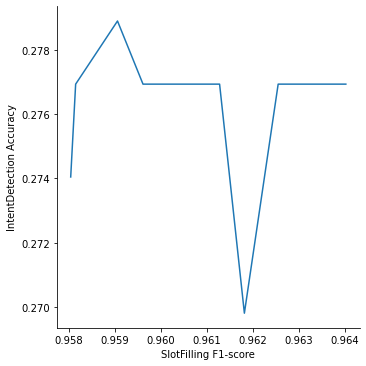

In [17]:
sns.relplot(data=tmp, x=('test_f1', 'slot'), y=('test_acc', 'intent'), kind='line')
plt.xlabel('SlotFilling F1-score')
plt.ylabel('IntentDetection Accuracy')
plt.savefig('plots/new_model_atis.pdf', bbox_inches='tight')